<h1>Introduction</h1>

Here it will be demonstrated how to use Centrifuge to leverage scikit-learn's DBSCAN algorithm to analyze executables of various sizes, functions and architectures. By analyzing a diverse set of executables, we can get a sense for both similarities and differences across formats and target CPU families. Executable binaries typically contain a wide variety of different types of information, but here the main focus will be on machine code, since the two-fold design goal of this tool was 
 1. automatic discovery of machine code present in a file and then
 2. determination of its target architecture

Files chosen for analysis:

 - ELF binaries:
  - [readelf (x86)](http://ftp.us.debian.org/debian/pool/main/b/binutils/binutils_2.28-5_i386.deb)
  - [gpdasm  (ARM aarch64)](http://ftp.us.debian.org/debian/pool/main/g/gputils/gputils_1.4.0-0.1+b1_arm64.deb)
  - [wifiHD_2_1.elf (AVR)](https://github.com/arduino/ArduinoCore-avr/raw/master/firmwares/wifishield/binary/wifiHD_2_1.elf)

- Firmware:
  - [P2261_v3.48.bin (MIPS)](https://www.draytek.com.tw/ftp/VigorSwitch%20P2261/Firmware/v3.48/VigorSwitch-P2261_v3.48.zip)
  - [FW_CM170_1.1.04_2249_FSI.img (Xtensa)](https://www.flandersscientific.com/firmware/11042249/FW_CM170_1.1.04_2249_FSI.img.zip)
  - [P3_530.bin (PowerPC)](https://ftp.automationdirect.com/firmware/FirmwareOnly/P3-530_1.2.7.39.adfw)
  
Following the analysis of each of these files, the code extracted from each of these files will be analyzed side be side.
  
<hr>

In [1]:
# get things set up

import seaborn as sns
import pandas as pd
import sys
sys.path[0:0] = ['.', '..']               # the centrifuge library files are located in ../centrifuge

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]  # we want large, uniformly-sized plots
from centrifuge.binfile import BinFile

SIZE = 1024

<h1>ELF Binaries</h1>

<h2>1. readelf (x86)</h2>

First, the file is read into memory and split into blocks of size 1024.

In [2]:
file_handle = open("../files/ELF/i686-linux-gnu-readelf", "rb")
readelf = BinFile(file_handle)

readelf.set_block_size(SIZE)
readelf.slice_file()

<h3>File Information Visualization</h3>

Next, some insight into how information is organized in the file can be gained by visualizing its entropy.

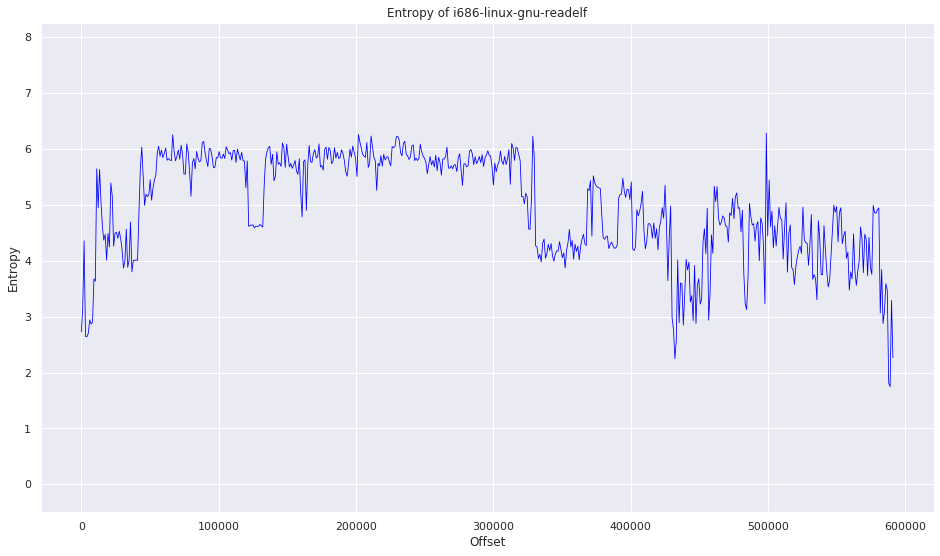

In [3]:
readelf.plot_file_entropy()

It seems entropy is variable, but falls between 2 and 6.

This ELF binary has an intact section header table, so this can
be parsed to determine where the `.text` section lies. Machine code
is located in this section.

```
$ readelf -SW i686-linux-gnu-readelf 
There are 29 section headers, starting at offset 0x901b4:

Section Headers:
  [Nr] Name              Type            Addr     Off    Size   ES Flg Lk Inf Al
  [ 0]                   NULL            00000000 000000 000000 00      0   0  0
  [ 1] .interp           PROGBITS        00000154 000154 000013 00   A  0   0  1
  [ 2] .note.ABI-tag     NOTE            00000168 000168 000020 00   A  0   0  4
  [ 3] .note.gnu.build-id NOTE            00000188 000188 000024 00   A  0   0  4
  [ 4] .gnu.hash         GNU_HASH        000001ac 0001ac 000034 04   A  5   0  4
  [ 5] .dynsym           DYNSYM          000001e0 0001e0 000510 10   A  6   1  4
  [ 6] .dynstr           STRTAB          000006f0 0006f0 0002f6 00   A  0   0  1
  [ 7] .gnu.version      VERSYM          000009e6 0009e6 0000a2 02   A  5   0  2
  [ 8] .gnu.version_r    VERNEED         00000a88 000a88 000050 00   A  6   1  4
  [ 9] .rel.dyn          REL             00000ad8 000ad8 001af8 08   A  5   0  4
  [10] .rel.plt          REL             000025d0 0025d0 0001f8 08  AI  5  25  4
  [11] .init             PROGBITS        000027c8 0027c8 000023 00  AX  0   0  4
  [12] .plt              PROGBITS        000027f0 0027f0 000400 04  AX  0   0 16
  [13] .plt.got          PROGBITS        00002bf0 002bf0 000010 00  AX  0   0  8
  [14] .text             PROGBITS        00002c00 002c00 04ddd2 00  AX  0   0 16
  [15] .fini             PROGBITS        000509d4 0509d4 000014 00  AX  0   0  4
  [16] .rodata           PROGBITS        00050a00 050a00 0297c4 00   A  0   0 32
  [17] .eh_frame_hdr     PROGBITS        0007a1c4 07a1c4 0007f4 00   A  0   0  4
  [18] .eh_frame         PROGBITS        0007a9b8 07a9b8 013714 00   A  0   0  4
  [19] .init_array       INIT_ARRAY      0008f234 08e234 000004 04  WA  0   0  4
  [20] .fini_array       FINI_ARRAY      0008f238 08e238 000004 04  WA  0   0  4
  [21] .jcr              PROGBITS        0008f23c 08e23c 000004 00  WA  0   0  4
  [22] .data.rel.ro      PROGBITS        0008f240 08e240 000c88 00  WA  0   0 32
  [23] .dynamic          DYNAMIC         0008fec8 08eec8 000100 08  WA  6   0  4
  [24] .got              PROGBITS        0008ffc8 08efc8 000030 04  WA  0   0  4
  [25] .got.plt          PROGBITS        00090000 08f000 000108 04  WA  0   0  4
  [26] .data             PROGBITS        00090120 08f120 000f94 00  WA  0   0 32
  [27] .bss              NOBITS          000910c0 0900b4 0027f8 00  WA  0   0 32
  [28] .shstrtab         STRTAB          00000000 0900b4 0000fe 00      0   0  1
```

The `.text` section (number 14 above) begins at file offset `0x002c00` and is of size `0x04ddd2`. This information can be used to clearly mark where in the file the machine code resides.

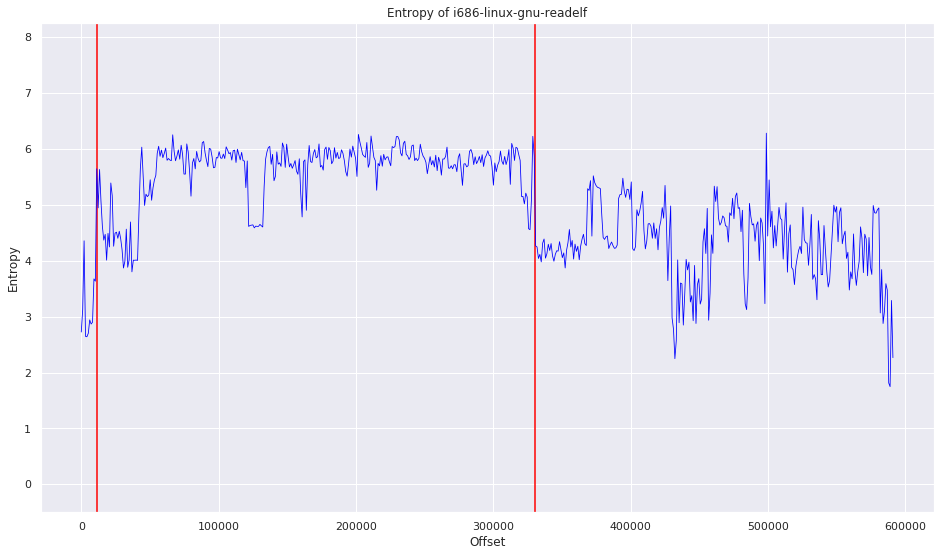

In [4]:
readelf.plot_file_entropy(0x002c00, 0x002c00 + 0x04ddd2)

Observations:

 - the entropy level of machine code in the `.text` section (between the red lines) appears to be around 6 for the most part
 - though the information between the red lines on the plot above is primarily machine code, there is still some variability
  - this level of variability in entropy appears to be different from that of the information outside of the red lines
  - entropy level of information outside of the red lines appears to be lower and less uniform
  
Aside from entropy level, visualization of other variables can be useful. For example, plots of the proportion of `00` bytes in each block and block medians:

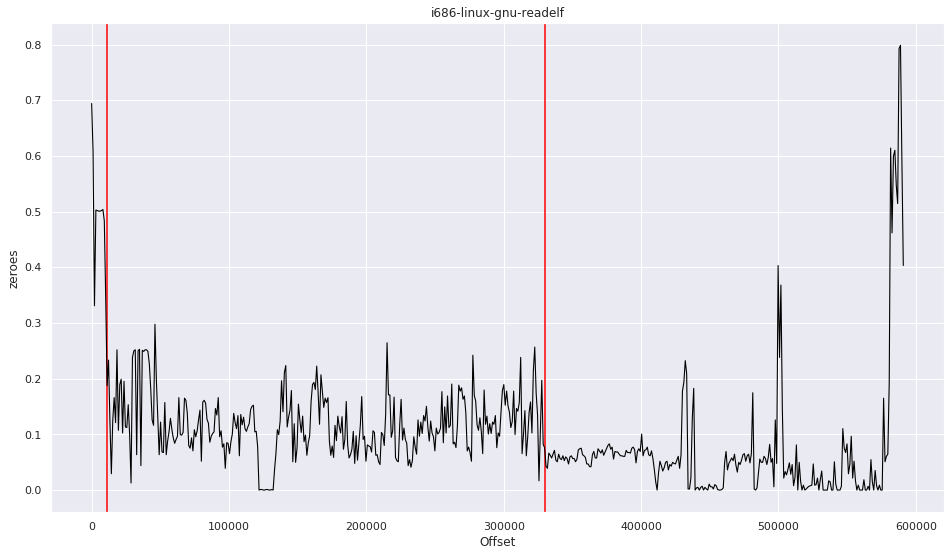

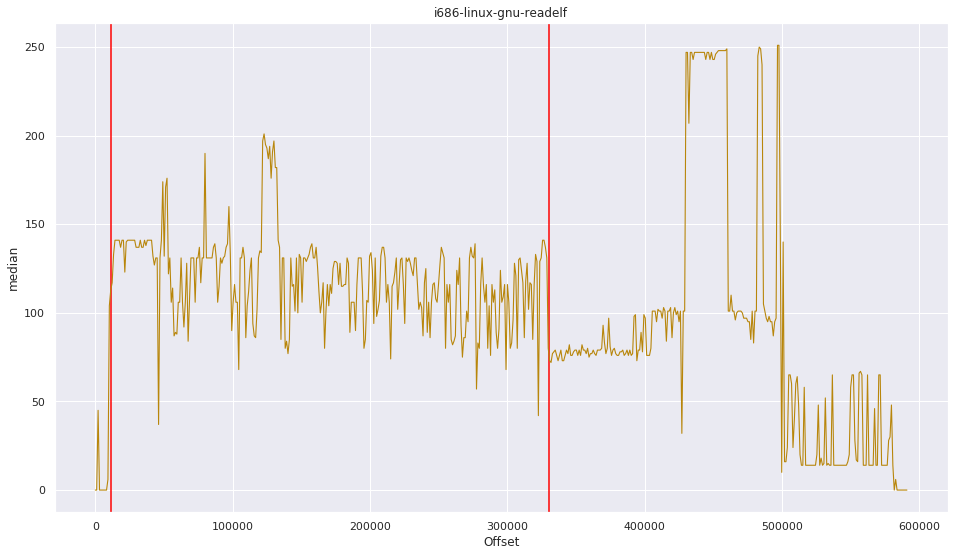

In [5]:
readelf.plot_file_feature("zeroes", "black", 0x002c00, 0x002c00 + 0x04ddd2)
readelf.plot_file_feature("median", "darkgoldenrod", 0x002c00, 0x002c00 + 0x04ddd2)

These plots reveal that some statistical properties of machine code plainly differ from those of other types of information (in this file at least). These differences can be exploited to automatically differentiate between code and non-code information in an executable binary.

Perhaps using DBSCAN to analyze the file will reveal more.

<h3>Clustering with DBSCAN</h3>

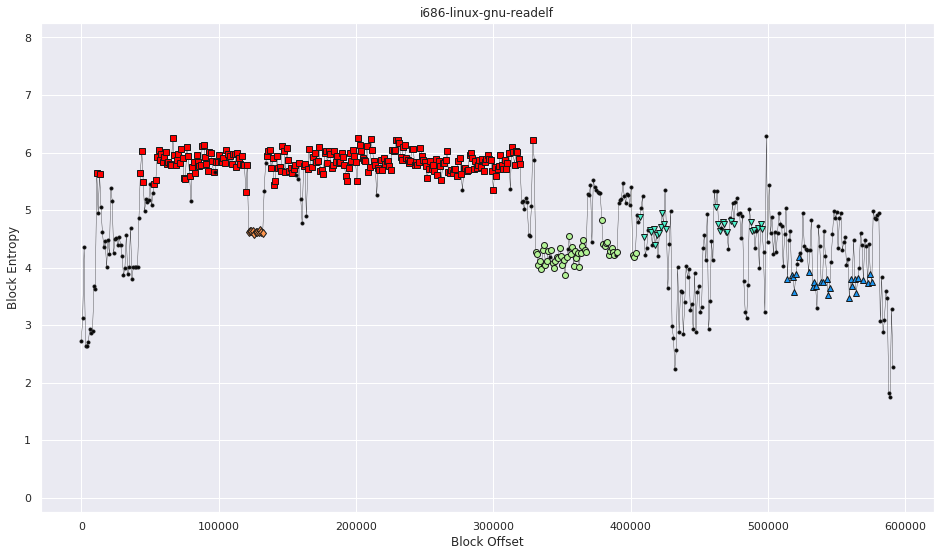

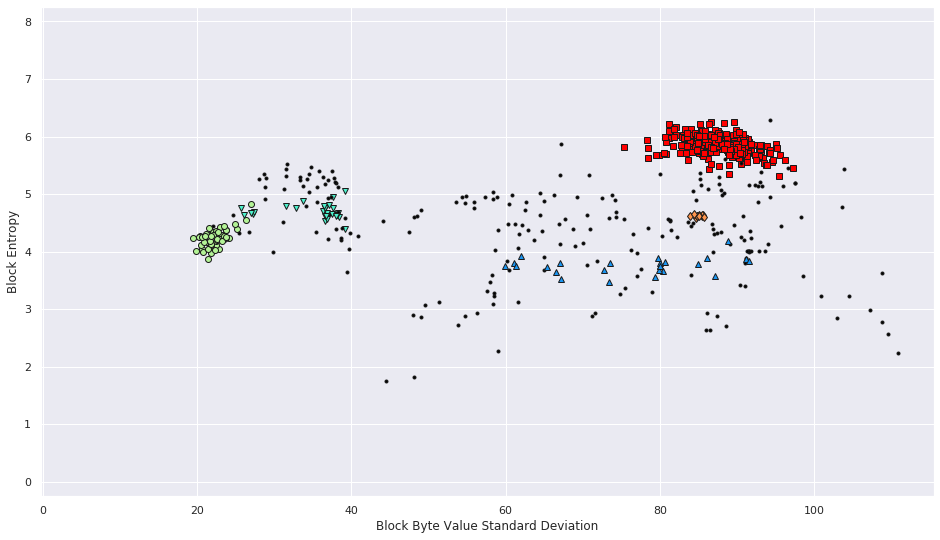

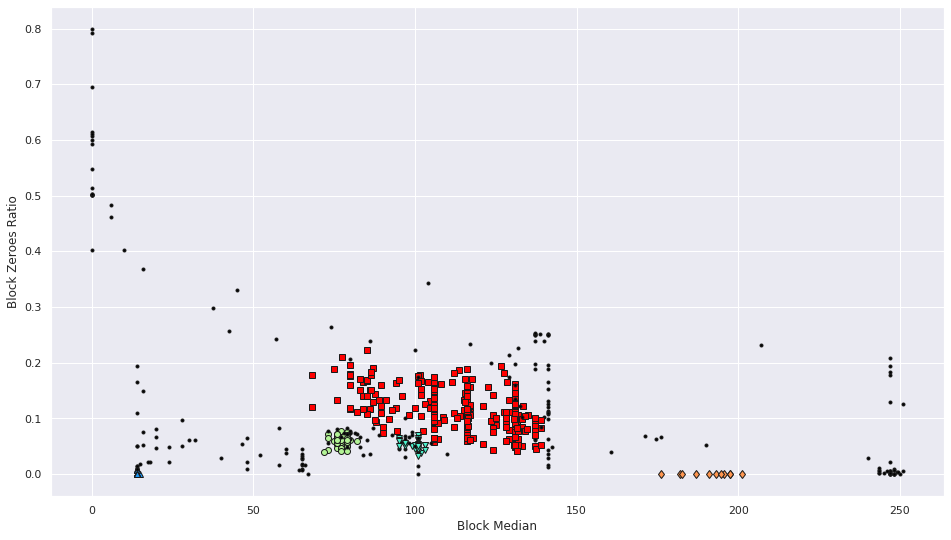

In [288]:
readelf.cluster_DBSCAN(epsilon=0.5,                           
                       minimum_samples=10,          
                       find_optimal_epsilon=False)
readelf.plot_DBSCAN_results()

Looking at the first plot above in which the results of DBSCAN are overlaid onto the entropy plot, we can see that the clustering algorithm automatically grouped the machine code into the same cluster marked by the **red squares**. Interestingly, an additional cluster - the orange diamonds - was found within the `.text` section, beginning at offset ~110000. Further investigation reveals that this area within the file consists of similar values that repeat over and over:

```
0001d560  0c e9 8a f0 ff ff 8d 76  00 8d bc 27 00 00 00 00  |.......v...'....|
0001d570  8b 44 24 18 83 f8 0d 0f  87 a3 f8 ff ff 8b 84 83  |.D$.............|
0001d580  e4 f6 fd ff 01 d8 ff e0  90 8d b4 26 00 00 00 00  |...........&....|
0001d590  8b 44 24 18 e8 07 9b fe  ff 89 44 24 0c e9 4e f0  |.D$.......D$..N.|
0001d5a0  ff ff 66 83 f8 06 0f 85  74 f8 ff ff 8b 44 24 18  |..f.....t....D$.|
0001d5b0  e8 5b 7b fe ff 89 44 24  0c e9 32 f0 ff ff 66 90  |.[{...D$..2...f.|
0001d5c0  8b 44 24 18 e8 17 a2 fe  ff 89 44 24 0c e9 1e f0  |.D$.......D$....|
0001d5d0  ff ff 8d b6 00 00 00 00  8b 44 24 18 83 f8 1f 0f  |.........D$.....|
0001d5e0  87 3b f8 ff ff 8b 84 83  1c f7 fd ff 01 d8 ff e0  |.;..............|
0001d5f0  8b 44 24 18 e8 27 70 fe  ff 89 44 24 0c e9 ee ef  |.D$..'p...D$....|
0001d600  ff ff 8d b6 00 00 00 00  8b 44 24 18 83 f8 15 0f  |.........D$.....|
0001d610  87 0b f8 ff ff 8b 84 83  9c f7 fd ff 01 d8 ff e0  |................|
0001d620  8b 44 24 18 e8 f7 8b fe  ff 89 44 24 0c e9 be ef  |.D$.......D$....|
0001d630  ff ff 8d b6 00 00 00 00  8b 44 24 18 83 f8 11 0f  |.........D$.....|
0001d640  87 db f7 ff ff 8b 84 83  f4 f7 fd ff 01 d8 ff e0  |................|
0001d650  8b 44 24 18 e8 47 8f fe  ff 89 44 24 0c e9 8e ef  |.D$..G....D$....|
0001d660  ff ff 8d b6 00 00 00 00  8b 44 24 18 3d e0 00 00  |.........D$.=...|
0001d670  00 0f 87 a9 f7 ff ff 8b  84 83 3c f8 fd ff 01 d8  |..........<.....|
0001d680  ff e0 8d b6 00 00 00 00  8b 44 24 18 e8 5f 88 fe  |.........D$.._..|
0001d690  ff 89 44 24 0c e9 56 ef  ff ff 66 83 f8 2b 0f 84  |..D$..V...f..+..|
0001d6a0  ae 01 00 00 66 83 f8 2d  0f 85 72 f7 ff ff 8b 44  |....f..-..r....D|
0001d6b0  24 18 e8 59 67 fe ff 89  44 24 0c e9 30 ef ff ff  |$..Yg...D$..0...|
```

As a result of this kind of repetition and local homogeneity, this region has different statistical properties from the rest of the information in the `.text` section and is assigned to its own cluster, a different one from the machine code. If our goal is to identify the target architecture of the machine code based on its statistical properties then this is very helpful, since byte values repeated thousands of times consecutively would just add noise to the code cluster. This also shows that even though machine code is placed within the `.text` section, the information in the `.text` section is not necessarily 100% machine code.

The differences in distributions of block feature observations within each cluster can be analyzed using violin plots. Each violin plot represents one cluster for a chosen feature. Below, the distribution of block means and standard deviations within each cluster are plotted.

<h3>Univariate Analysis of Cluster Features</h3>

In [7]:
# The cluster containing machine code (labelled with red squares in the plots above) is the largest

for i in range(0,6):
    print("Cluster %d shape: %s" % (i, readelf.dbscan_data_frame.loc[readelf.dbscan_data_frame['cluster labels'] == i].shape))

Cluster 0 shape: (242, 9)
Cluster 1 shape: (11, 9)
Cluster 2 shape: (49, 9)
Cluster 3 shape: (27, 9)
Cluster 4 shape: (25, 9)
Cluster 5 shape: (0, 9)


Cluster 0 is by far the largest, so must be the one consisting of red squares (machine code).

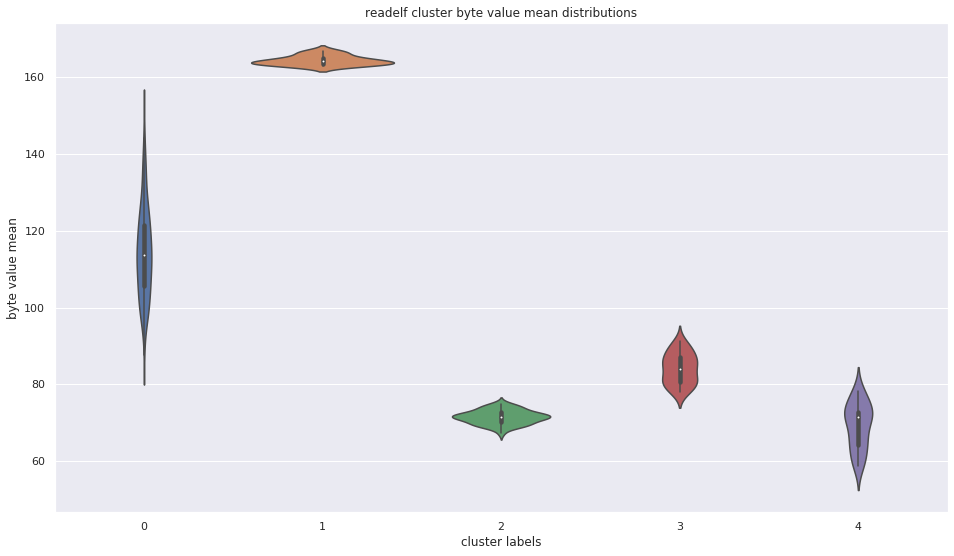

In [78]:
ax = sns.violinplot(x = "cluster labels",
                    y = "byte value mean",
                    data = readelf.dbscan_data_frame[readelf.dbscan_data_frame["cluster labels"] != -1])
ax.set_title("readelf cluster byte value mean distributions")
plt.show()

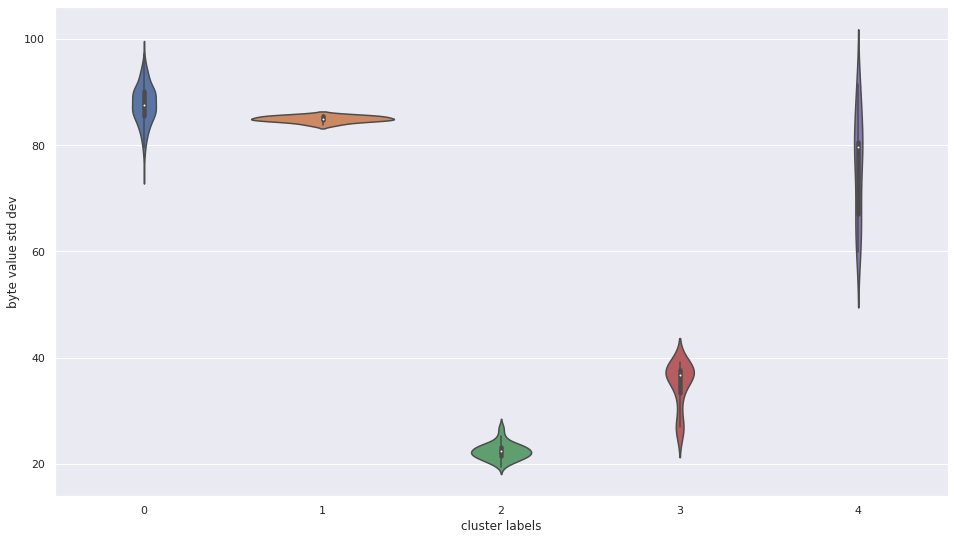

In [9]:
ax = sns.violinplot(x = "cluster labels",
                    y = "byte value std dev",
                    data = readelf.dbscan_data_frame[readelf.dbscan_data_frame["cluster labels"] != -1])
plt.show()

It is clear from the shapes of the violins in these plots that each cluster has its own "profile", so to speak: within each cluster, the distribution of a particular feature is unique. These results that it may be possible to use this approach to not only differentiate between code and non-code, but to identify different types of information within a file, such as compressed data or text data.

If one wishes to focus on a particular cluster (such as cluster 0, the one containing machine code), the bytes in the cluster of interest can be extracted and analyzed seperately. 

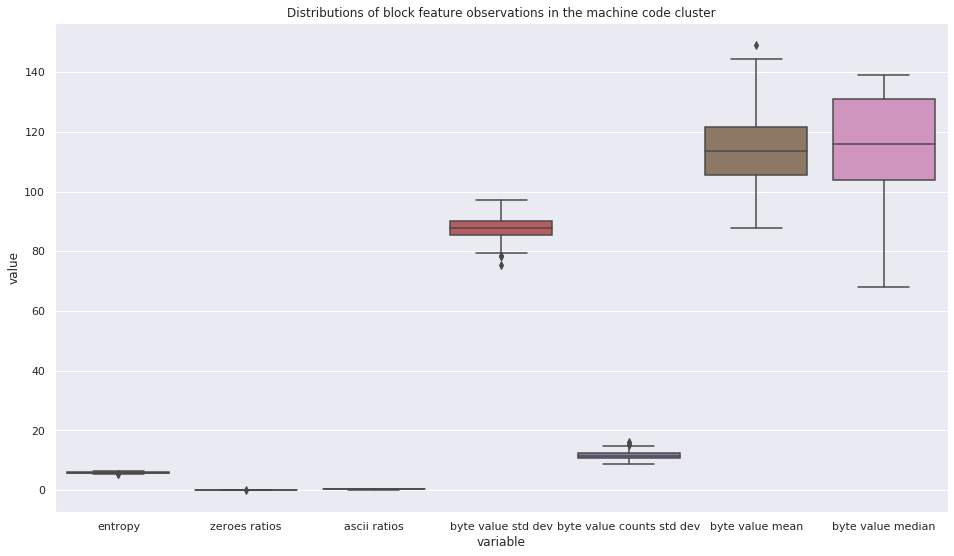

In [10]:
readelf_code_cluster = readelf.dbscan_data_frame[readelf.dbscan_data_frame["cluster labels"] == 0] # use filtering to extract cluster containing code

# thank you
# https://stackoverflow.com/questions/49554139/boxplot-of-multiple-columns-of-a-pandas-dataframe-on-the-same-figure-seaborn
ax = sns.boxplot(x="variable", 
                 y="value", 
                 data=pd.melt(readelf_code_cluster.drop(["core samples mask", "cluster labels"], axis = 1)))
ax.set_title("Distributions of block feature observations in the machine code cluster")
plt.show()

Plotting the distributions of each variable on the same chart is a problem because of the wildly different ranges, so it may be better to plot variables with similar ranges together. Below, the variables that measure central tendancy and distribution are shown in one plot, and the variables measuring ratios (printable ASCII range, 0x00 bytes) are shown in another.

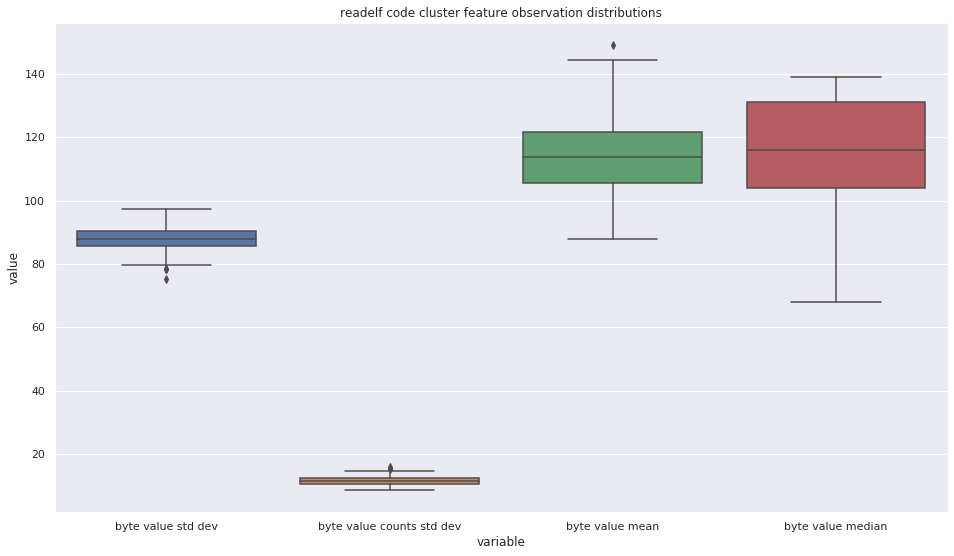

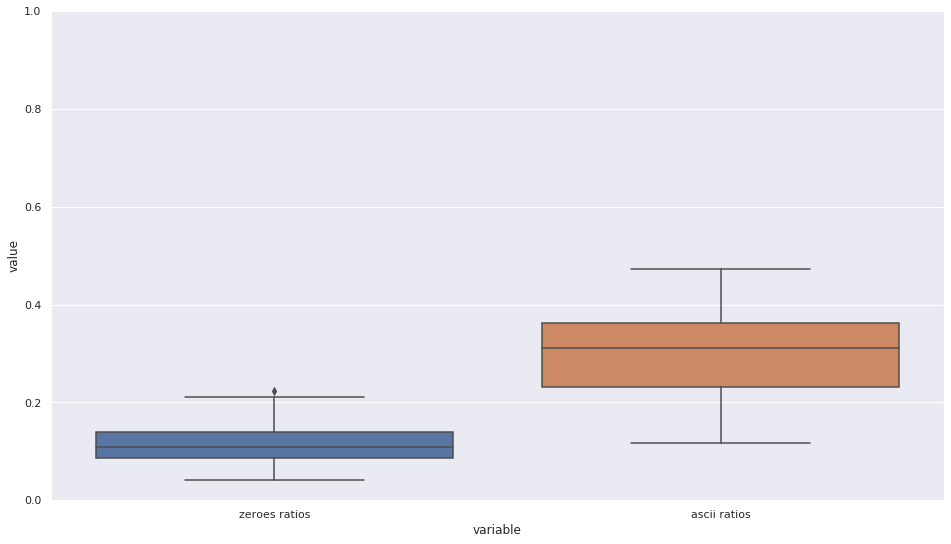

In [77]:
ax = sns.boxplot(x="variable", y="value", data=pd.melt(readelf_code_cluster[["byte value std dev", "byte value counts std dev", "byte value mean", "byte value median"]]))
ax.set_title("readelf code cluster feature observation distributions")
plt.show()

ax = sns.boxplot(x="variable", y="value", data=pd.melt(readelf_code_cluster[["zeroes ratios", "ascii ratios"]]))
ax.set_ylim(0,1)
plt.show()

<h3>Cluster Byte Value Distribution Analysis</h3>

In addition to examining cluster features individually, it is also possible to analyze the bytes assigned to a particular cluster as a whole. For example, we can visualize the distribution of byte values in a cluster in a variety of ways, as shown in the plots below:

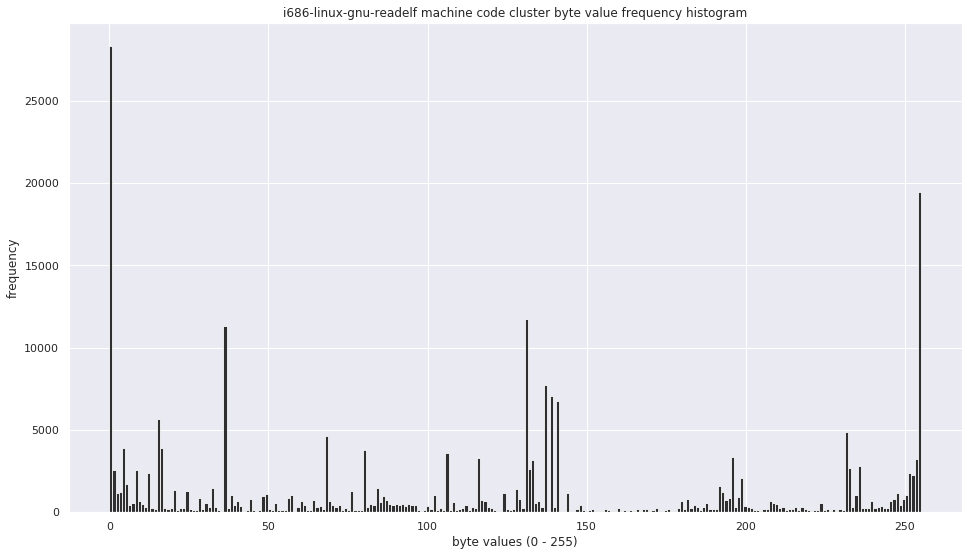

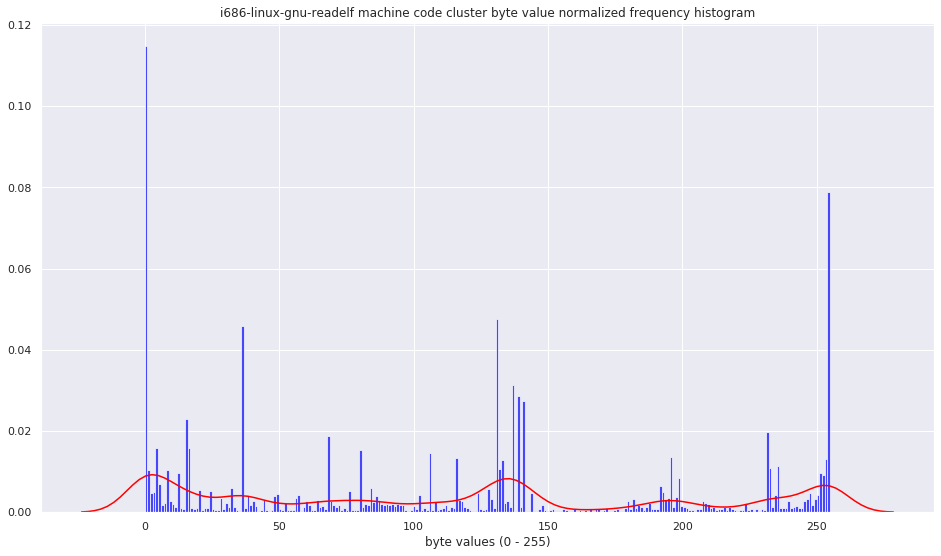

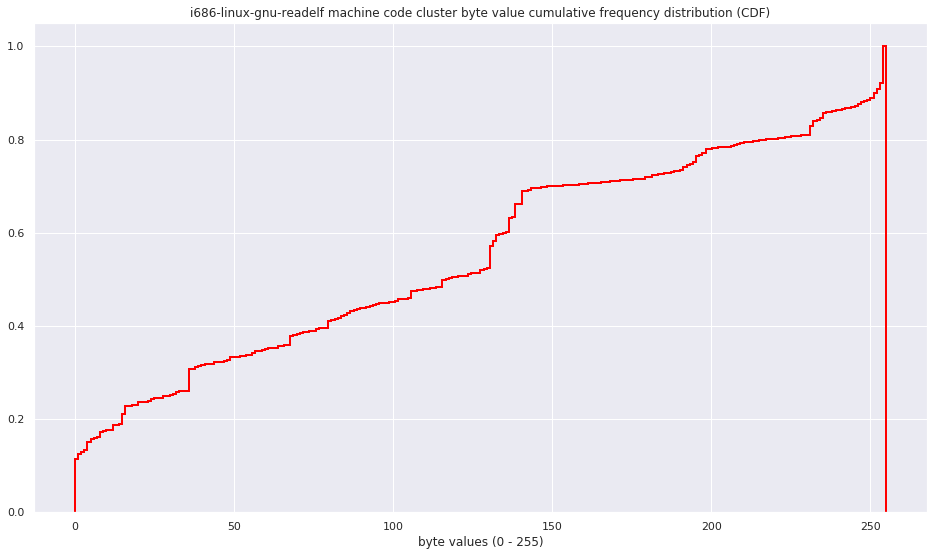

In [12]:
#readelf_code_cluster.index # create CDF of readelf code cluster

readelf_cluster_bytes = []
readelf_cluster_blocks = [readelf.blocks[i] for i in readelf_code_cluster.index]

for block in readelf_cluster_blocks:              # for each block, select the 1024 raw bytes
        readelf_cluster_bytes += block.data       # append these bytes to the list
        
# plot frequency histogram
ax = sns.distplot(list(readelf_cluster_bytes), bins=256, kde=False, color="black", hist_kws={"alpha":0.8})
ax.set_title("i686-linux-gnu-readelf machine code cluster byte value frequency histogram")
ax.set_xlabel("byte values (0 - 255)")
ax.set_ylabel("frequency")
plt.show()

# plot normalized frequency histogram

ax = sns.distplot(list(readelf_cluster_bytes), 
                  bins=256, 
                  kde=True, 
                  color="red", 
                  hist_kws={"alpha":0.7, "color":"blue"})

ax.set_title("i686-linux-gnu-readelf machine code cluster byte value normalized frequency histogram")
ax.set_xlabel("byte values (0 - 255)")
plt.show()
    
# create CDF
ax = sns.distplot(list(readelf_cluster_bytes),
                  norm_hist=True,     # normalize the y-axis. Different clusters have different numbers of blocks.
                  kde=False,
                  hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':2, 'alpha':1},
                  kde_kws={'cumulative': True},  # want CDF
                  bins=256,                      # 1 bin per byte value. Maximum granularity
                  color="red")
ax.set_title("i686-linux-gnu-readelf machine code cluster byte value cumulative frequency distribution (CDF)")
ax.set_xlabel("byte values (0 - 255)")
plt.show()

If the byte-value distribution of machine code is specific to the particular target CPU of that code, then it is possible to use this information to determine the target CPU of machine code in general.

<h3>Cluster Feature Summary Statistics</h3>

In addition to measuring a machine code cluster's distribution of byte values to characterize it, simple summary statistics of its features can be used as a heuristic for comparisons. For example, the means of the 7 features being measured can provide us with a simple "fingerprint" or shortcut for identifying a code cluster: 

In [13]:
readelf_code_cluster.drop(["core samples mask", "cluster labels"], axis = 1).describe().loc['mean']

entropy                        5.843738
zeroes ratios                  0.114274
ascii ratios                   0.297686
byte value std dev            87.770597
byte value counts std dev     11.622925
byte value mean              114.385940
byte value median            113.847107
Name: mean, dtype: float64

In [14]:
file_handle.close()

<hr>

<h2>2. gpdasm (ARM aarch64)</h2>

In [15]:
file_handle = open("../files/ELF/arm64-gpdasm", "rb")
gpdasm = BinFile(file_handle)

gpdasm.set_block_size(SIZE) # 1024
gpdasm.slice_file()

<h2>File Information Visualization</h2>

As usual, we begin with a simple entropy plot:

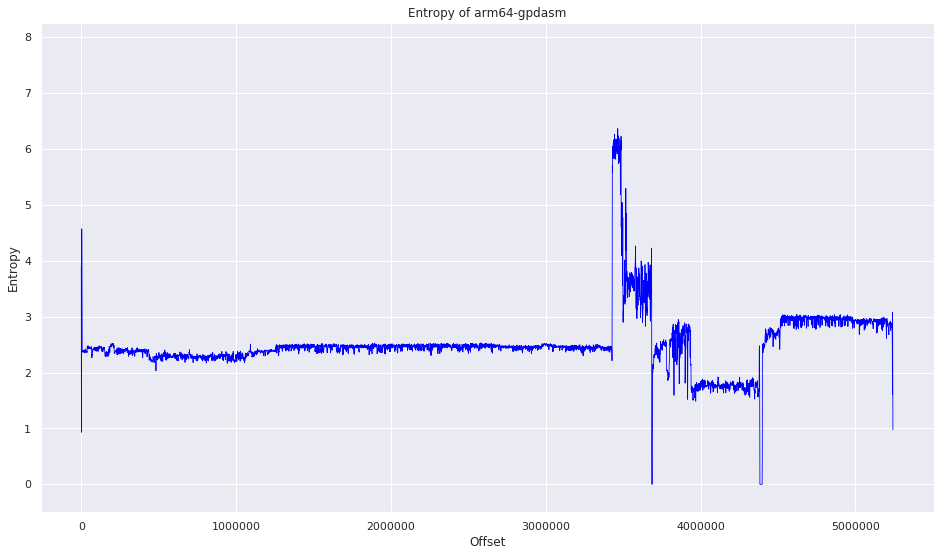

In [16]:
gpdasm.plot_file_entropy()

The way information is arranged in this executable looks rather strange. Where is the machine code? In the `readelf` file analyzed above, the mean entropy of the machine code cluster was 5.84, quite close to 6. In this plot here, there is a proportionally small segment of the file that has a similar level of entropy. When the ELF section header of `gpdasm` is parsed, we see that though this region looks small in the entropy plot, it is actually 56804 bytes in total.

```
Section Headers:
[Nr] Name              Type            Addr             Off    Size   ES Flg Lk Inf Al
...
[13] .text             PROGBITS        00000000003459d0 3459d0 00dde4 00  AX  0   0  8
...
```

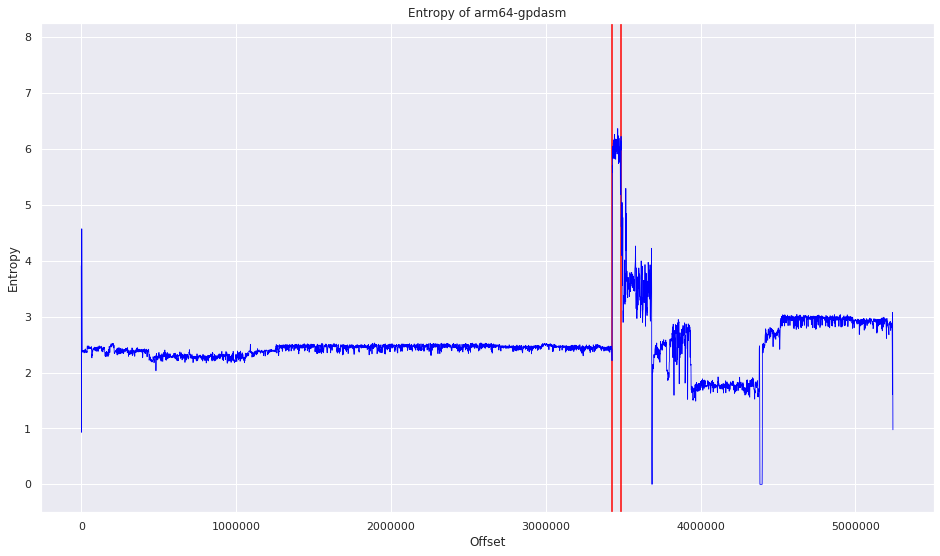

In [17]:
gpdasm.plot_file_entropy(0x3459d0, 0x3459d0 + 0x00dde4)

Will this be enough machine code for DBSCAN to detect? Examination of a scatterplot in which points falling within the `.text` section are highlighted may provide clues.

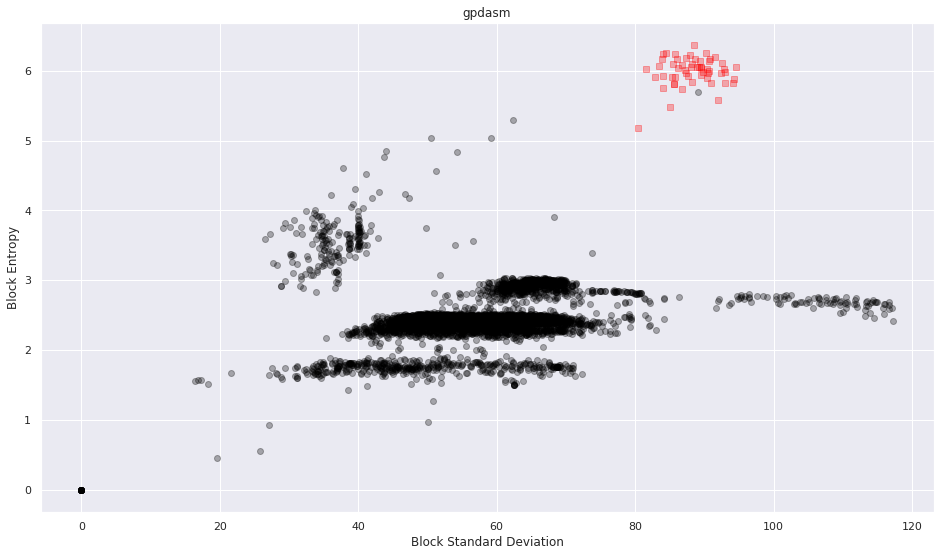

In [18]:
gpdasm.plot_variables_by_range(gpdasm.block_byteval_std_dev,  # 1st variable
                               gpdasm.block_entropy_levels,   # 2nd variable
                               0x3459d0,                       # start file offset (e.g start of .text section)
                               0x3459d0 + 0x00dde4,            # end file offset
                               target_data_marker='s',         # marker shape for points that fall within the specified offsets
                               other_data_marker='o',          # marker for points outside of offsets
                               target_data_color='red',        # color of points inside offsets
                               other_data_color='black',       # color of points outside offsets
                               title='gpdasm',   
                               xlabel='Block Standard Deviation',
                               ylabel='Block Entropy')

As it turns out, the information within the `.text` section (machine code) is clearly different in a quantifiable way from the rest of the information in the file. In spite of the noise, DBSCAN should be able to assign the machine code within this file to its own cluster.

<h3>Clustering with DBSCAN</h3>

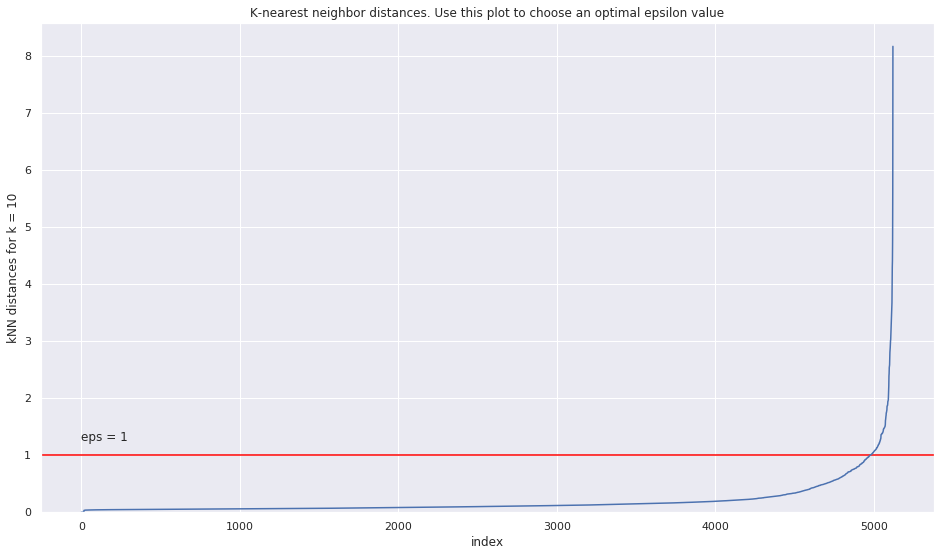

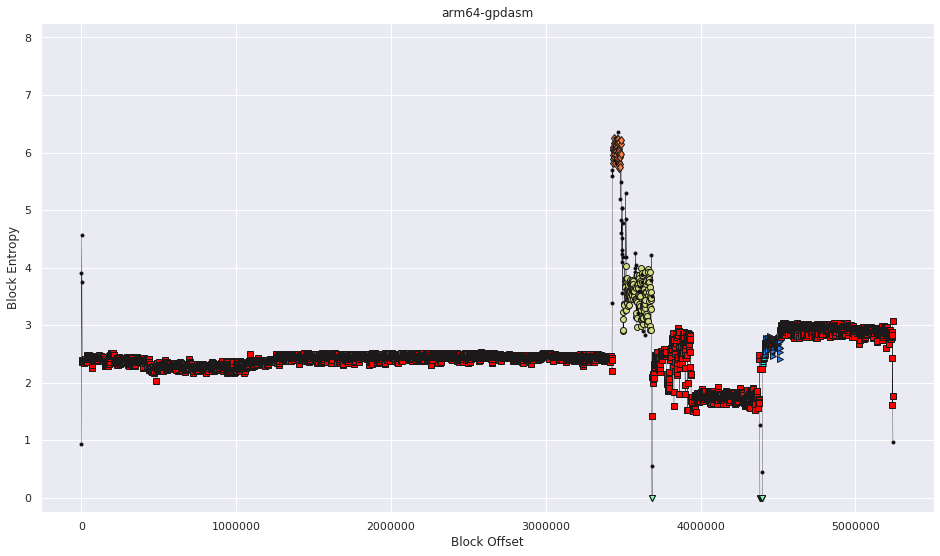

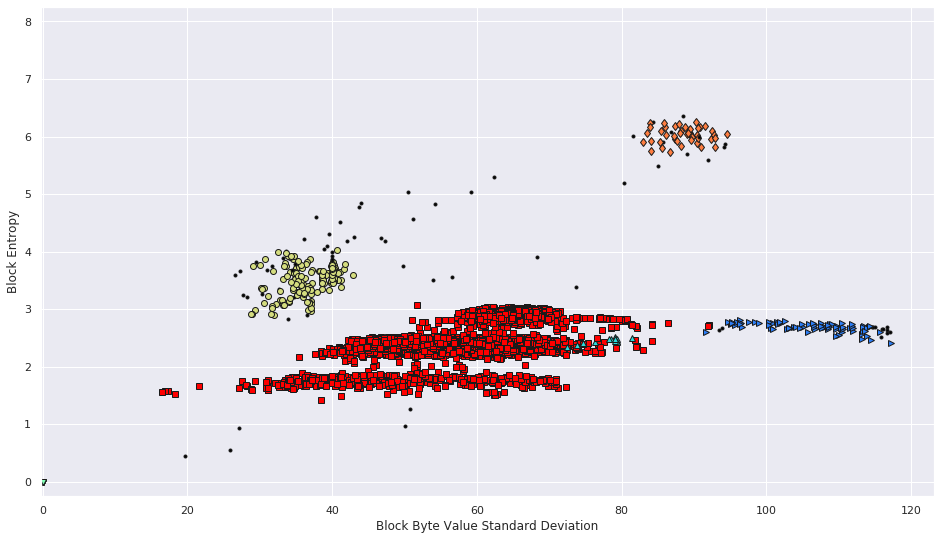

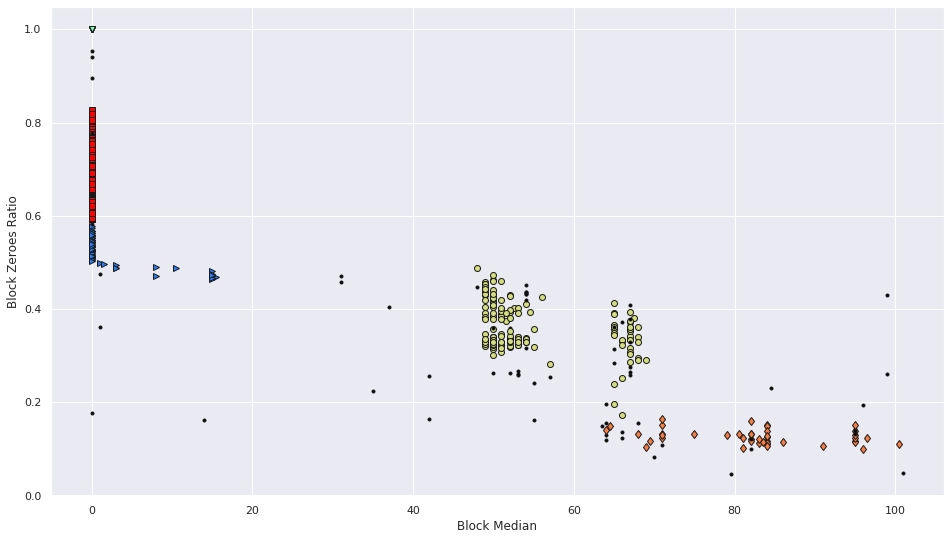

In [19]:
gpdasm.cluster_DBSCAN(1,                           # eps
                      10,                          # min_samples
                      find_optimal_epsilon=True)   # show "knee" plot

gpdasm.plot_DBSCAN_results()

It took longer due to the larger size of the file, but setting `eps` to 1 based on the "knee" plot does the trick. We can see from these plots that the machine code forms its own unique cluster represented by **orange diamonds**.

To get a sense for how DBSCAN goes about assigning cluster labels to blocks, we can look at a pairwise plot in which every feature is plotted against every other feature, with the addition of each point being colored based on its assigned cluster (blocks not assigned to any cluster are filtered out).

/home/user01/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/user01/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


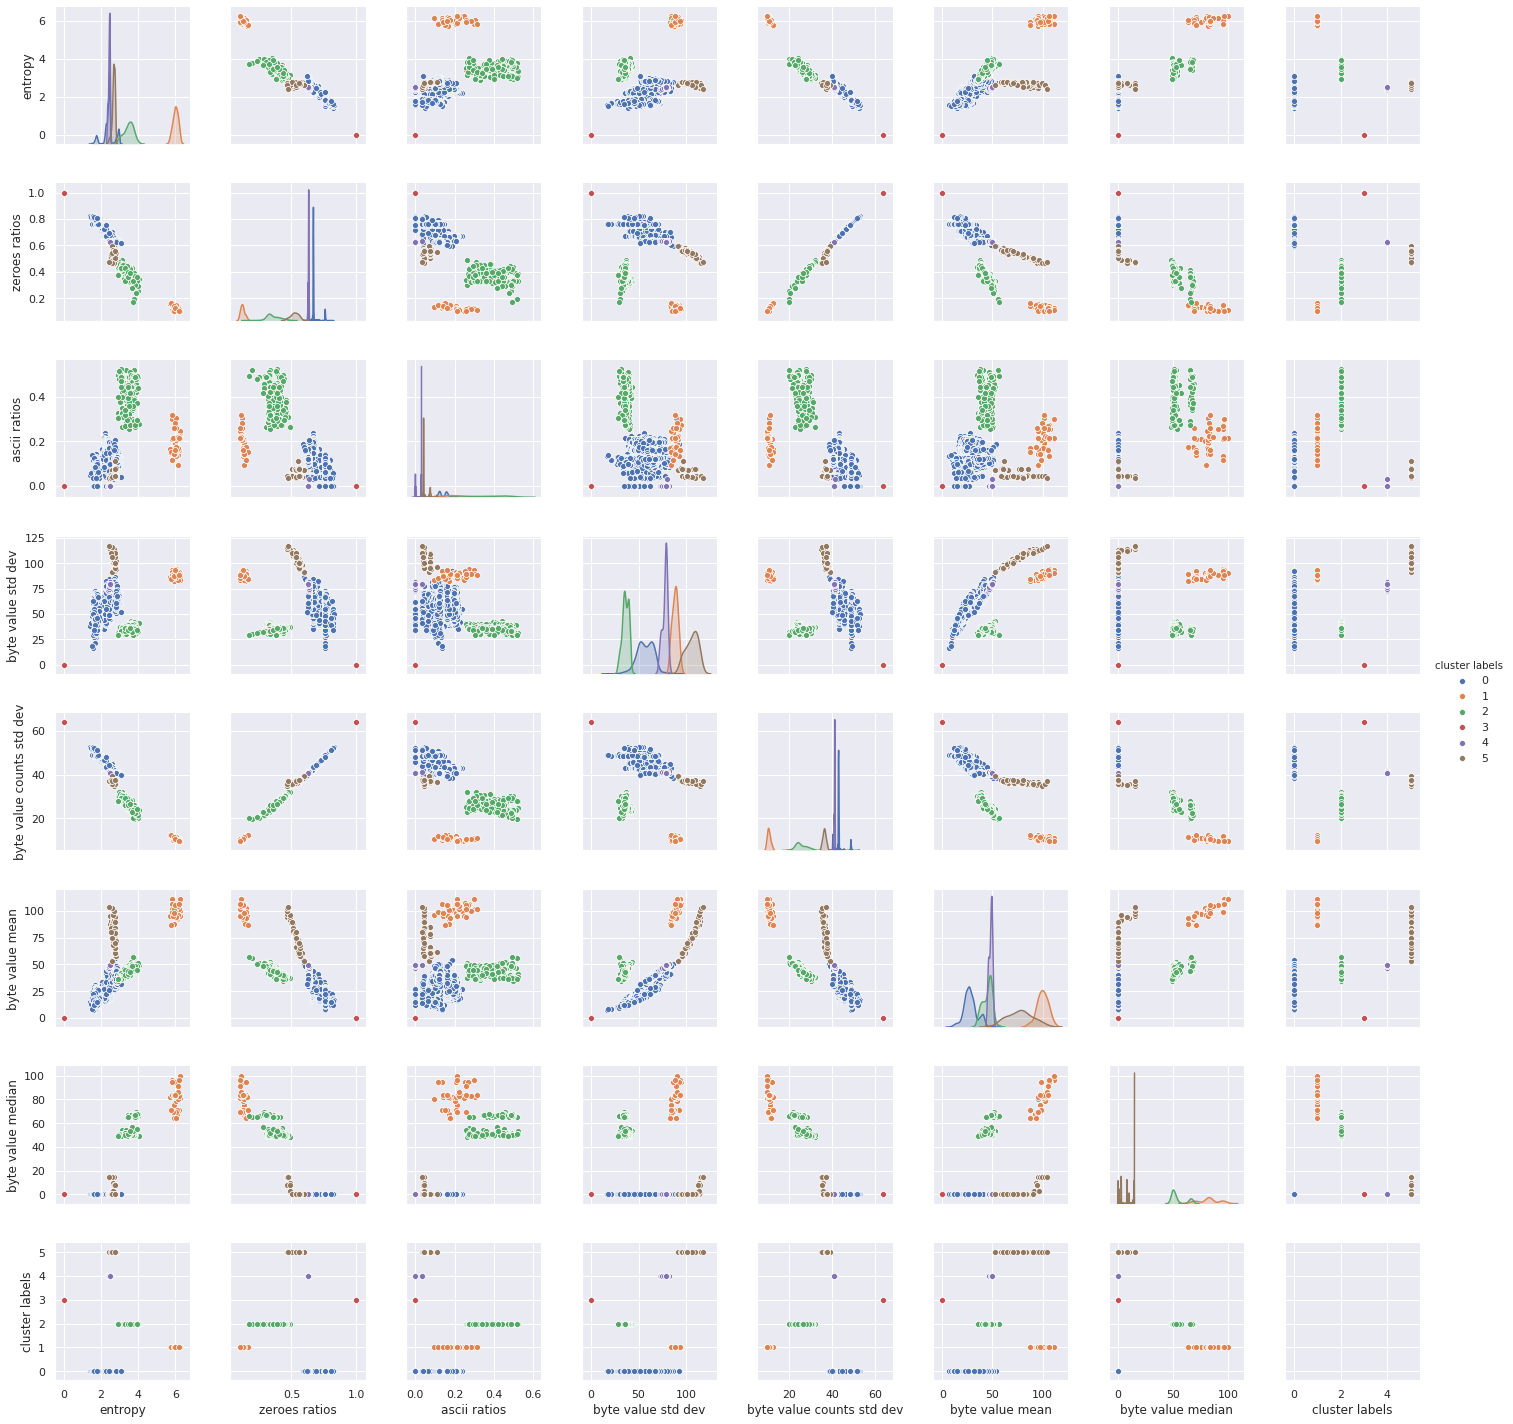

In [20]:
sns.pairplot(gpdasm.dbscan_data_frame[gpdasm.dbscan_data_frame["cluster labels"] != -1].drop(["core samples mask"], axis=1), hue="cluster labels")

<h3>Univariate Analysis of Cluster Features</h3>

As with `readelf`, various features of each cluster can be visualized.

In [21]:
for i in range(0,6):
    print("Cluster %d shape: %s" % (i, gpdasm.dbscan_data_frame.loc[gpdasm.dbscan_data_frame['cluster labels'] == i].shape))

Cluster 0 shape: (4743, 9)
Cluster 1 shape: (43, 9)
Cluster 2 shape: (151, 9)
Cluster 3 shape: (17, 9)
Cluster 4 shape: (13, 9)
Cluster 5 shape: (76, 9)


Cluster 1 contains the file's machine code: entropy level is around 6 on average and it has a standard deviation of around 90 (from the plots above) on average.

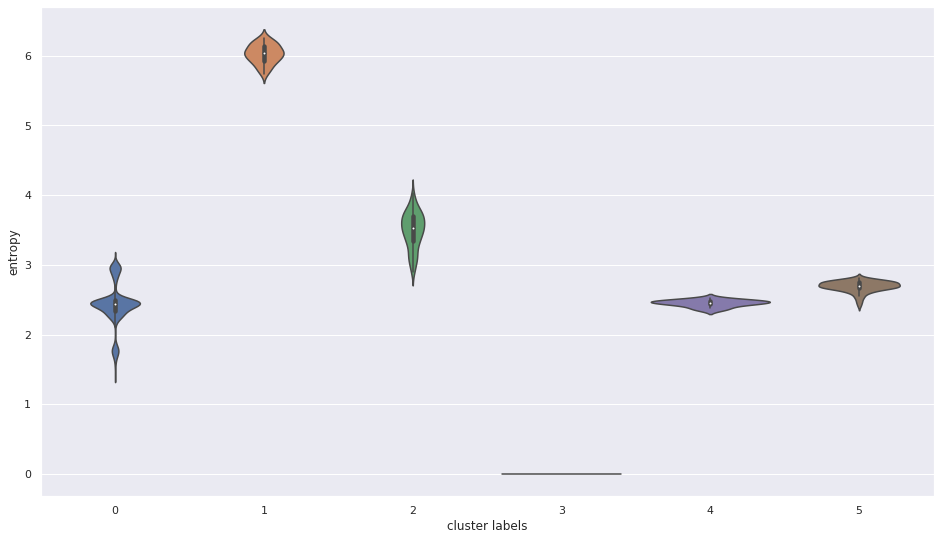

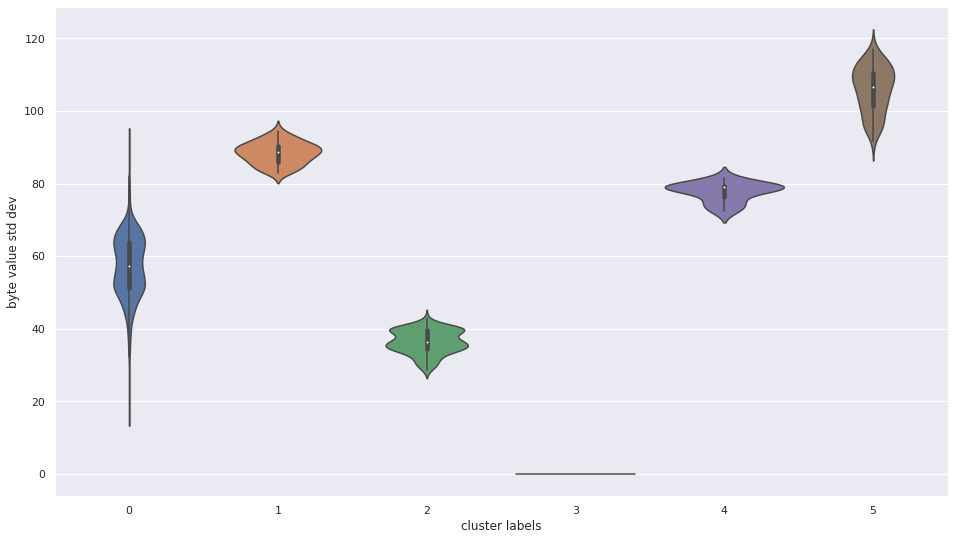

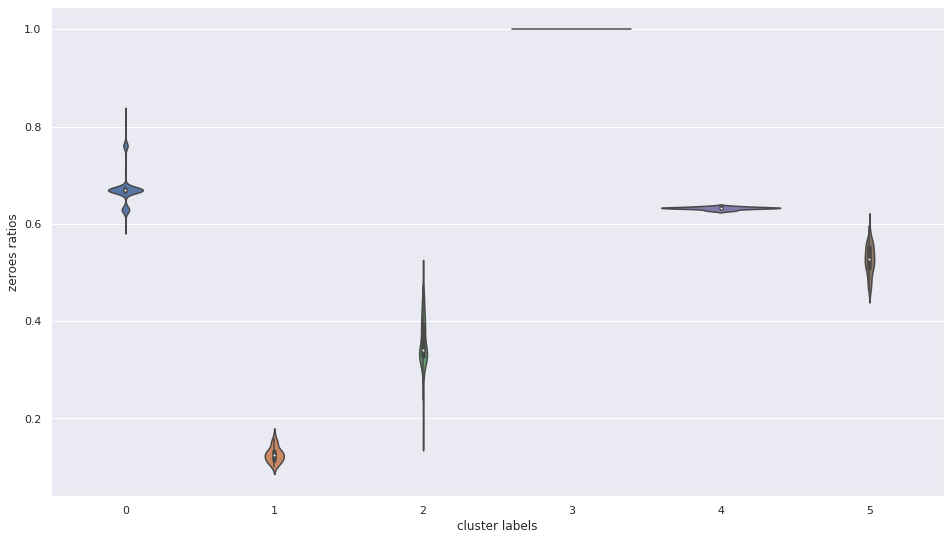

In [22]:
columns = ["entropy", "byte value std dev", "zeroes ratios"]
for column in columns:
    ax = sns.violinplot(x = "cluster labels", 
                        y = column,
                        data = gpdasm.dbscan_data_frame[gpdasm.dbscan_data_frame["cluster labels"] != -1]) # exclude rows with cluster label -1
    plt.show()

We can once again easily see that each cluster has unique characteristics.

<h3>Cluster Byte Value Distribution Analysis</h3>

Let us now examine the distribution of byte values in the code in cluster 1 and compare it to the code from `readelf` above.

In [23]:
gpdasm_code_cluster = gpdasm.dbscan_data_frame[gpdasm.dbscan_data_frame["cluster labels"] == 1] # use filtering to extract cluster containing code

gpdasm_cluster_bytes = []
gpdasm_cluster_blocks = [gpdasm.blocks[i] for i in gpdasm_code_cluster.index]

for block in gpdasm_cluster_blocks:              # for each block, select the 1024 raw bytes
        gpdasm_cluster_bytes += block.data       # append these bytes to the list

In [24]:
# define a plotting function here that helps us visualize the byte value distrubution of multiple code segments

def plot_cdfs(code_segments, legend_labels):
    for segment in code_segments:
        ax = sns.distplot(list(segment),
                          norm_hist=True,     # normalize the y-axis. Different clusters have different numbers of blocks.
                          kde=False,
                          hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':2, 'alpha':1},
                          kde_kws={'cumulative': True},  # want CDF
                          bins=256)                      # 1 bin per byte value. Maximum granularity
        
    plt.legend(legend_labels,
               loc="upper left")
    plt.show()

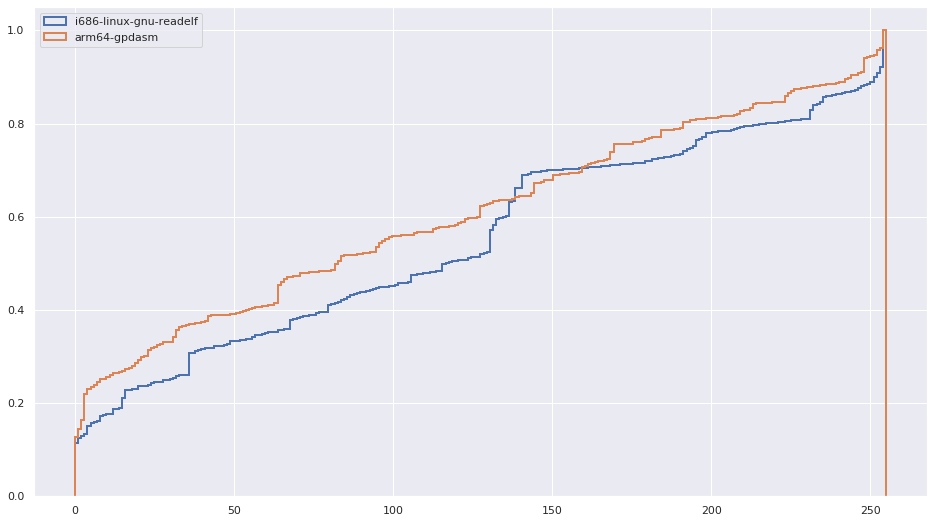

In [25]:
plot_cdfs([readelf_cluster_bytes, gpdasm_cluster_bytes], ["i686-linux-gnu-readelf","arm64-gpdasm"])

Interesting. It appears that the distribution of byte values in machine code may vary across architectures.

Let us examine how the means of the features of the machine code of`readelf` and `gpdasm` differ:

In [26]:
readelf_feature_means = readelf_code_cluster.drop(["core samples mask", "cluster labels"], axis = 1).describe().loc['mean']
gpdasm_feature_means = gpdasm_code_cluster.drop(["core samples mask", "cluster labels"], axis = 1).describe().loc['mean']
summary_df = pd.DataFrame(data={'readelf': readelf_feature_means, 'gpdasm':gpdasm_feature_means})
summary_df.T

entropy  zeroes ratios  ascii ratios  byte value std dev  \
readelf  5.843738       0.114274      0.297686           87.770597   
gpdasm   6.026331       0.126363      0.204578           88.467059   

         byte value counts std dev  byte value mean  byte value median  
readelf                  11.622925       114.385940         113.847107  
gpdasm                   10.726670       100.342251          82.302326

While entropy levels between the ARM64 and x86 code appear to be nearly identical, the figures here show that there are some big differences in their respective average byte value means and medians. This also points to differences in byte value distributions.

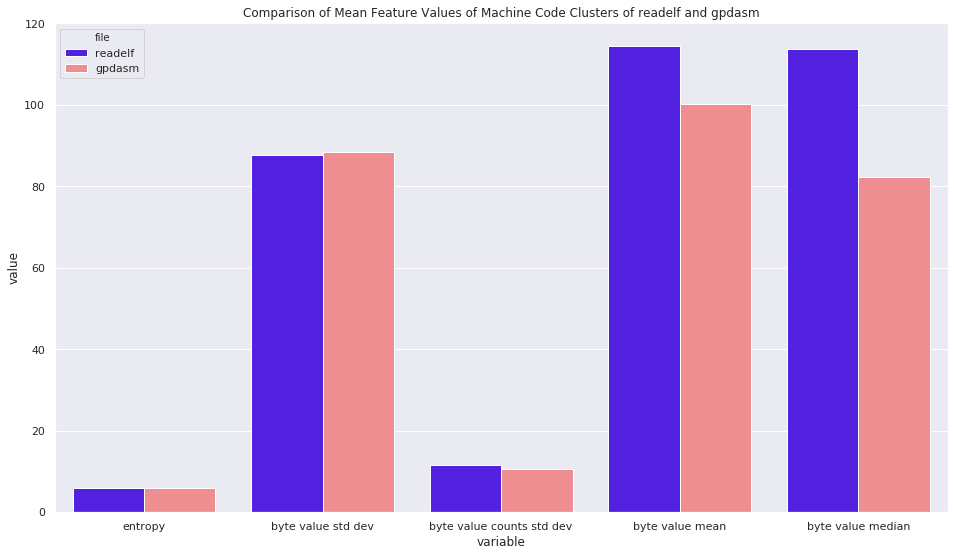

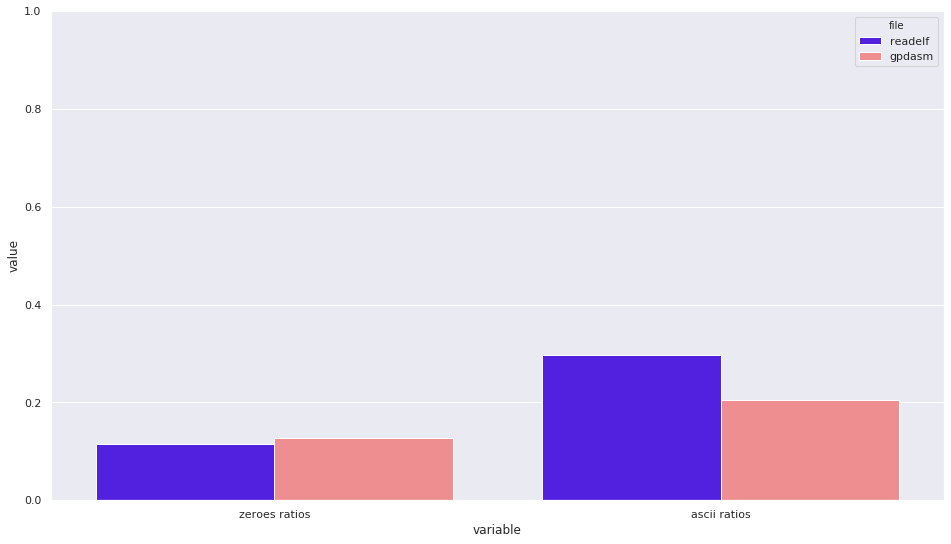

In [76]:
# in order to create a paired barplot, it was necessary to first transpose the dataframe,
# create a column indicating which file the feature was from, and then melt the dataframe

summary_t_df = summary_df.T.drop(["zeroes ratios", "ascii ratios"], axis=1)
summary_t_df['file'] = summary_t_df.index
summary_t_df = pd.melt(summary_t_df, id_vars="file") # thank you https://stackoverflow.com/questions/38609339/pandas-dataframe-to-seaborn-grouped-barchart
#summary_t_df

ax = sns.barplot(x="variable", y="value", hue="file", data=summary_t_df, palette="gnuplot2")
ax.set_title("Comparison of Mean Feature Values of Machine Code Clusters of readelf and gpdasm")
plt.show()

summary_t_df_2 = summary_df.T[["zeroes ratios", "ascii ratios"]]
summary_t_df_2["file"] = summary_t_df_2.index
summary_t_df_2 = pd.melt(summary_t_df_2, id_vars="file")
summary_t_df_2

ax = sns.barplot(x="variable", y="value", hue="file", data=summary_t_df_2, palette="gnuplot2")
ax.set_ylim(0,1)
plt.show()

Since entropy levels of x86 and ARM64 machine code are so similar, perhaps entropy level can help us distinguish code from non-code information across architectures. That is, if machine code generally has the same entropy level regardless of target architecture, this can help a human analyst identify areas in files potentially containing machine code by eye.

In [28]:
file_handle.close()

<hr>

<h2>3. wifiHD_2_1.elf (AVR)</h2>

This particular file is interesting because the `file` utility and `readelf` are unable to identify the architecture:

```
$ file AVR-arduino-wifiHD_2_1.elf 
ELF 32-bit MSB executable, *unknown arch 0x18ad* version 1 (SYSV), statically linked, with debug_info, not stripped
```

```
$ readelf -h AVR-arduino-wifiHD_2_1.elf 
ELF Header:
  Magic:   7f 45 4c 46 01 02 01 00 00 00 00 00 00 00 00 00 
  Class:                             ELF32
  Data:                              2's complement, big endian
  Version:                           1 (current)
  OS/ABI:                            UNIX - System V
  ABI Version:                       0
  Type:                              EXEC (Executable file)
  Machine:                           <unknown>: 0x18ad
  Version:                           0x1
  Entry point address:               0x80000000
  Start of program headers:          52 (bytes into file)
  Start of section headers:          1240644 (bytes into file)
  Flags:                             0x0
  Size of this header:               52 (bytes)
  Size of program headers:           32 (bytes)
  Number of program headers:         5
  Size of section headers:           40 (bytes)
  Number of section headers:         26
```


However, we can have some degree of confidence the architecture is AVR since it is publicly available in the [arduino/ArduinoCore-avr gitub repository](https://github.com/arduino/ArduinoCore-avr).

In [29]:
file_handle = open("../files/ELF/AVR-arduino-wifiHD_2_1.elf", "rb")
AVR_wifiHD = BinFile(file_handle)

AVR_wifiHD.set_block_size(SIZE)
AVR_wifiHD.slice_file()

<h3>File Information Visualization</h3>

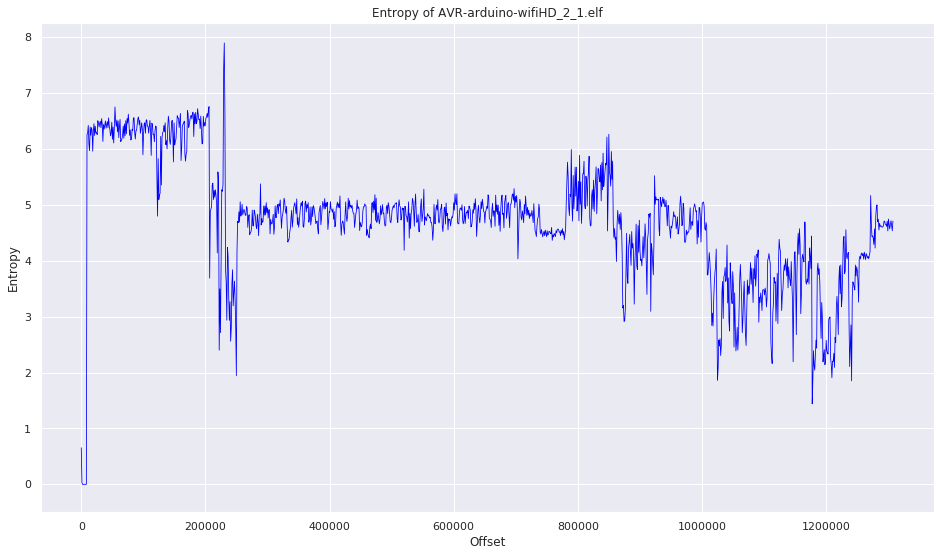

In [30]:
AVR_wifiHD.plot_file_entropy()



```
$ readelf -SW AVR-arduino-wifiHD_2_1.elf 
...

[ 3] .text             PROGBITS        80002008 002408 030564 00  AX  0   0  4
...
```

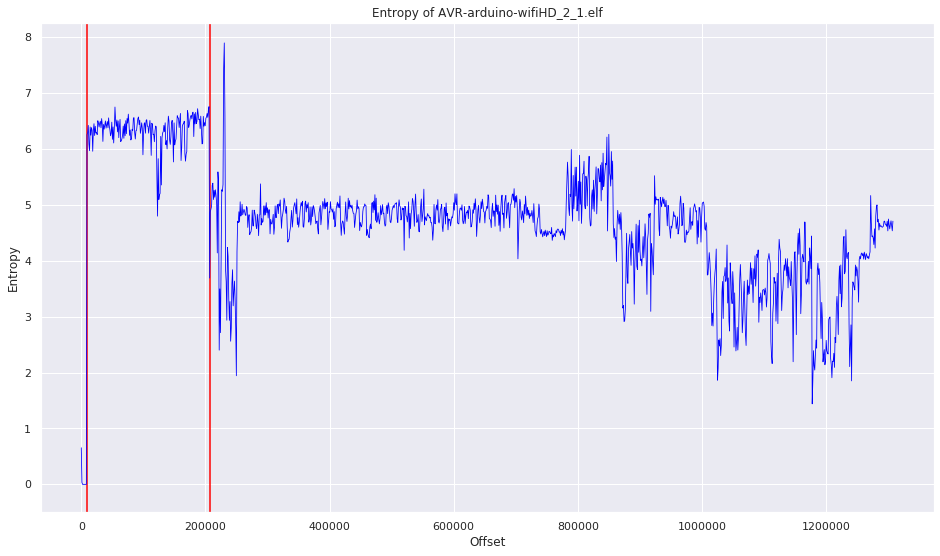

In [31]:
AVR_wifiHD.plot_file_entropy(0x002408, 0x002408 + 0x030564)

Average machine code entropy level looks a little higher here, above 6.

<h3>Clustering with DBSCAN</h3>

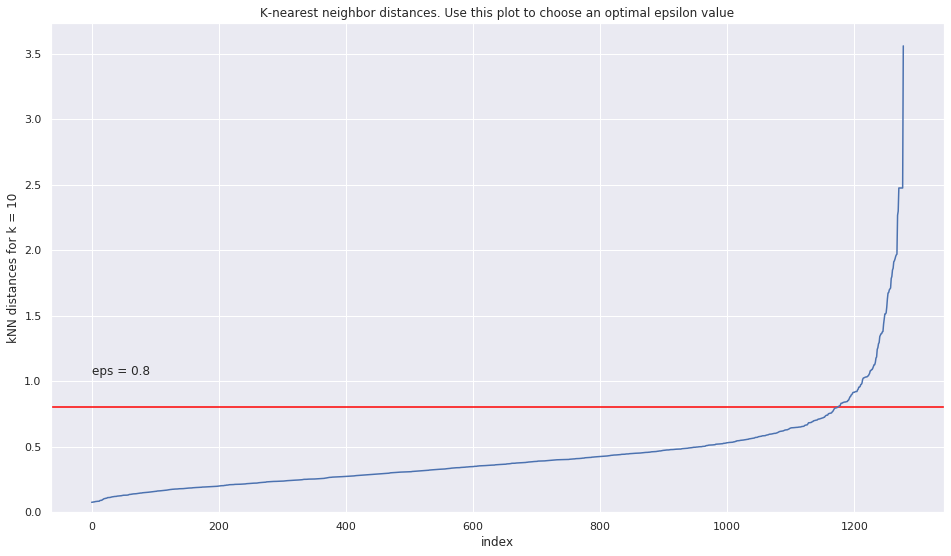

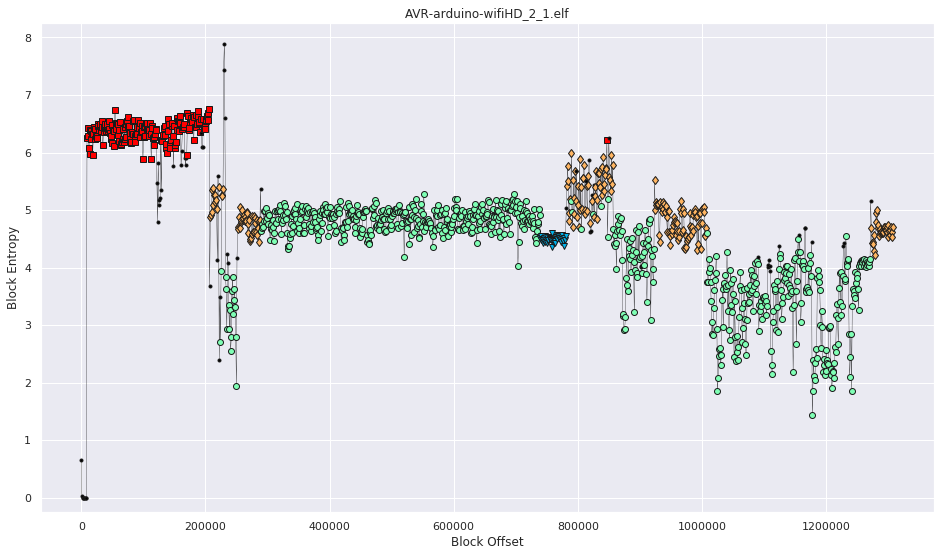

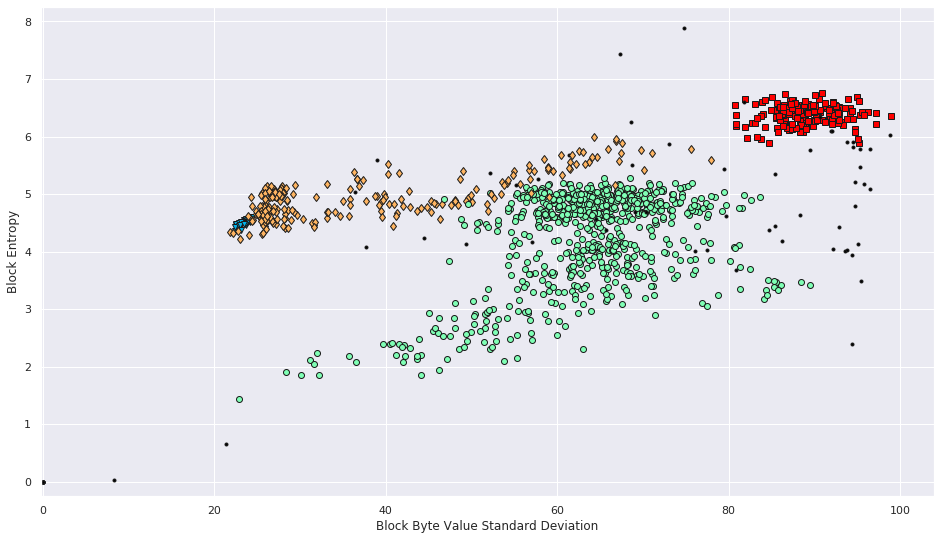

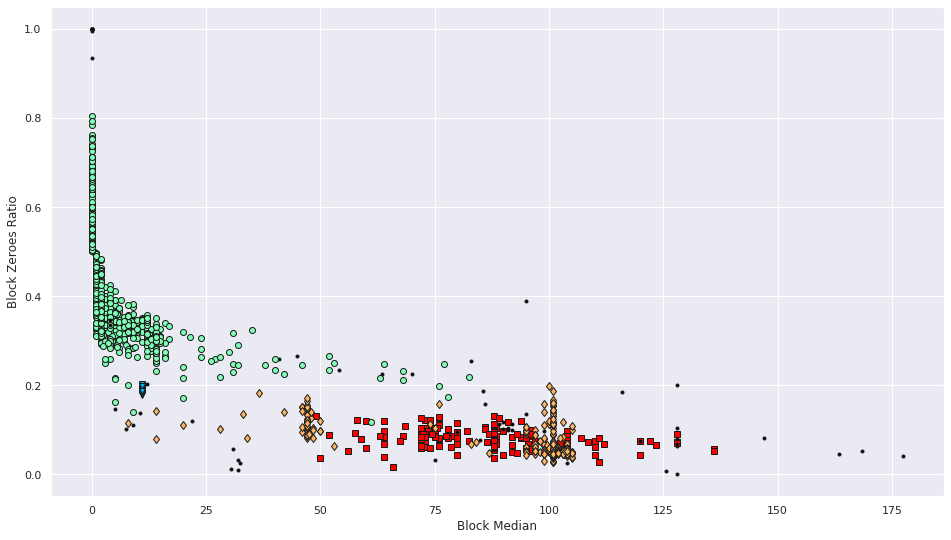

In [32]:
AVR_wifiHD.cluster_DBSCAN(0.8,                           # eps
                          10,                            # min_samples
                          find_optimal_epsilon=True)     # show "knee" plot
AVR_wifiHD.plot_DBSCAN_results()

If we wanted to distinguish between other data types with greater precision, we could decrease the `eps` value to 0.4, but for our purposes here this is not necessary since the blocks containing machine code are all assigned the same cluster label.

<h3>Univariate Analysis of Cluster Features</h3>
 
Judging from the information output by the preceding plots, cluster 0 consists of machine code.

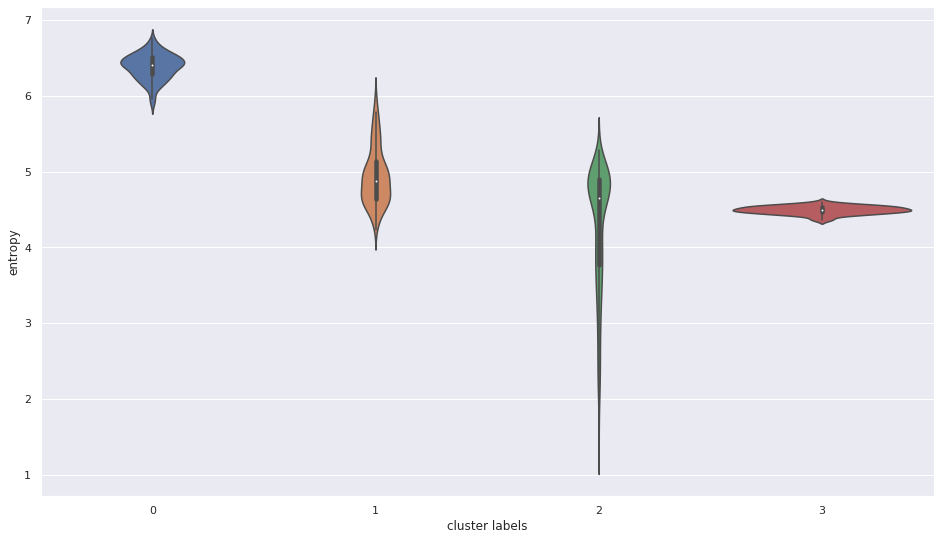

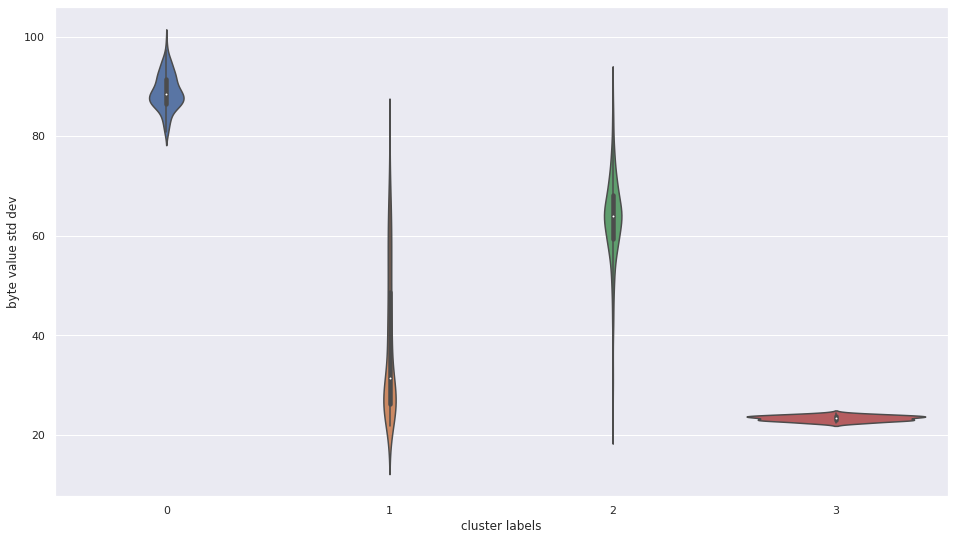

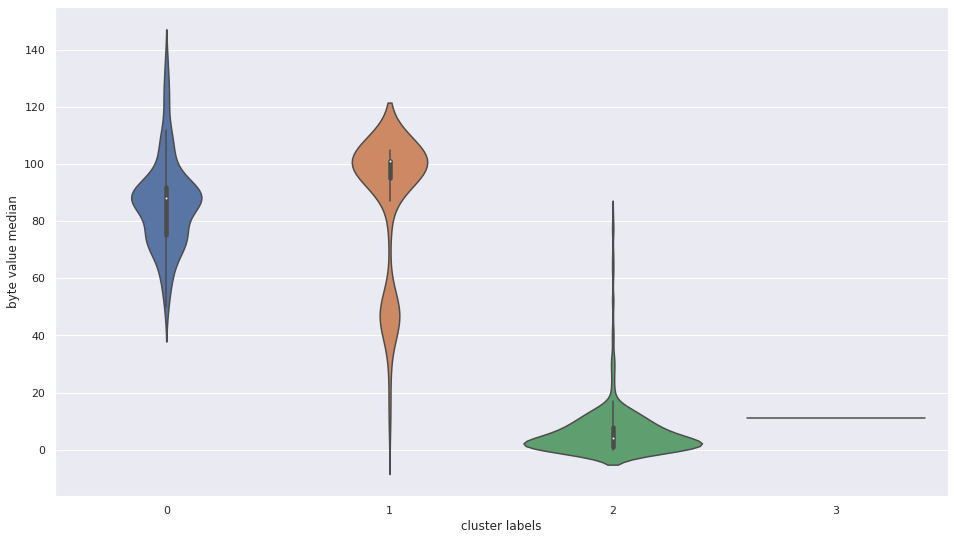

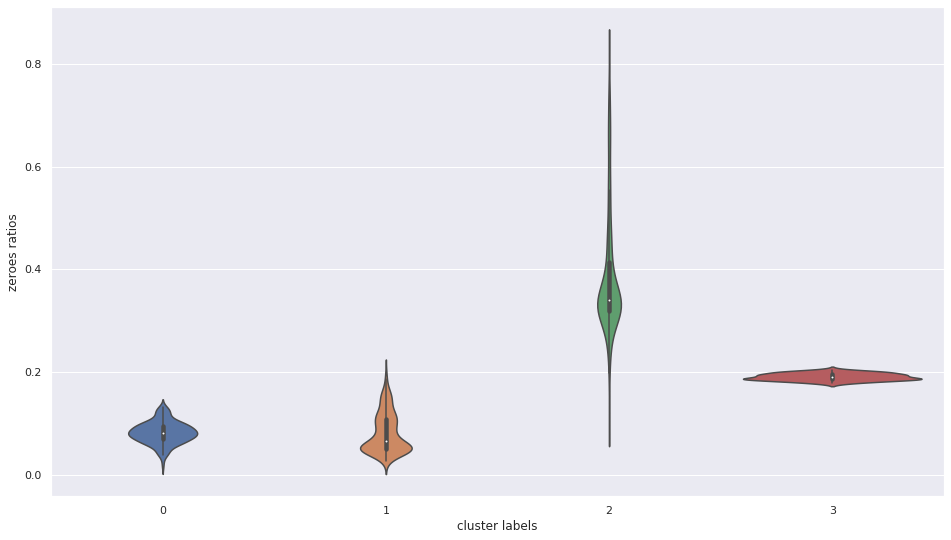

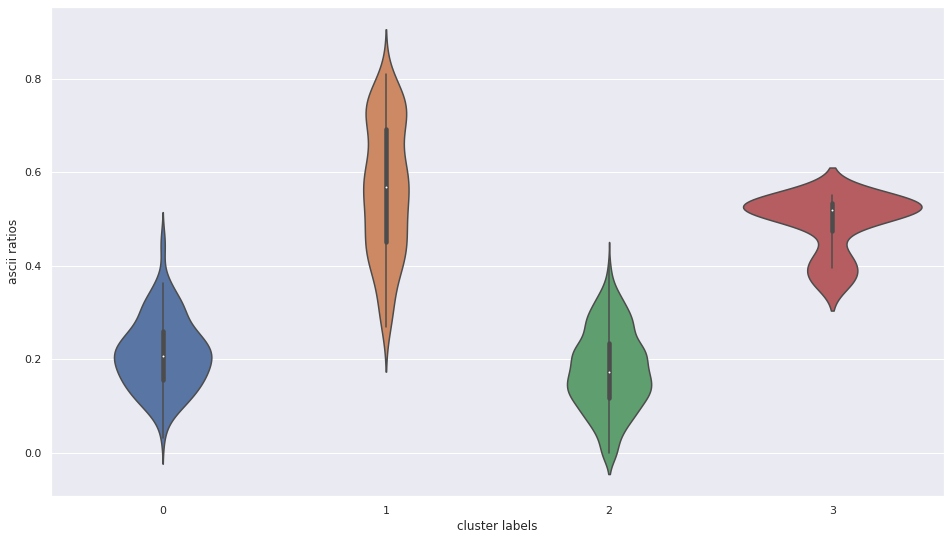

In [33]:
columns = ["entropy", "byte value std dev", "byte value median", "zeroes ratios", "ascii ratios"]
for column in columns:
    ax = sns.violinplot(x = "cluster labels", 
                        y = column,
                        data = AVR_wifiHD.dbscan_data_frame[AVR_wifiHD.dbscan_data_frame["cluster labels"] != -1]) # exclude rows with cluster label -1
    plt.show()


<h3>Cluster Byte Value Distribution Analysis</h3>

In [34]:
AVR_code_cluster = AVR_wifiHD.dbscan_data_frame[AVR_wifiHD.dbscan_data_frame["cluster labels"] == 0] # use filtering to extract cluster containing code

AVR_cluster_bytes = []
AVR_cluster_blocks = [AVR_wifiHD.blocks[i] for i in AVR_code_cluster.index]

for block in AVR_cluster_blocks:              # for each block, select the 1024 raw bytes
        AVR_cluster_bytes += block.data       # append these bytes to the list

Quick non-graphical comparison with code from x86 `readelf` and ARM64 `gpdasm`:

In [35]:
AVR_feature_means = AVR_code_cluster.drop(["core samples mask", "cluster labels"], axis=1).describe().loc["mean"]
multi_arch_df = pd.DataFrame(data={'readelf (x86)': readelf_feature_means, 'gpdasm (ARM64)':gpdasm_feature_means, 'wifiHD (AVR)':AVR_feature_means})
multi_arch_df

readelf (x86)  gpdasm (ARM64)  wifiHD (AVR)
entropy                         5.843738        6.026331      6.386020
zeroes ratios                   0.114274        0.126363      0.082174
ascii ratios                    0.297686        0.204578      0.211755
byte value std dev             87.770597       88.467059     88.934323
byte value counts std dev      11.622925       10.726670      8.438990
byte value mean               114.385940      100.342251    104.786166
byte value median             113.847107       82.302326     86.084270

 - The entropy levels and byte value standard deviations are fairly consistent across architectures
 - There are clear differences in byte value means and medians.

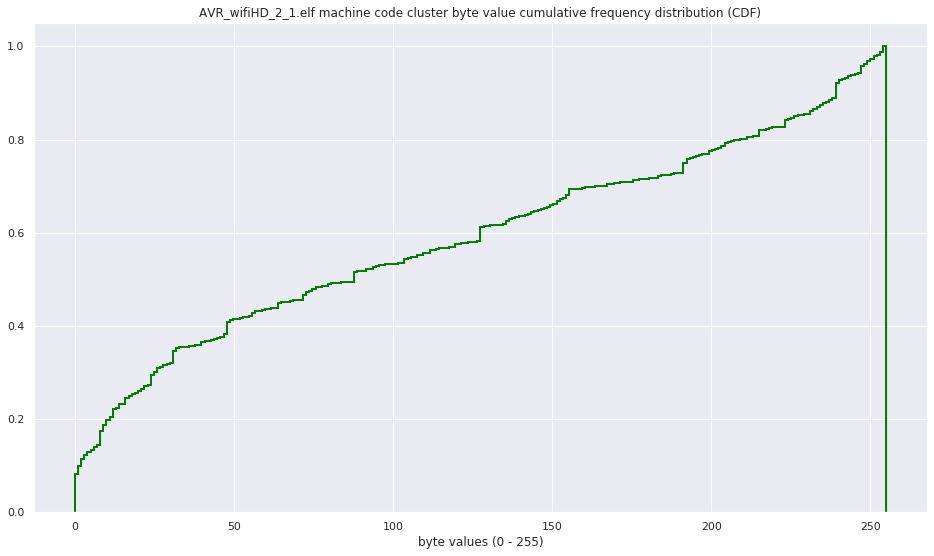

In [36]:
# create CDF
ax = sns.distplot(list(AVR_cluster_bytes),
                  norm_hist=True,     # normalize the y-axis. Different clusters have different numbers of blocks.
                  kde=False,
                  hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':2, 'alpha':1},
                  kde_kws={'cumulative': True},  # want CDF
                  bins=256,                      # 1 bin per byte value. Maximum granularity
                  color="green")
ax.set_title("AVR_wifiHD_2_1.elf machine code cluster byte value cumulative frequency distribution (CDF)")
ax.set_xlabel("byte values (0 - 255)")
plt.show()

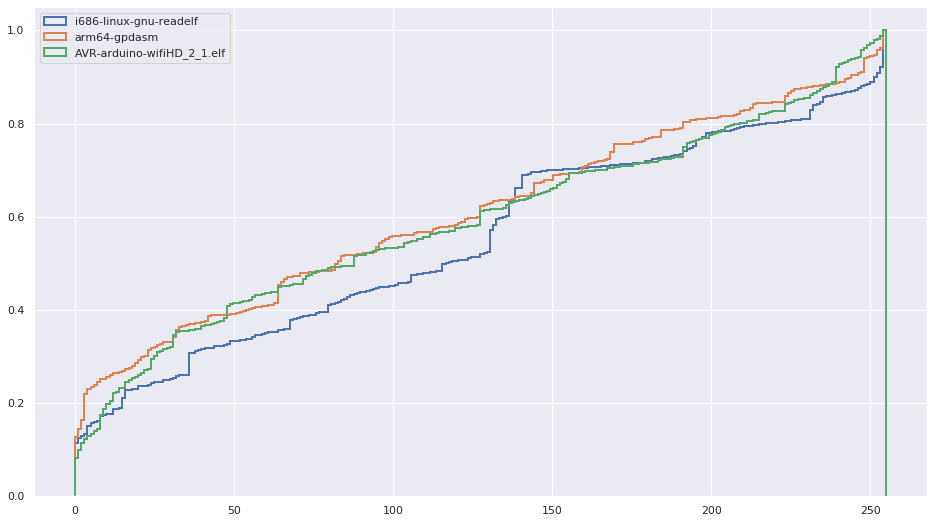

In [37]:
plot_cdfs([readelf_cluster_bytes, gpdasm_cluster_bytes, AVR_cluster_bytes], 
          ["i686-linux-gnu-readelf","arm64-gpdasm", "AVR-arduino-wifiHD_2_1.elf"])

ARM64 code and AVR code extracted here seem to have quite similar byte value distributions.

In [38]:
file_handle.close()

This concludes our analysis of ELF binaries.

<hr>

<h1>Firmware</h1>

One of the main differences between firmware files and ELF executables is the absence of a common format. In ELF or PE files, a variety of metadata is available in headers or tables embedded in the file describing its layout, content, target architecture, etc. This kind of metadata is often not available in firmware binaries. In addition to this, while ELF and PE files are designed to be parsed by the OS loader and then mapped into virtual memory, firmware may be a binary blob intended to run on bare metal; it depends on the target device's hardware and OS. In sum, whereas information layout in ELF binaries conforms to a common format, this is not the case with firmware and as a result firmware file structure is much more heterogeneous. Practically, this is a concern when reverse engineering firmware files because there is no header field specifying the target CPU of the code and nothing to indicate where in the file the machine code resides. Fortunately, there are ways to overcome these challenges, some of which will be demonstrated here.
    
<h2>4. P2261_v3.48.bin (MIPS)</h2>
    
This is firmware for the DrayTek P2261 switch (VigorSwitch-P2261 v3.48). Once downloaded, the file will need to be unpacked by `binwalk` or similar in order to locate the firmware file. As indicated by the title of this section, the file of interest is called `P2261_v3.48.bin`. 

When we run a signature scan with `binwalk` on this file, a large amount of information is displayed (such as the target architecture of the kernel), which we will set aside for now:

```
$ binwalk P2261_v3.48.bin 

DECIMAL       HEXADECIMAL     DESCRIPTION
--------------------------------------------------------------------------------
0             0x0             eCos kernel exception handler, architecture: MIPSEL, exception vector table base address: 0x80000200
128           0x80            eCos kernel exception handler, architecture: MIPSEL, exception vector table base address: 0x80000200
5040296       0x4CE8A8        Unix path: /home/miranda/GS-23XX-AP4/t/build/obj/ecos/install/include/cyg/libc/stdlib/atox.inl
5040334       0x4CE8CE        eCos RTOS string reference: "ecos/install/include/cyg/libc/stdlib/atox.inl"
5078988       0x4D7FCC        Unix path: /usr/bin/default d %d
5164290       0x4ECD02        eCos RTOS string reference: "ecos/install/include/cyg/libc/time/time.inl"
5197421       0x4F4E6D        Neighborly text, "neighbor_cache_show"
5197449       0x4F4E89        Neighborly text, "neighbor_cache_cleartransition"
...
<output cropped>
```

<h3>File Information Visualization</h3>

The plots below show that things are a bit messier in this file compared with previously analyzed files.

In [39]:
# get things set up

file_handle = open("../files/firmware/P2261_v3.48.bin", "rb")
draytek_bin = BinFile(file_handle)

draytek_bin.set_block_size(1024)
draytek_bin.slice_file()

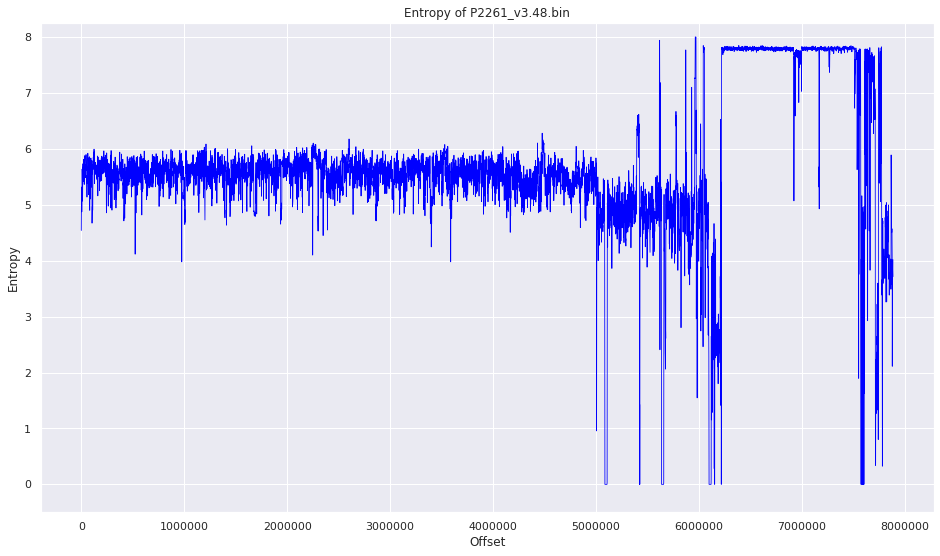

In [40]:
draytek_bin.plot_file_entropy()

In spite of the fact that there is no metadata in the file saying "the part of the file containing code is at offset X and is Y bytes in size", it is already possible to make an educated guess that the code in this file lies approximately between offsets 10000 and 5000000. In the ELF files analyzed above, machine code had an entropy level around 6 regardless of architecture, so exptrapolating from that we can guess that this is also the case here.

In addition, there is a large region of high entropy towards the end of the file. This is what compressed data looks like on an entropy plot. Let us look at some features other than entropy:

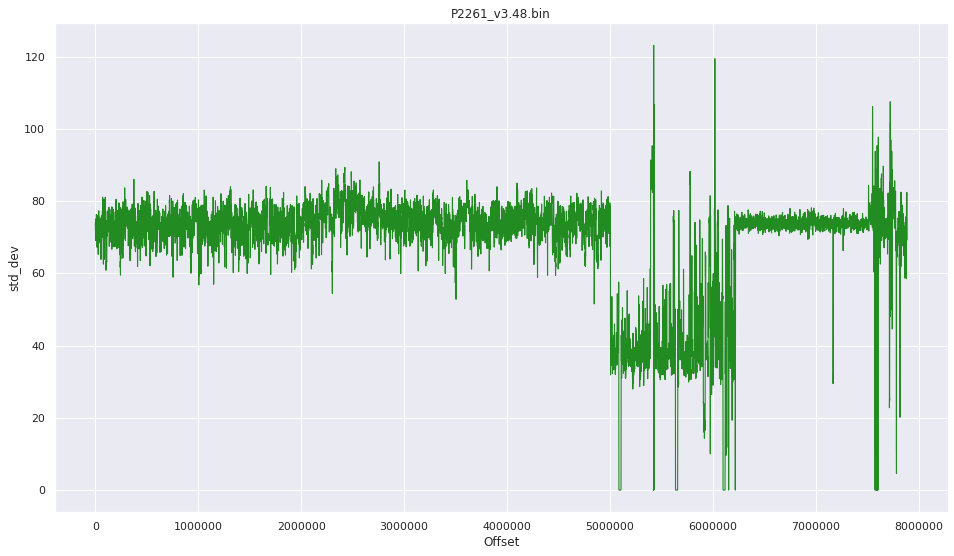

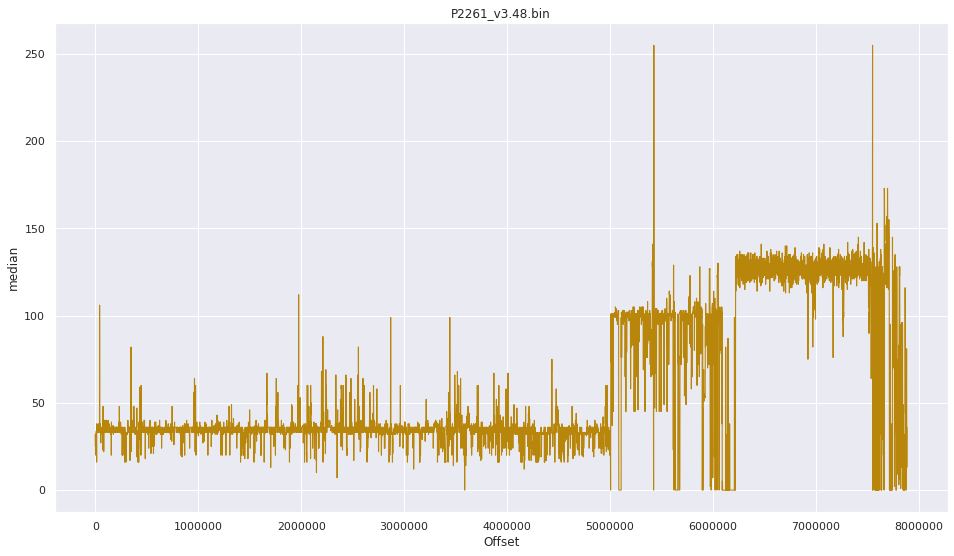

In [41]:
draytek_bin.plot_file_feature("std_dev", "forestgreen")
draytek_bin.plot_file_feature("median", "darkgoldenrod")

Looking at the plots above, it looks like there are 3 main groups of different types of information. The 2 plots above show this more clearly than the entropy plot.

Let us also plot these two variables (block median and block standard deviation) against each other, coloring the points representing blocks between offsets 10000 and 5000000 red:

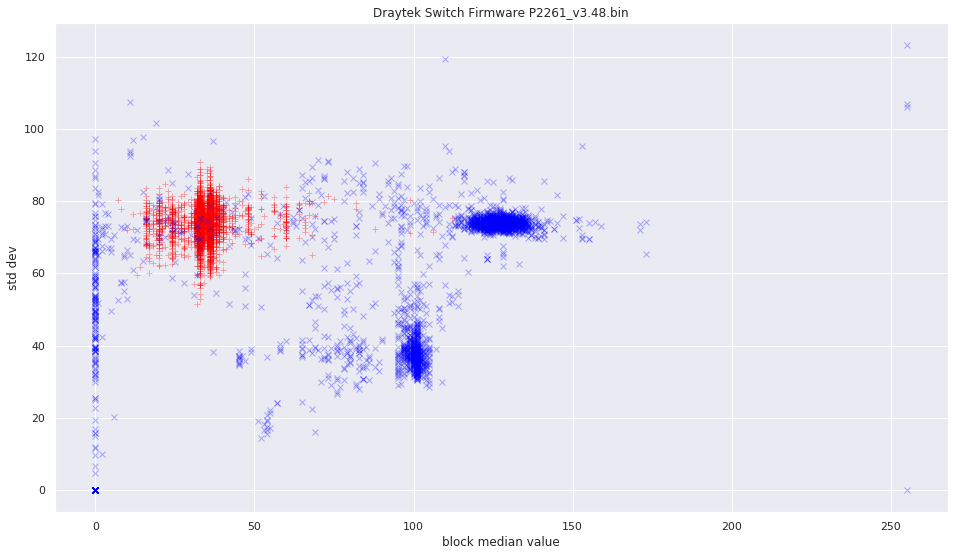

In [42]:
draytek_bin.plot_variables_by_range(draytek_bin.block_byteval_median,          # 1st variable
                                    draytek_bin.block_byteval_std_dev,         # 2nd variable
                                    10000,                                     # start file offset (e.g start of .text section)
                                    5000000,                                   # end file offset
                                    target_data_marker='+',                    # marker shape for points that fall within the specified offsets
                                    other_data_marker='x',                     # marker for points outside of offsets
                                    target_data_color='red',                   # color of points inside offsets
                                    other_data_color='blue',                   # color of points outside offsets
                                    title='Draytek Switch Firmware P2261_v3.48.bin',   
                                    xlabel='block median value',
                                    ylabel='std dev')

We can also plot entropy against the means:

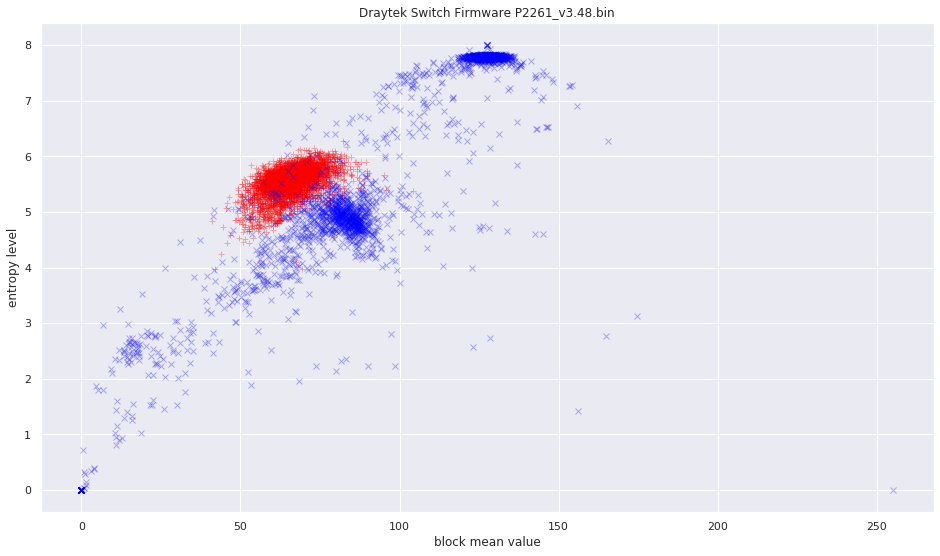

In [43]:
draytek_bin.plot_variables_by_range(draytek_bin.block_byteval_mean,            # 1st variable
                                    draytek_bin.block_entropy_levels,          # 2nd variable
                                    10000,                                     # start file offset (e.g start of .text section)
                                    5000000,                                   # end file offset
                                    target_data_marker='+',                    # marker shape for points that fall within the specified offsets
                                    other_data_marker='x',                     # marker for points outside of offsets
                                    target_data_color='red',                   # color of points inside offsets
                                    other_data_color='blue',                  # color of points outside offsets
                                    title='Draytek Switch Firmware P2261_v3.48.bin',   
                                    xlabel='block mean value',
                                    ylabel='entropy level')

<h3>Clustering with DBSCAN</h3>

Since the file is quite large (7.6 M), it is helpful to increase `minimum_samples` from the usual 10 to 50 or even 100. Decreasing `epsilon` from 1 to 0.6 also ensures better seperation between clusters and less noise blocks being assigned a cluster label. 

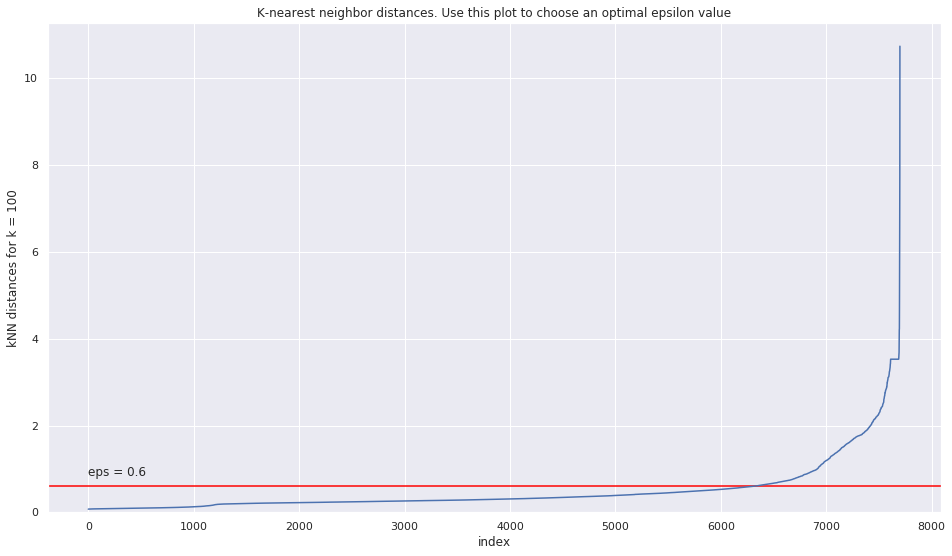

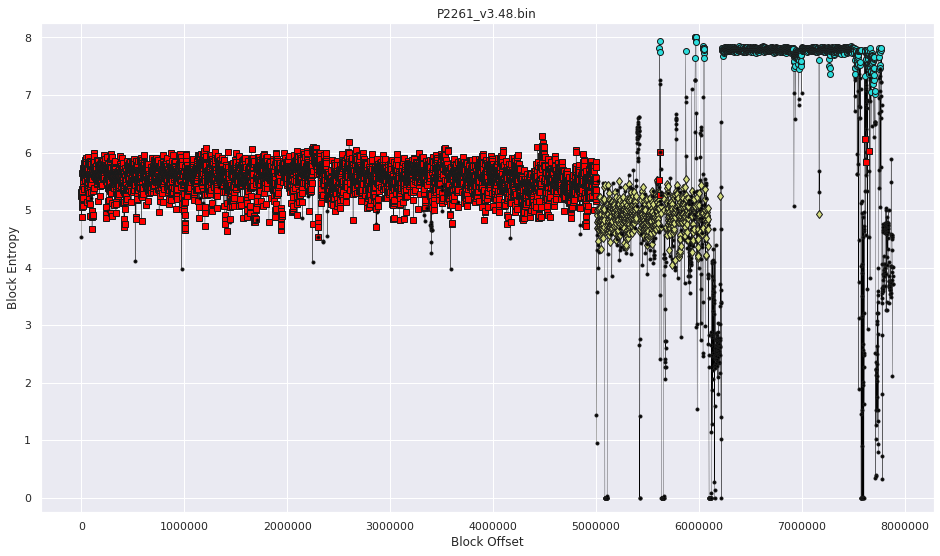

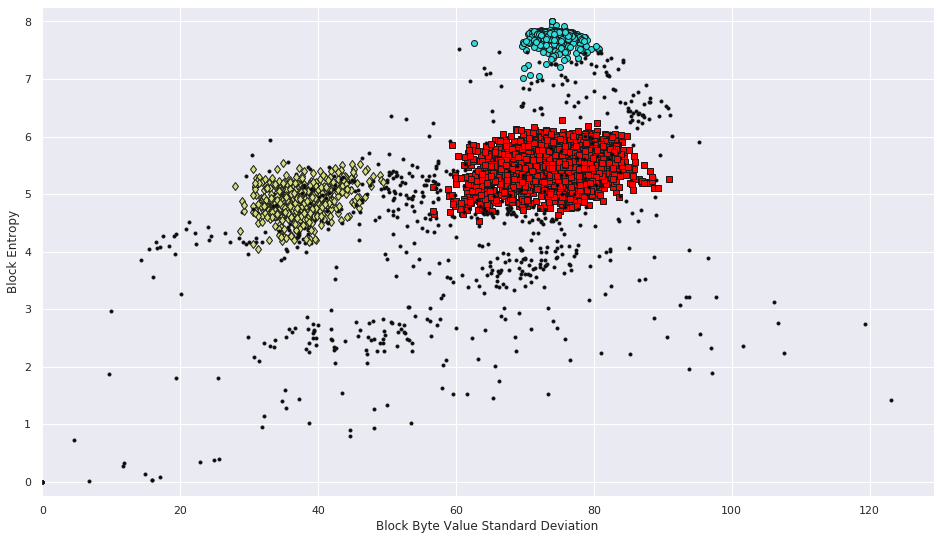

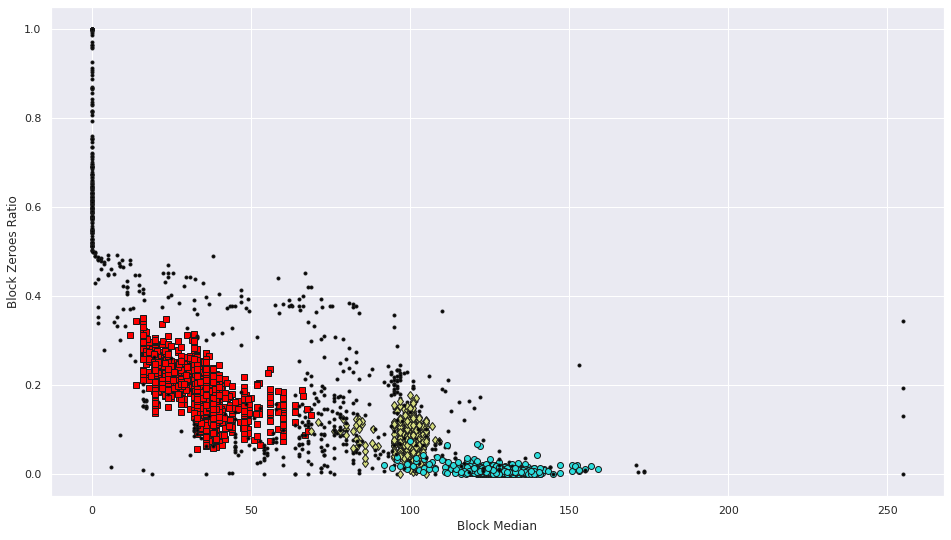

In [44]:
draytek_bin.cluster_DBSCAN(epsilon=0.6,
                           minimum_samples=100,
                           find_optimal_epsilon=True)
draytek_bin.plot_DBSCAN_results()

<h3>Cluster Byte Value Distribution Analysis</h3>

Judging by what has been observed so far, cluster 0 looks to be the one containing machine code.

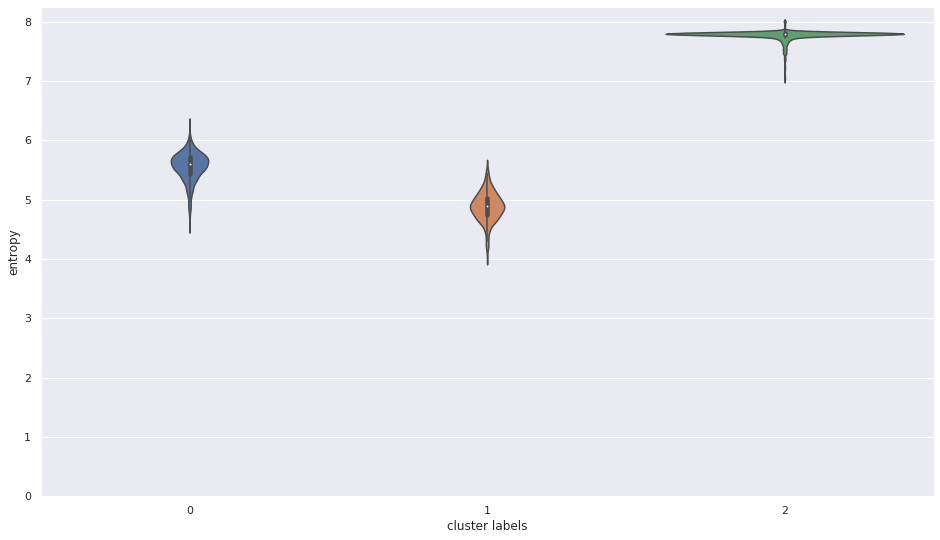

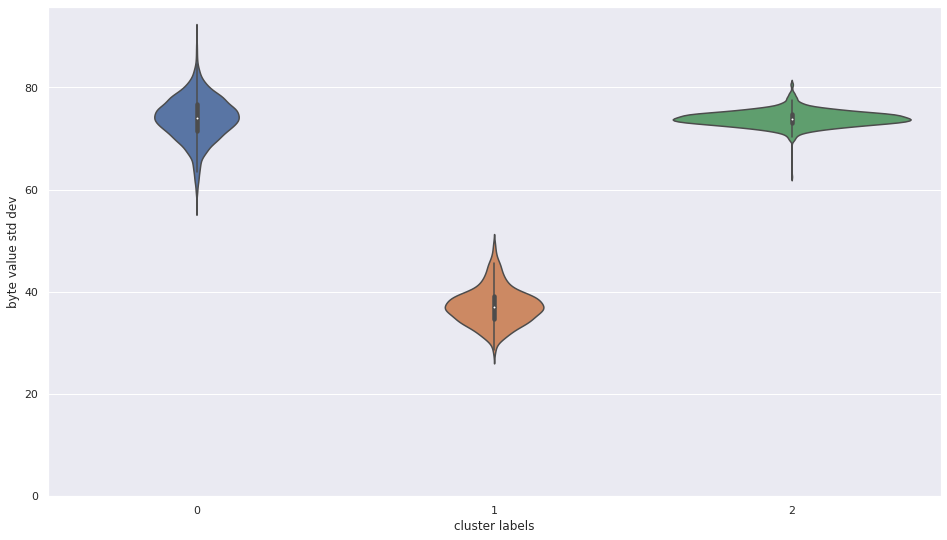

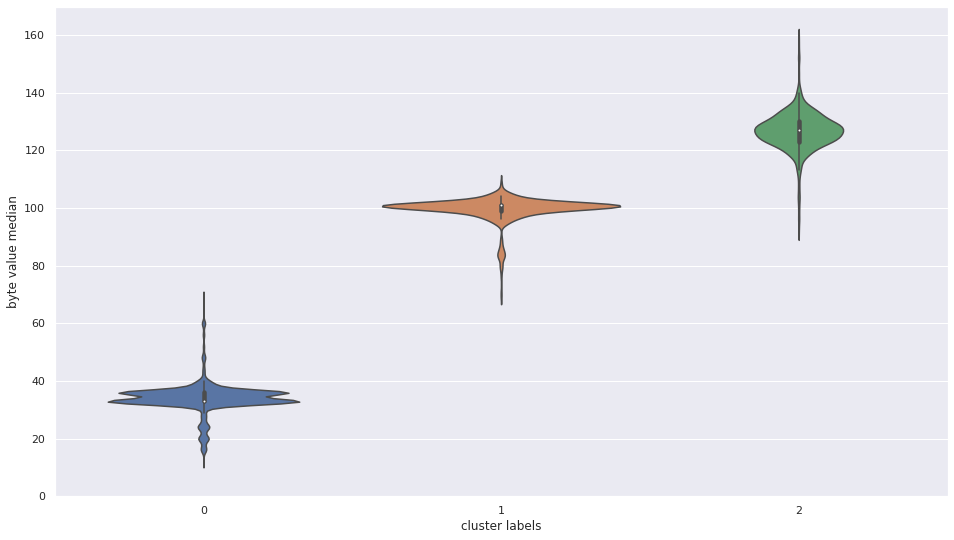

In [249]:
columns = ["entropy", "byte value std dev", "byte value median"]
for column in columns:
    ax = sns.violinplot(x = "cluster labels", 
                        y = column,
                        data = draytek_bin.dbscan_data_frame[draytek_bin.dbscan_data_frame["cluster labels"] != -1]) # exclude rows with cluster label -1
    ax.set_ylim(0)
    plt.show()

<h3>Cluster Byte Value Distribution Analysis</h3>

Let's extract all the bytes in cluster 0 and see how this cluster compares with those containing x86, ARM64, and AVR code from earlier.

In [46]:
draytek_code_cluster = draytek_bin.dbscan_data_frame[draytek_bin.dbscan_data_frame["cluster labels"] == 0] # use filtering to extract cluster containing code

draytek_cluster_bytes = []
draytek_cluster_blocks = [draytek_bin.blocks[i] for i in draytek_code_cluster.index]

for block in draytek_cluster_blocks:              # for each block, select the 1024 raw bytes
        draytek_cluster_bytes += block.data       # append these bytes to the list

In [47]:
draytek_feature_means = draytek_code_cluster.drop(["core samples mask", "cluster labels"], axis=1).describe().loc["mean"]
multi_arch_df['draytek (MIPS)'] = draytek_feature_means 
multi_arch_df

readelf (x86)  gpdasm (ARM64)  wifiHD (AVR)  \
entropy                         5.843738        6.026331      6.386020   
zeroes ratios                   0.114274        0.126363      0.082174   
ascii ratios                    0.297686        0.204578      0.211755   
byte value std dev             87.770597       88.467059     88.934323   
byte value counts std dev      11.622925       10.726670      8.438990   
byte value mean               114.385940      100.342251    104.786166   
byte value median             113.847107       82.302326     86.084270   

                           draytek (MIPS)  
entropy                          5.560909  
zeroes ratios                    0.185356  
ascii ratios                     0.200661  
byte value std dev              73.936199  
byte value counts std dev       14.002901  
byte value mean                 65.847963  
byte value median               34.058200

Many of the features of the code in the Draytek switch firmware are markedly different from what we have observed so far. Let us plot the CDFs of these different clusters.

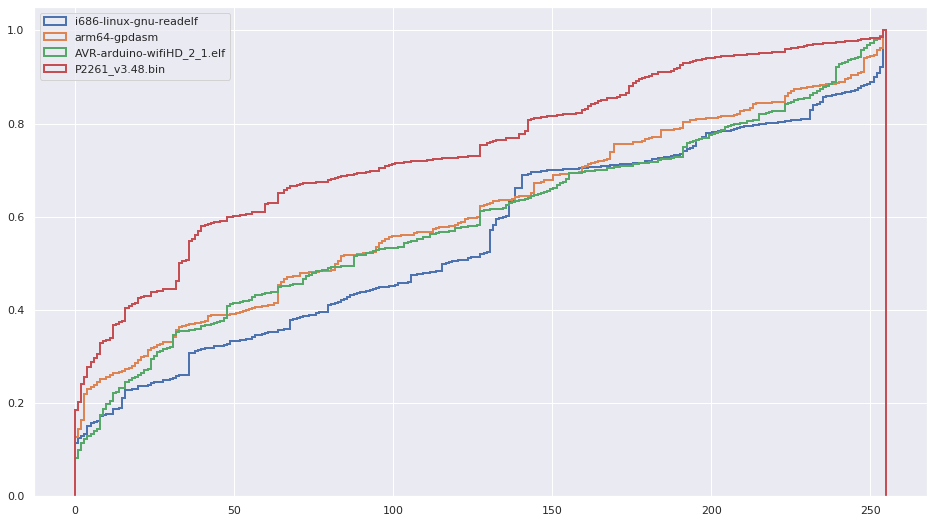

In [48]:
plot_cdfs([readelf_cluster_bytes, gpdasm_cluster_bytes, AVR_cluster_bytes, draytek_cluster_bytes], 
          ["i686-linux-gnu-readelf","arm64-gpdasm", "AVR-arduino-wifiHD_2_1.elf", "P2261_v3.48.bin"])

The CDF of the byte values of the machine code extracted from the Draytek switch firmware sticks out like a sore thumb. Very cool.

In [49]:
file_handle.close()

<h2>5. FW_CM170_1.1.04_2249_FSI.img (Xtensa)</h2>

Up next is some firmware for a Flanders Scientific monitor. Once downloaded and unzipped, a `binwalk` signature scan indicates the target architecture may be Xtensa or contain x86 or x64 microcode:

```
$ binwalk FW_CM170_1.1.04_2249_FSI.img

DECIMAL       HEXADECIMAL     DESCRIPTION
--------------------------------------------------------------------------------
2880505       0x2BF3F9        Copyright string: "Copyright MGC 2004 - Nucleus PLUS - T1040/50 Xtensa v. 1.14"
3313563       0x328F9B        Intel x86 or x64 microcode, sig 0x00000040, pf_mask 0x00, 2000-02-10, rev 0x410000, size 2048
```
Are these false positives? Let us investigate!

<h3>File Information Visualization</h3>

In [50]:
file_handle = open("../files/firmware/FW_CM170_1.1.04_2249_FSI.img", "rb")
flanders_img = BinFile(file_handle)

flanders_img.set_block_size(SIZE)
flanders_img.slice_file()

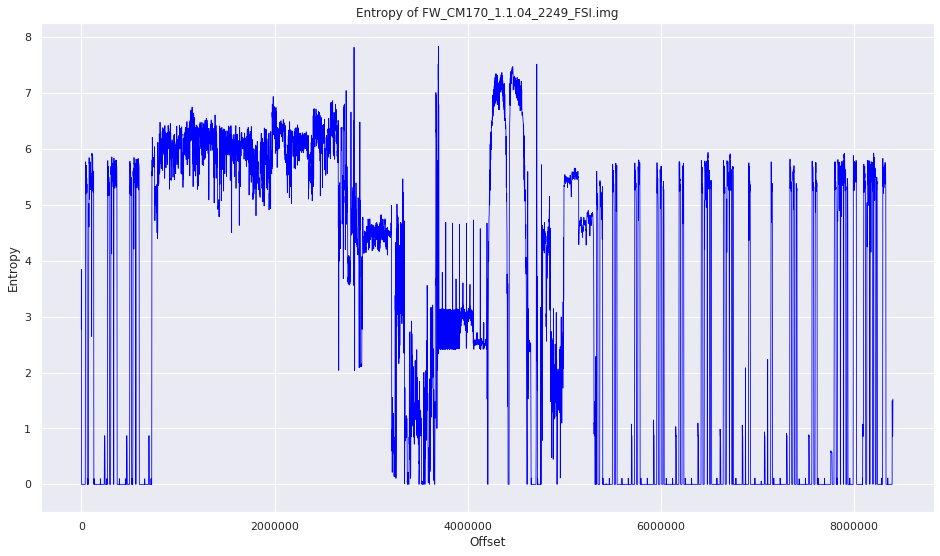

In [51]:
flanders_img.plot_file_entropy()

The structure of this file looks very interesting. More visualizations of the information therein might reveal more.

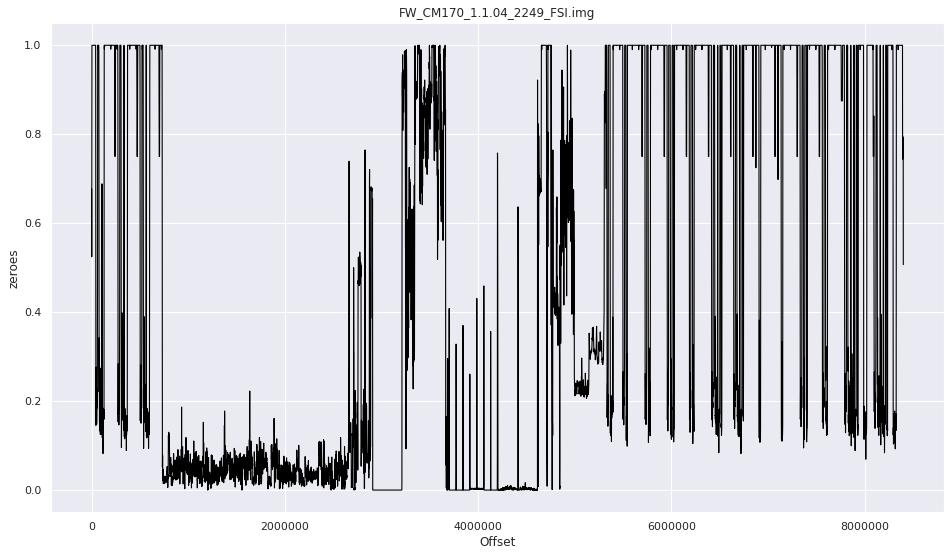

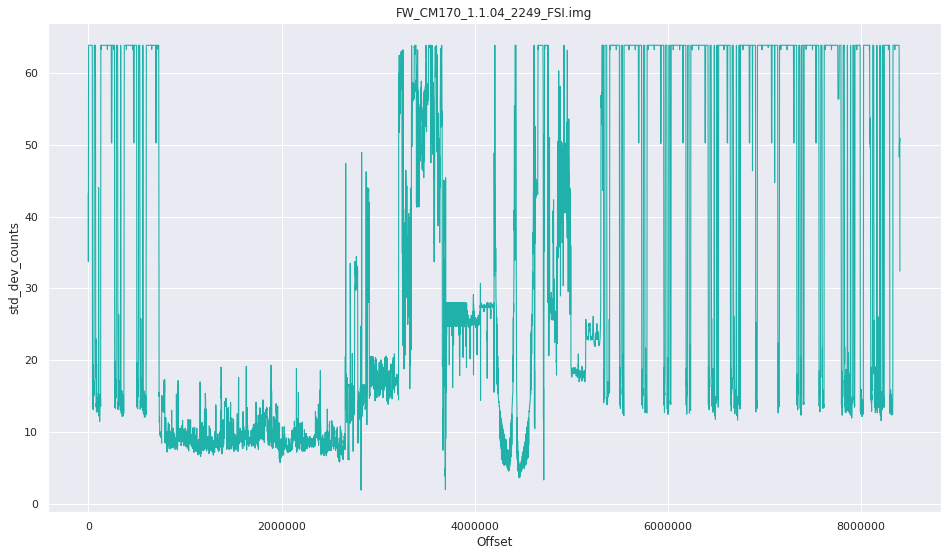

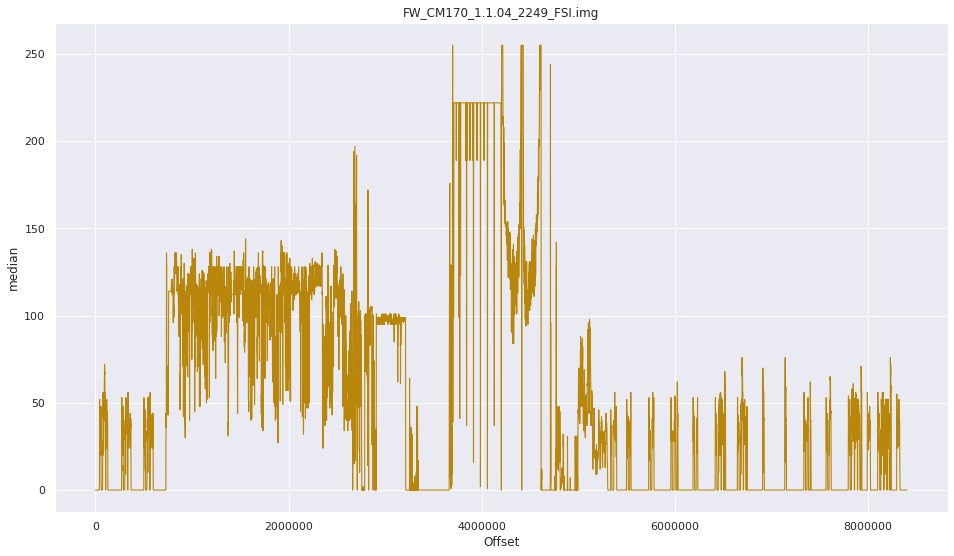

In [52]:
flanders_img.plot_file_feature("zeroes", "black")
flanders_img.plot_file_feature("std_dev_counts", "lightseagreen")
flanders_img.plot_file_feature("median", "darkgoldenrod")

The region between ~8000000 and ~25000000 stands out. Let's demarcate this area.

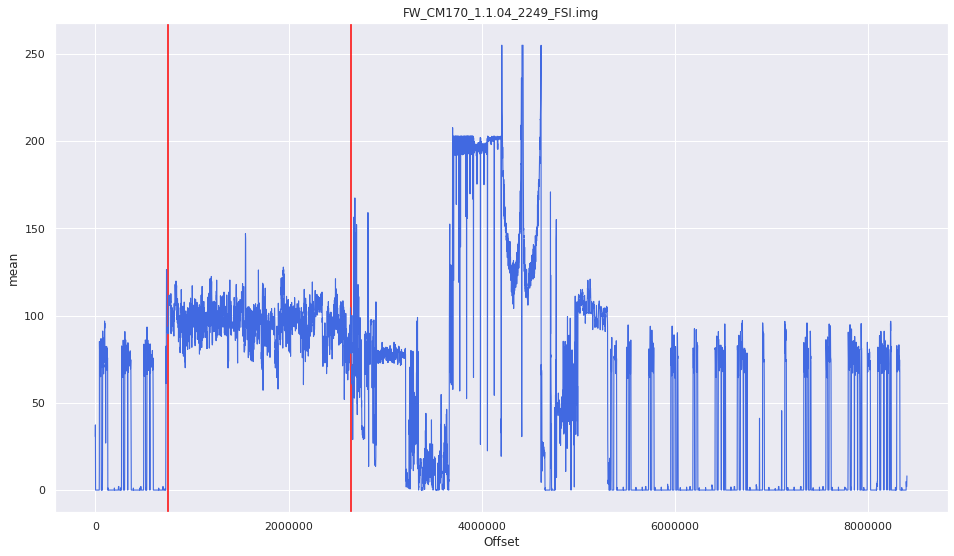

In [53]:
flanders_img.plot_file_feature("mean", "royalblue", 750000, 2650000)

We can also examine a bivariate plot (standard deviation vs. entropy level):

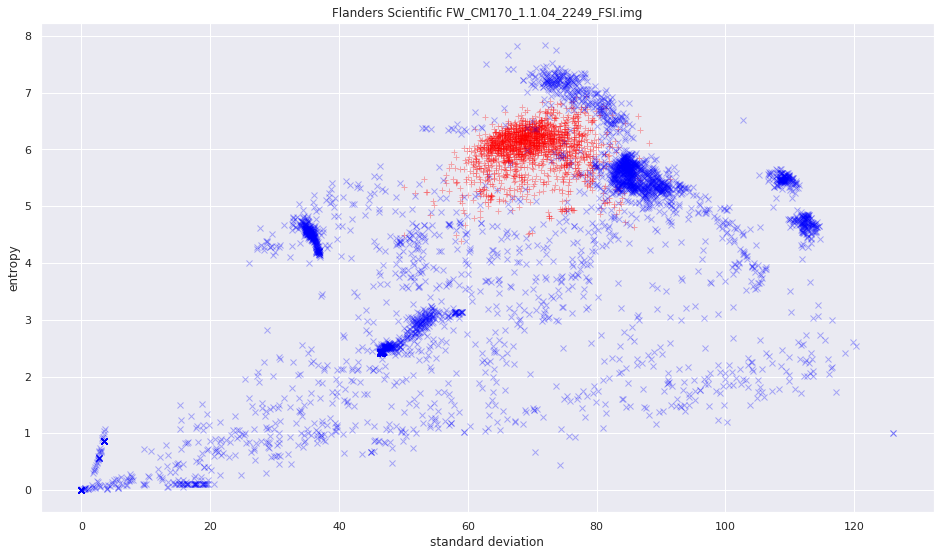

In [54]:
flanders_img.plot_variables_by_range(flanders_img.block_byteval_std_dev,          # 1st variable
                                     flanders_img.block_entropy_levels,         # 2nd variable
                                     750000,                                     # start file offset (e.g start of .text section)
                                     2650000,                                   # end file offset
                                     target_data_marker='+',                    # marker shape for points that fall within the specified offsets
                                     other_data_marker='x',                     # marker for points outside of offsets
                                     target_data_color='red',                   # color of points inside offsets
                                     other_data_color='blue',                   # color of points outside offsets
                                     title='Flanders Scientific FW_CM170_1.1.04_2249_FSI.img',   
                                     xlabel='standard deviation',
                                     ylabel='entropy')

Several clusters emerge, along with a great deal of noise. Let's see what DBSCAN can do.

<h3>Clustering with DBSCAN</h3>

This file is 8.1 megabytes in size, so a small value for `epsilon` and a large value for `minimum_size` will be used.

This was a tough one to get just right and took some fiddling. 
 - `epsilon`=0.3 and `minimum_samples`=100 captures most clusters of note
 - `epsilon`=0.2 and `minimum_samples`=100 also works, but misses some clusters

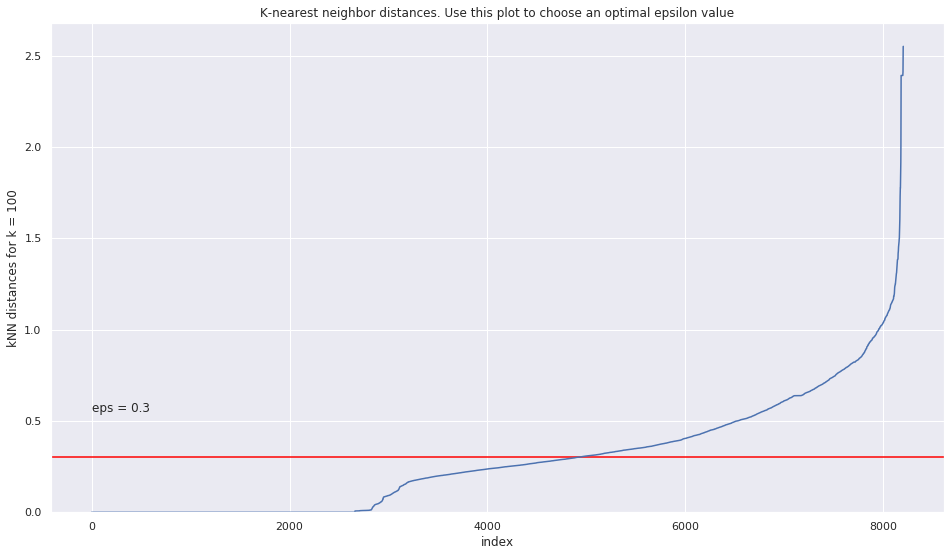

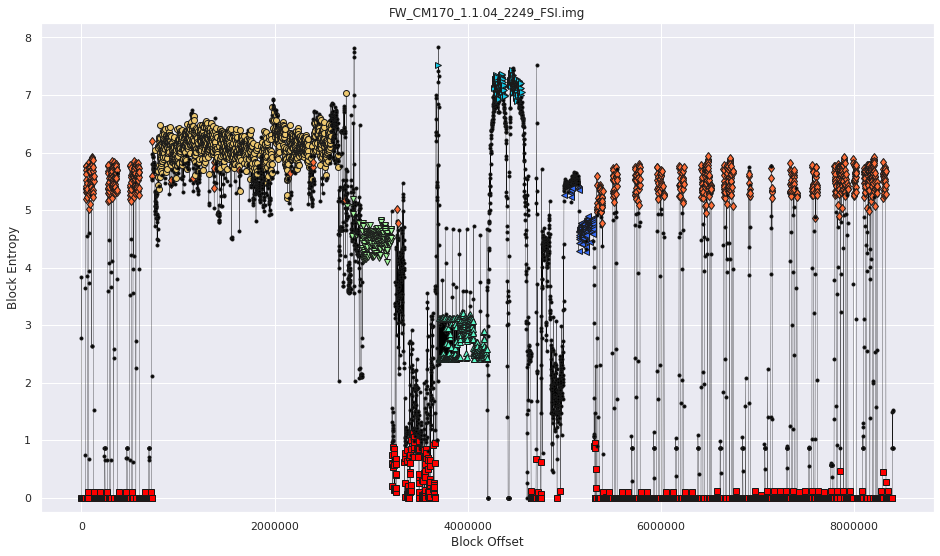

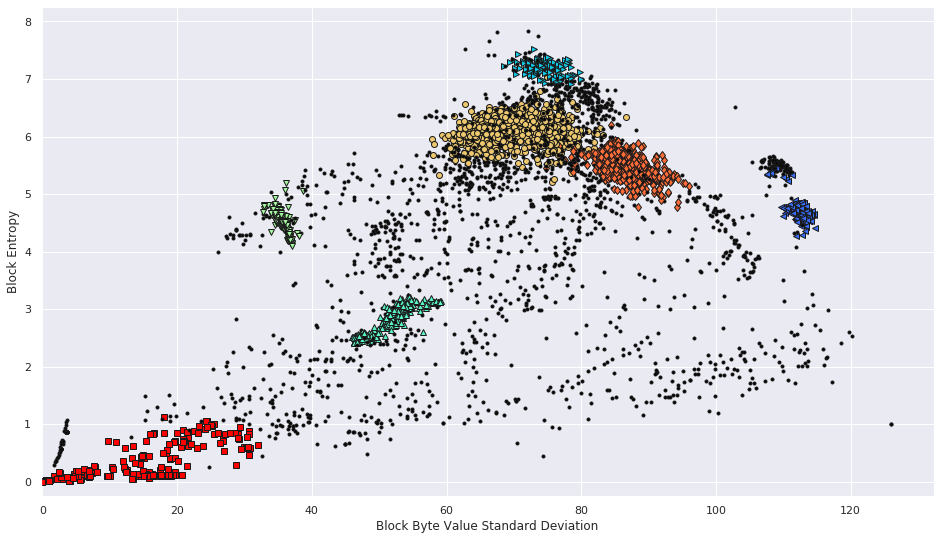

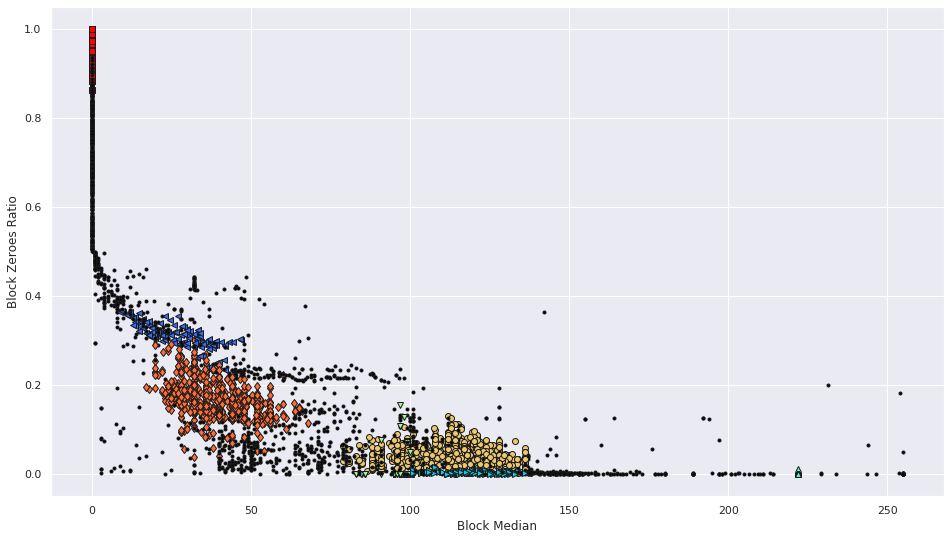

In [55]:
flanders_img.cluster_DBSCAN(epsilon=0.3,
                            minimum_samples=100,
                            find_optimal_epsilon=True)
flanders_img.plot_DBSCAN_results()

<h3>Cluster Byte Value Distribution Analysis</h3>

Based on the observations made up to this point, it appears that cluster 2 consists of machine code:
 - average block entropy: ~6
 - average byte value counts std dev: ~10
 - average block mean: ~100

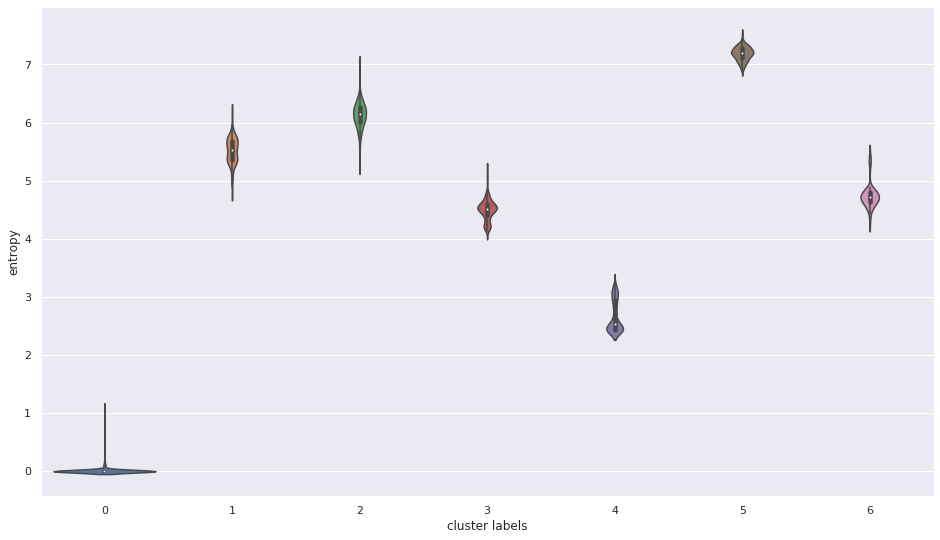

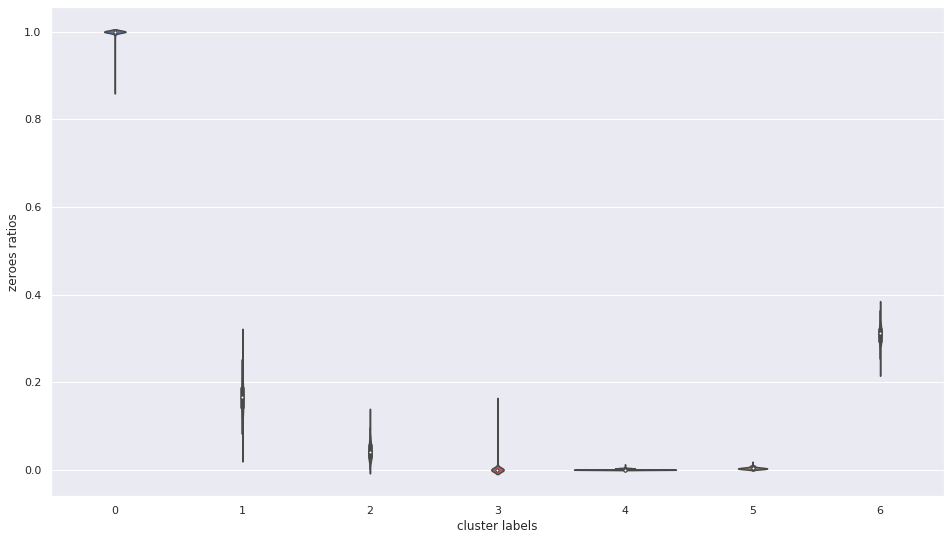

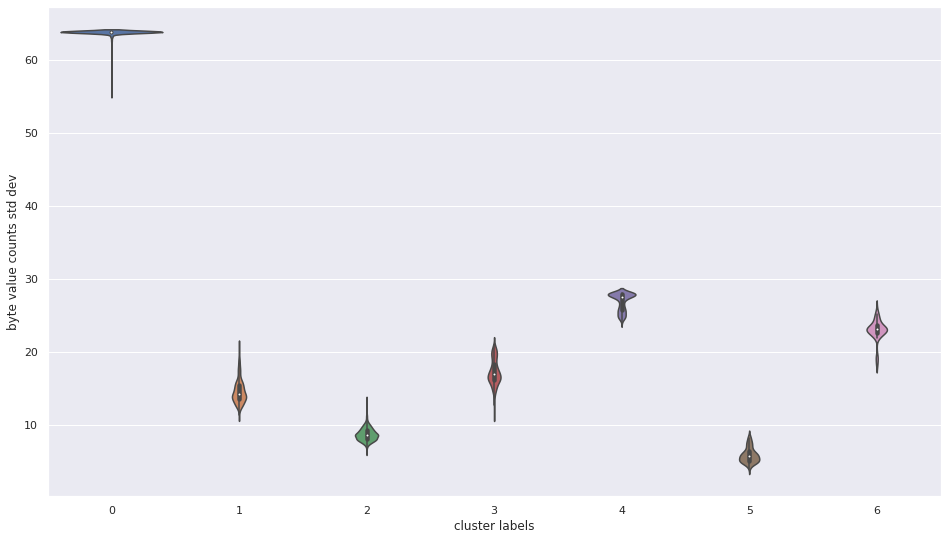

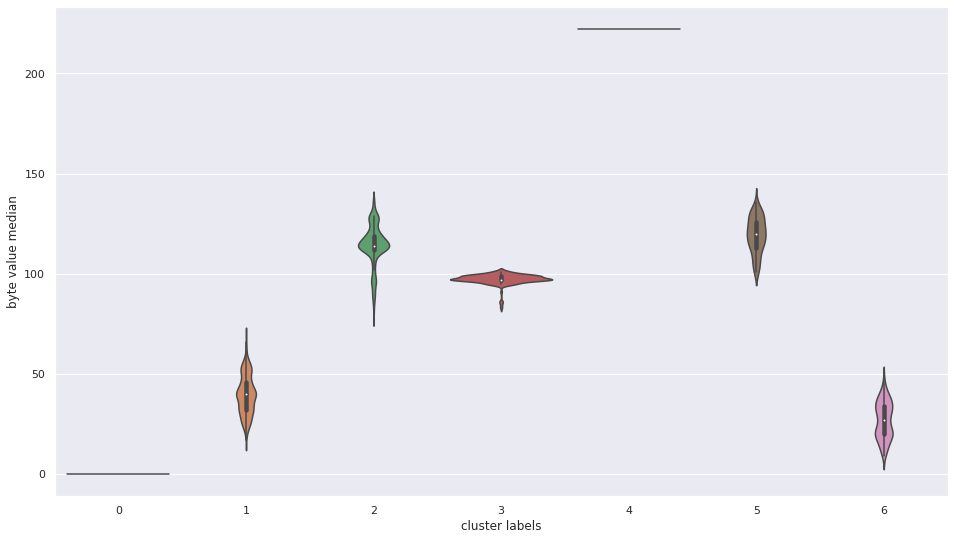

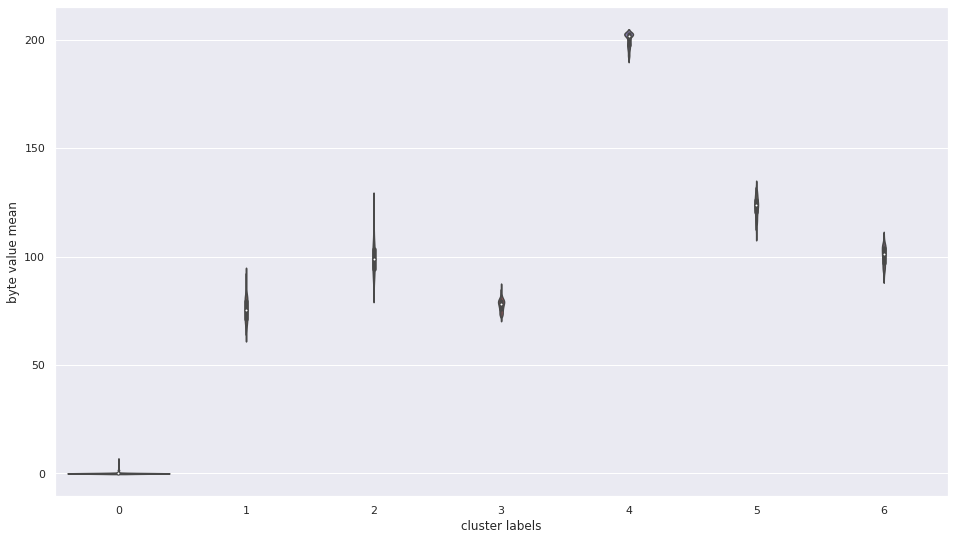

In [56]:
columns = ["entropy", "zeroes ratios", "byte value counts std dev", "byte value median", "byte value mean"]
for column in columns:
    ax = sns.violinplot(x = "cluster labels", 
                        y = column,
                        data = flanders_img.dbscan_data_frame[flanders_img.dbscan_data_frame["cluster labels"] != -1]) # exclude rows with cluster label -1
    plt.show()

<h3>Cluster Byte Value Distribution Analysis</h3>

In [57]:
flanders_code_cluster = flanders_img.dbscan_data_frame[flanders_img.dbscan_data_frame["cluster labels"] == 2] # use filtering to extract cluster containing code

flanders_cluster_bytes = []
flanders_cluster_blocks = [flanders_img.blocks[i] for i in flanders_code_cluster.index]

for block in flanders_cluster_blocks:              # for each block, select the 1024 raw bytes
        flanders_cluster_bytes += block.data       # append these bytes to the list

In [58]:
flanders_feature_means = flanders_code_cluster.drop(["core samples mask", "cluster labels"], axis=1).describe().loc["mean"]
multi_arch_df["flanders (Xtensa?)"] = flanders_feature_means
multi_arch_df

readelf (x86)  gpdasm (ARM64)  wifiHD (AVR)  \
entropy                         5.843738        6.026331      6.386020   
zeroes ratios                   0.114274        0.126363      0.082174   
ascii ratios                    0.297686        0.204578      0.211755   
byte value std dev             87.770597       88.467059     88.934323   
byte value counts std dev      11.622925       10.726670      8.438990   
byte value mean               114.385940      100.342251    104.786166   
byte value median             113.847107       82.302326     86.084270   

                           draytek (MIPS)  flanders (Xtensa?)  
entropy                          5.560909            6.128258  
zeroes ratios                    0.185356            0.043421  
ascii ratios                     0.200661            0.268184  
byte value std dev              73.936199           69.595915  
byte value counts std dev       14.002901            8.661449  
byte value mean                 65.847963           99.037991  
byte value median               34.058200          114.306947

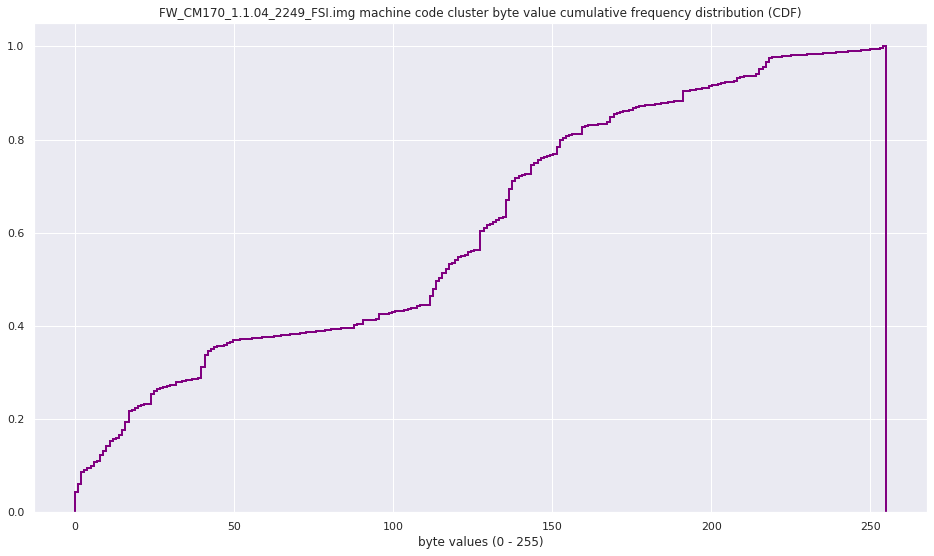

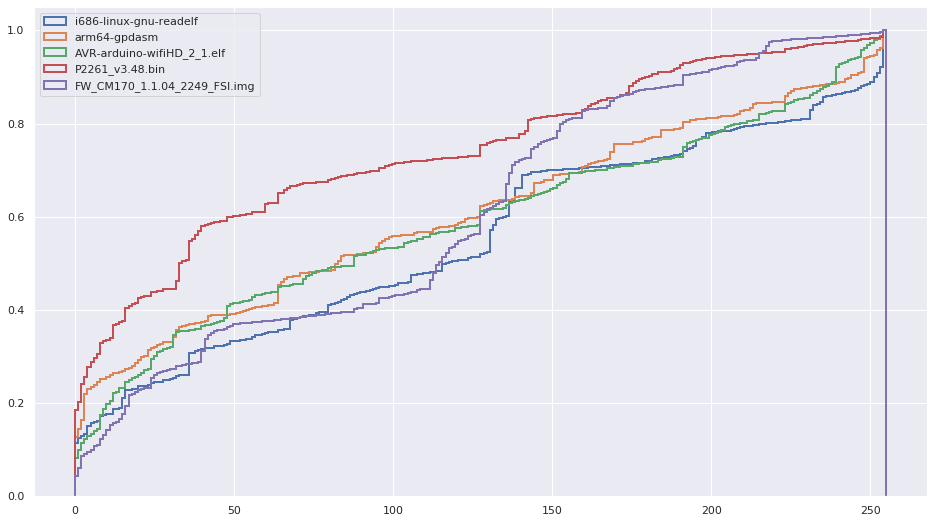

In [59]:
# create CDF
ax = sns.distplot(list(flanders_cluster_bytes),
                  norm_hist=True,     
                  kde=False,
                  hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':2, 'alpha':1},
                  kde_kws={'cumulative': True},  
                  bins=256,                      
                  color="purple")
ax.set_title("FW_CM170_1.1.04_2249_FSI.img machine code cluster byte value cumulative frequency distribution (CDF)")
ax.set_xlabel("byte values (0 - 255)")
plt.show()

plot_cdfs([readelf_cluster_bytes, gpdasm_cluster_bytes, AVR_cluster_bytes, draytek_cluster_bytes, flanders_cluster_bytes], 
          ["i686-linux-gnu-readelf","arm64-gpdasm", "AVR-arduino-wifiHD_2_1.elf", "P2261_v3.48.bin", "FW_CM170_1.1.04_2249_FSI.img"])

Like the machine code in `P2261_v3.48.bin`, the machine code in `FW_CM170_1.1.04_2249_FSI.img` has a quite distinctive distribution.

In [60]:
file_handle.close()

<hr>

<h2>6. P3_530.bin (PowerPC)</h2>
    
After downloading the file from AutomationDirect's website from the link provided at the beginning of the notebook and unpacking it, we see a number of binary files. The file of interest is `P3_530.bin`. A signature scan does not reveal too much, but a scan for instruction byte values results in many hits for PowerPC:

```
$ binwalk -A P3_530.bin 

DECIMAL       HEXADECIMAL     DESCRIPTION
--------------------------------------------------------------------------------
12636         0x315C          PowerPC big endian instructions, function epilogue
12644         0x3164          PowerPC big endian instructions, function epilogue
12652         0x316C          PowerPC big endian instructions, function epilogue
12668         0x317C          PowerPC big endian instructions, function epilogue
...
```

If this is the case, the byte value distribution of the machine code in this file should be unique. Let us find out if this is the case.

<h3>File Information Visualization</h3>

In [61]:
file_handle = open("../files/firmware/P3_530.bin", "rb")
p3_bin = BinFile(file_handle)

p3_bin.set_block_size(SIZE)
p3_bin.slice_file()

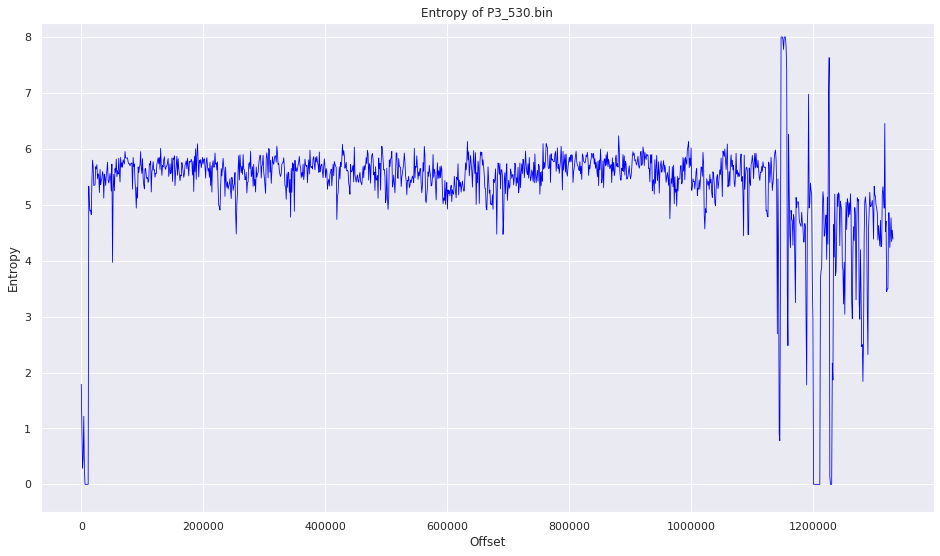

In [62]:
p3_bin.plot_file_entropy()

This looks to be much more straightforward in terms of types of information contained in the file than the other firmware binaries. This file is smaller as well, roughly 1.3 megabytes.

Judging by eye, the bytes between offsets 10000 and 1200000 look to be machine code. Let's look at the zeroes ratios.

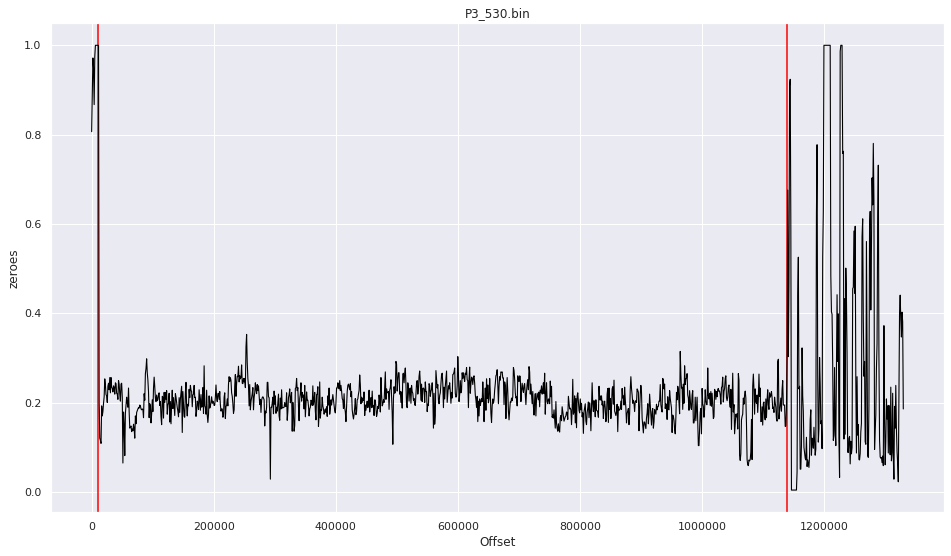

In [63]:
p3_bin.plot_file_feature("zeroes", "black", 10000, 1140000)

Let us also plot entropy vs. standard deviation:

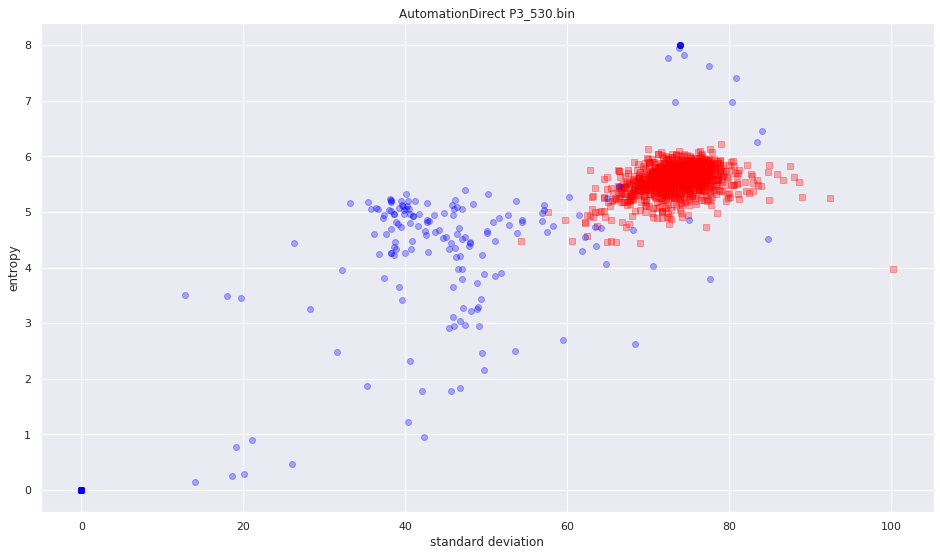

In [64]:
p3_bin.plot_variables_by_range(p3_bin.block_byteval_std_dev,              # 1st variable
                               p3_bin.block_entropy_levels,               # 2nd variable
                               10000,                                     # start file offset (e.g start of .text section)
                               1140000,                                   # end file offset
                               target_data_marker='s',                    # marker shape for points that fall within the specified offsets
                               other_data_marker='o',                     # marker for points outside of offsets
                               target_data_color='red',                   # color of points inside offsets
                               other_data_color='blue',                   # color of points outside offsets
                               title='AutomationDirect P3_530.bin',   
                               xlabel='standard deviation',
                               ylabel='entropy')

Only 1 clear cluster here. Let us see what DBSCAN finds.

<h3>Clustering with DBSCAN</h3>

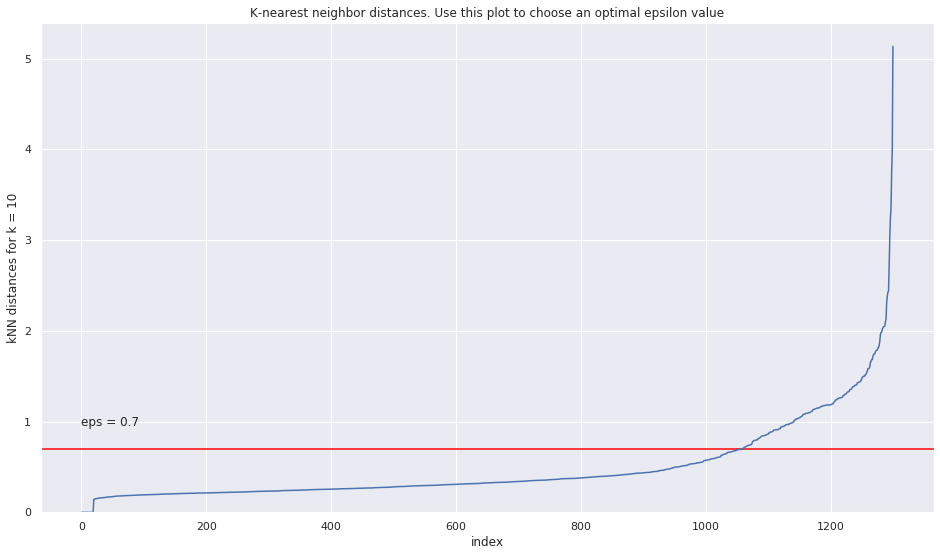

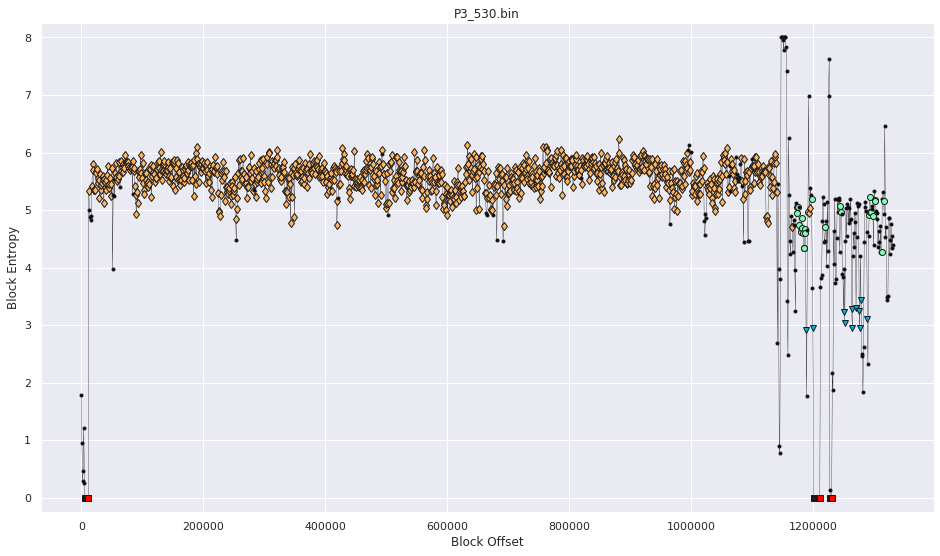

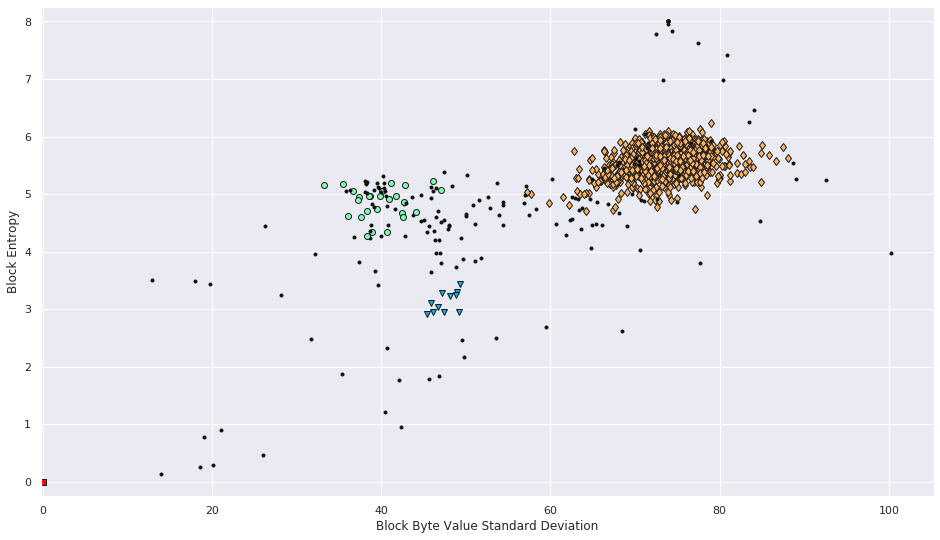

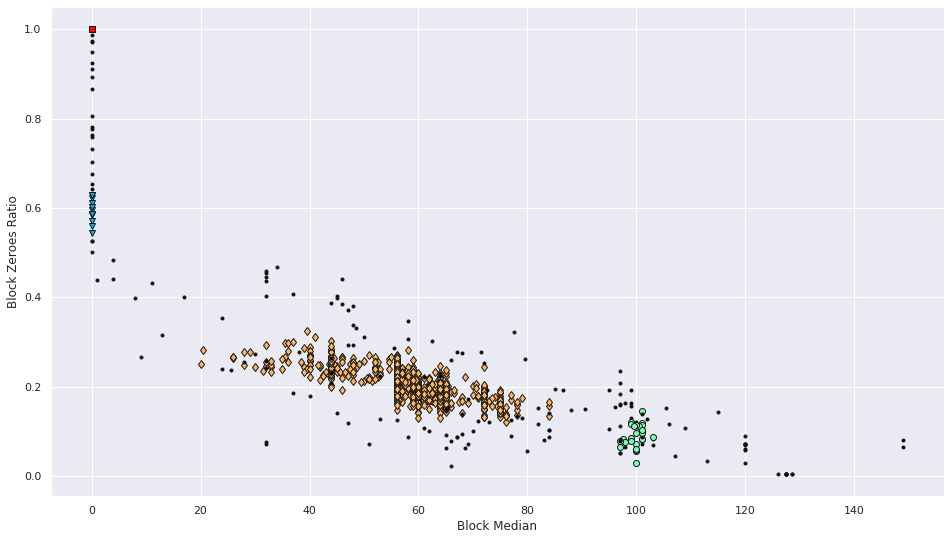

In [65]:
p3_bin.cluster_DBSCAN(epsilon=0.7,
                      minimum_samples=10,
                      find_optimal_epsilon=True)
p3_bin.plot_DBSCAN_results()

For the given values of `epsilon` and `minimum_samples`, DBSCAN actually finds 4 clusters. Some of these clusters are small and hard to see in these plots, so let us examine a scatterplot matrix.

/home/user01/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/user01/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


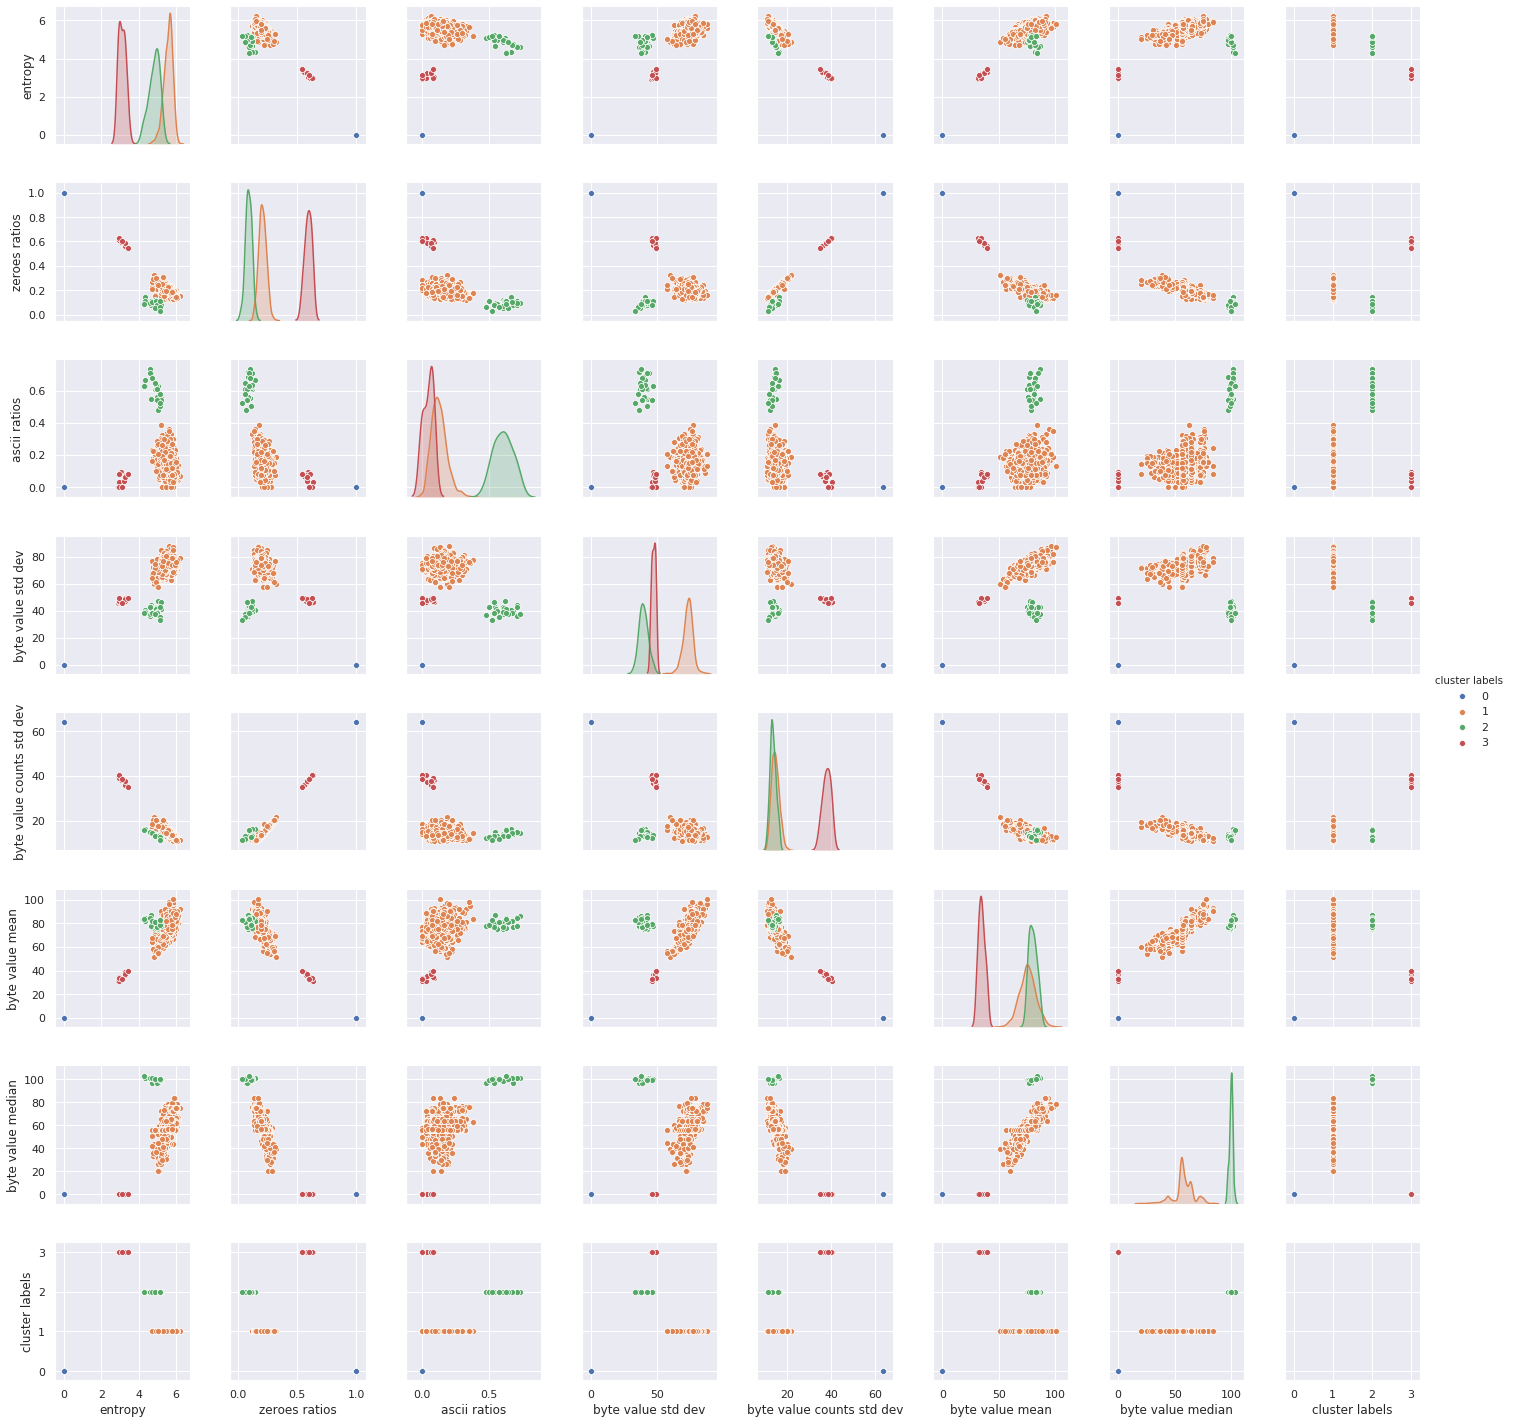

In [66]:
sns.pairplot(p3_bin.dbscan_data_frame[p3_bin.dbscan_data_frame["cluster labels"] != -1].drop(["core samples mask"], axis = 1), hue="cluster labels")

The clusters are very distinct, which is excellent.

<h3>Univariate Analysis of Cluster Features</h3>

Cluster 1 consists of machine code.

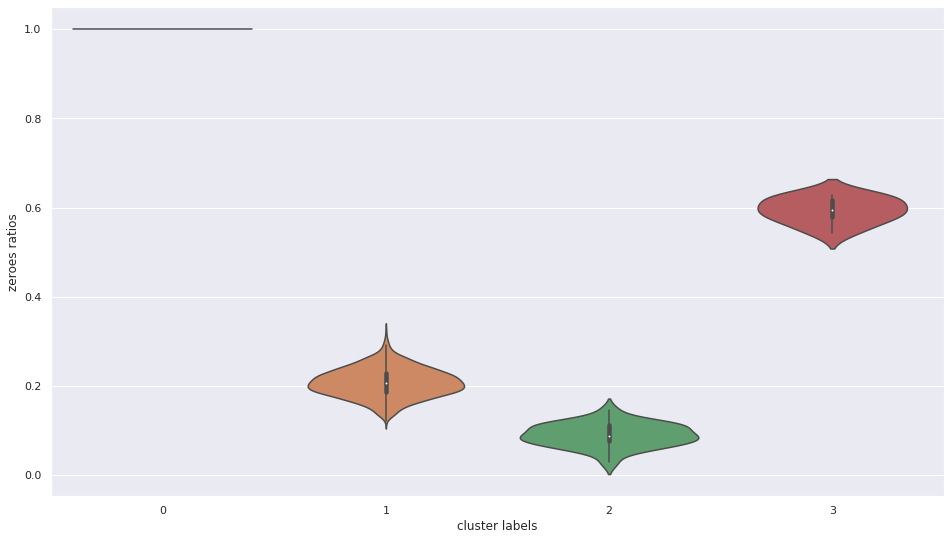

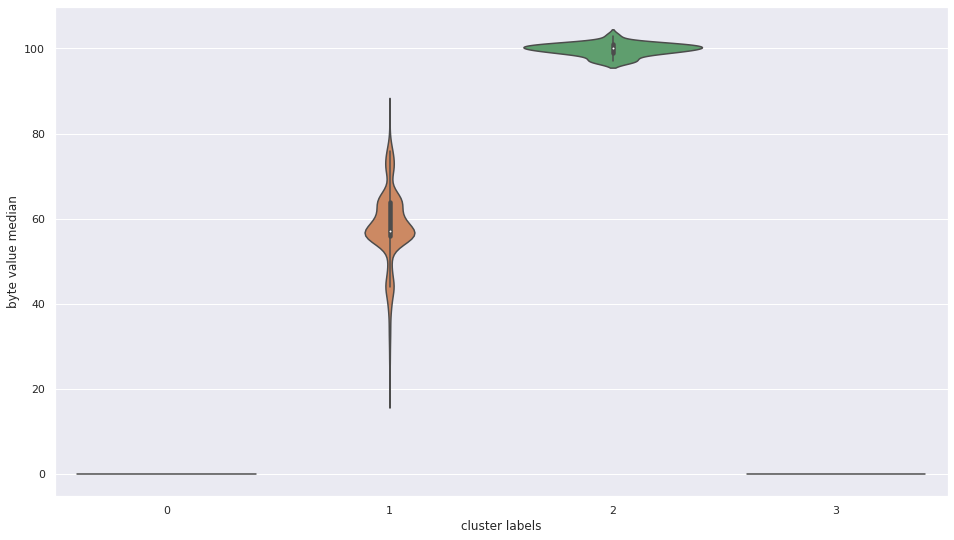

In [67]:
columns = ["zeroes ratios", "byte value median"]
for column in columns:
    ax = sns.violinplot(x = "cluster labels", 
                        y = column,
                        data = p3_bin.dbscan_data_frame[p3_bin.dbscan_data_frame["cluster labels"] != -1]) # exclude rows with cluster label -1
    plt.show()

<h3>Cluster Byte Value Distribution Analysis</h3>

In [68]:
p3_code_cluster = p3_bin.dbscan_data_frame[p3_bin.dbscan_data_frame["cluster labels"] == 1] # use filtering to extract cluster containing code

p3_cluster_bytes = []
p3_cluster_blocks = [p3_bin.blocks[i] for i in p3_code_cluster.index]

for block in p3_cluster_blocks:              # for each block, select the 1024 raw bytes
        p3_cluster_bytes += block.data  

In [184]:
p3_bin_means = p3_code_cluster.drop(["core samples mask", "cluster labels"], axis=1).describe().loc["mean"]
multi_arch_df["p3_bin (PowerPC)"] = p3_bin_means
multi_arch_df

readelf (x86)  gpdasm (ARM64)  wifiHD (AVR)  \
entropy                         5.843738        6.026331      6.386020   
zeroes ratios                   0.114274        0.126363      0.082174   
ascii ratios                    0.297686        0.204578      0.211755   
byte value std dev             87.770597       88.467059     88.934323   
byte value counts std dev      11.622925       10.726670      8.438990   
byte value mean               114.385940      100.342251    104.786166   
byte value median             113.847107       82.302326     86.084270   

                           draytek (MIPS)  flanders (Xtensa?)  p3_bin (PPC)  \
entropy                          5.560909            6.128258      5.591383   
zeroes ratios                    0.185356            0.043421      0.207225   
ascii ratios                     0.200661            0.268184      0.130413   
byte value std dev              73.936199           69.595915     73.574471   
byte value counts std dev       14.002901            8.661449     14.768284   
byte value mean                 65.847963           99.037991     75.673139   
byte value median               34.058200          114.306947     58.178808   

                           p3_bin (PowerPC)  
entropy                            5.591383  
zeroes ratios                      0.207225  
ascii ratios                       0.130413  
byte value std dev                73.574471  
byte value counts std dev         14.768284  
byte value mean                   75.673139  
byte value median                 58.178808

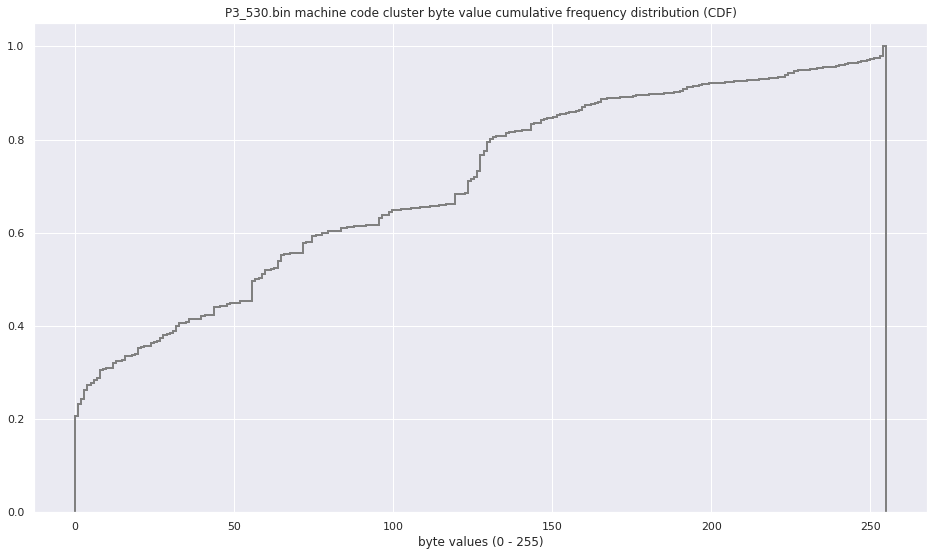

In [185]:
# create CDF
ax = sns.distplot(list(p3_cluster_bytes),
                  norm_hist=True,     
                  kde=False,
                  hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':2, 'alpha':1},
                  kde_kws={'cumulative': True},  
                  bins=256,                      
                  color="grey")
ax.set_title("P3_530.bin machine code cluster byte value cumulative frequency distribution (CDF)")
ax.set_xlabel("byte values (0 - 255)")
plt.show()

In [247]:
file_handle.close()

<h1>Comparing Machine Code Features by Architecture</h1>

The bytes in the machine code extracted from each file via clustering here do indeed have a unique distribution. The observations made here indicate that it is likely the distribution of byte value in machine code will vary depending on which architecture it targets.

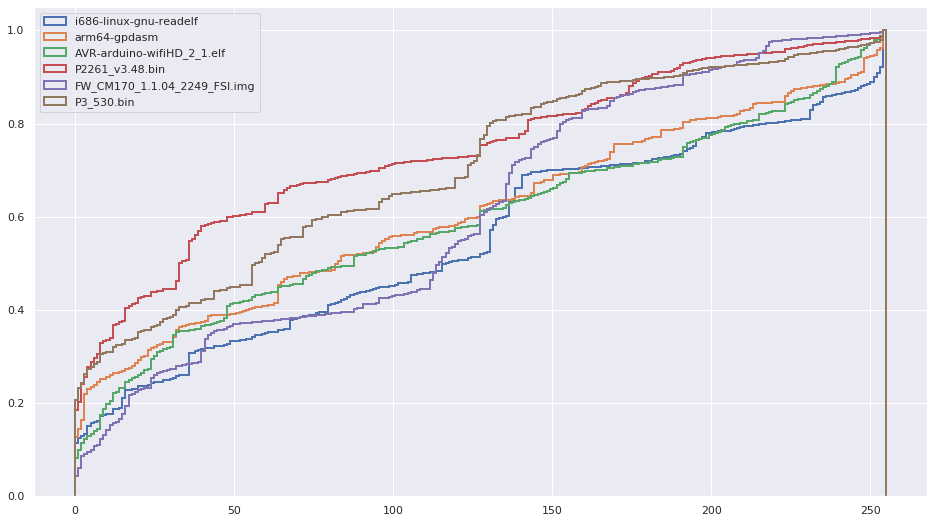

In [186]:
plot_cdfs([readelf_cluster_bytes, gpdasm_cluster_bytes, AVR_cluster_bytes, draytek_cluster_bytes, flanders_cluster_bytes, p3_cluster_bytes], 
          ["i686-linux-gnu-readelf","arm64-gpdasm", "AVR-arduino-wifiHD_2_1.elf", "P2261_v3.48.bin", "FW_CM170_1.1.04_2249_FSI.img", "P3_530.bin"])

In [202]:
multi_arch_T = multi_arch_df.T
multi_arch_T["file"] = multi_arch_T.index
multi_arch_T_1 = multi_arch_T.drop(["zeroes ratios", "ascii ratios"], axis = 1)
multi_arch_T_2 = multi_arch_T[["zeroes ratios", "ascii ratios", "file"]]

multi_arch_T_1 = pd.melt(multi_arch_T_1, id_vars="file")
multi_arch_T_2 = pd.melt(multi_arch_T_2, id_vars="file")

multi_arch_T

entropy  zeroes ratios  ascii ratios  byte value std dev  \
readelf (x86)       5.843738       0.114274      0.297686           87.770597   
gpdasm (ARM64)      6.026331       0.126363      0.204578           88.467059   
wifiHD (AVR)        6.386020       0.082174      0.211755           88.934323   
draytek (MIPS)      5.560909       0.185356      0.200661           73.936199   
flanders (Xtensa?)  6.128258       0.043421      0.268184           69.595915   
p3_bin (PowerPC)    5.591383       0.207225      0.130413           73.574471   

                    byte value counts std dev  byte value mean  \
readelf (x86)                       11.622925       114.385940   
gpdasm (ARM64)                      10.726670       100.342251   
wifiHD (AVR)                         8.438990       104.786166   
draytek (MIPS)                      14.002901        65.847963   
flanders (Xtensa?)                   8.661449        99.037991   
p3_bin (PowerPC)                    14.768284        75.673139   

                    byte value median                file  
readelf (x86)              113.847107       readelf (x86)  
gpdasm (ARM64)              82.302326      gpdasm (ARM64)  
wifiHD (AVR)                86.084270        wifiHD (AVR)  
draytek (MIPS)              34.058200      draytek (MIPS)  
flanders (Xtensa?)         114.306947  flanders (Xtensa?)  
p3_bin (PowerPC)            58.178808    p3_bin (PowerPC)

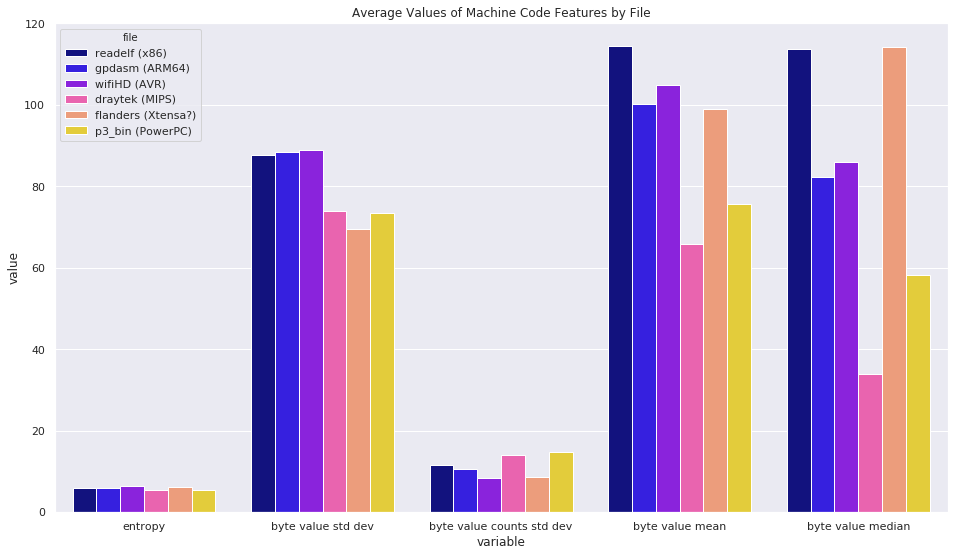

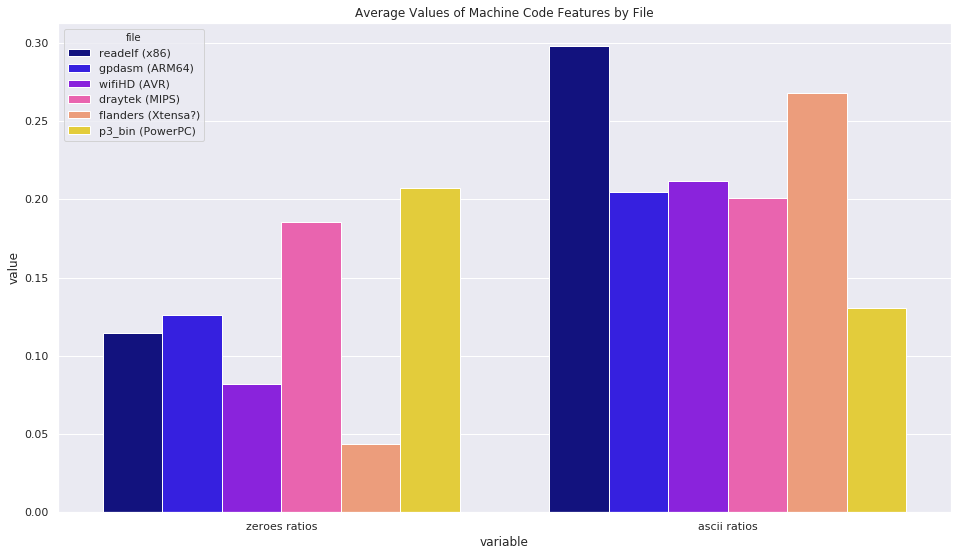

In [290]:
ax = sns.barplot(x="variable", y="value", hue="file", data=multi_arch_T_1, palette="gnuplot2")
ax.set_title("Average Values of Machine Code Features by File")
plt.show()

ax = sns.barplot(x="variable", y="value", hue="file", data=multi_arch_T_2, palette="gnuplot2")
ax.set_title("Average Values of Machine Code Features by File")
#ax.set_ylim(0,0.5)
plt.show()

In [284]:
import random
#import pylab

def plot_code_feature_dist(feature):
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    # sample size is limited by gpdasm, which only has 43 blocks in its machine code cluster
    df = pd.DataFrame({"i686-linux-gnu-readelf":       random.sample(sorted(readelf_code_cluster[feature]), 40),
                       "arm64-gpdasm":                 random.sample(sorted(gpdasm_code_cluster[feature]), 40),
                       "AVR-arduino-wifiHD_2_1.elf":   random.sample(sorted(AVR_code_cluster[feature]), 40),
                       "P2261_v3.48.bin":              random.sample(sorted(draytek_code_cluster[feature]), 40),
                       "FW_CM170_1.1.04_2249_FSI.img": random.sample(sorted(flanders_code_cluster[feature]), 40),
                       "P3_530.bin":                   random.sample(sorted(p3_code_cluster[feature]), 40)})
    
    features = {"entropy":8, 
                "zeroes ratios":0.5, 
                "ascii ratios":1, 
                "byte value std dev":140, 
                "byte value counts std dev":30, 
                "byte value mean":160, 
                "byte value median":160}
    
    ymax = features[feature]

    #boxplot
    ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)
    ax.set_ylim(0, ymax)
    ax.set_title("Per-file distributions of " + feature.upper() + " of blocks containing machine code")
    #ax.legend([feature])
    #pylab.text(0.95, 0.95,feature, ha='center', va='center', transform=ax.transAxes)
    plt.show()

    #violin plot
    ax = sns.violinplot(x="variable", y="value", data=pd.melt(df))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)
    ax.set_ylim(0, ymax)
    ax.set_title("Per-file distributions of " + feature.upper() + " of blocks containing machine code")
    
    plt.show()

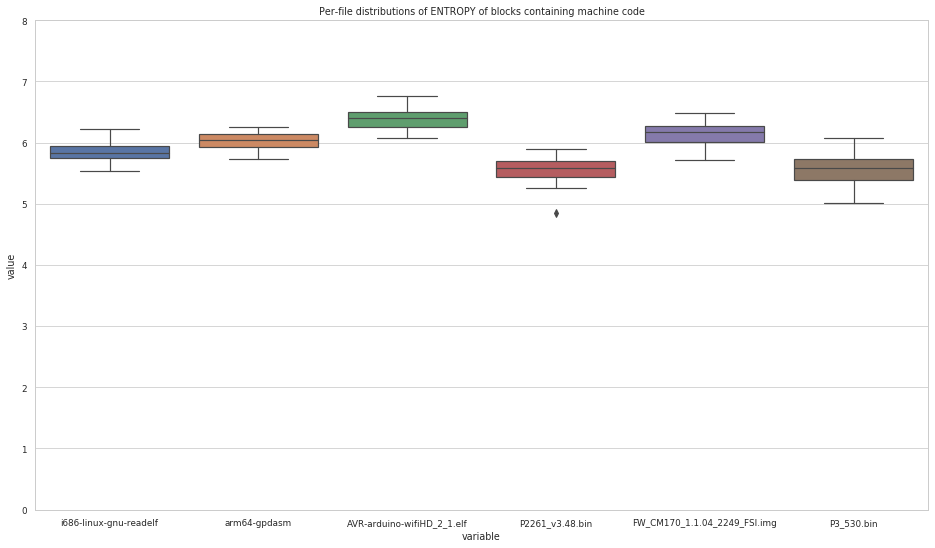

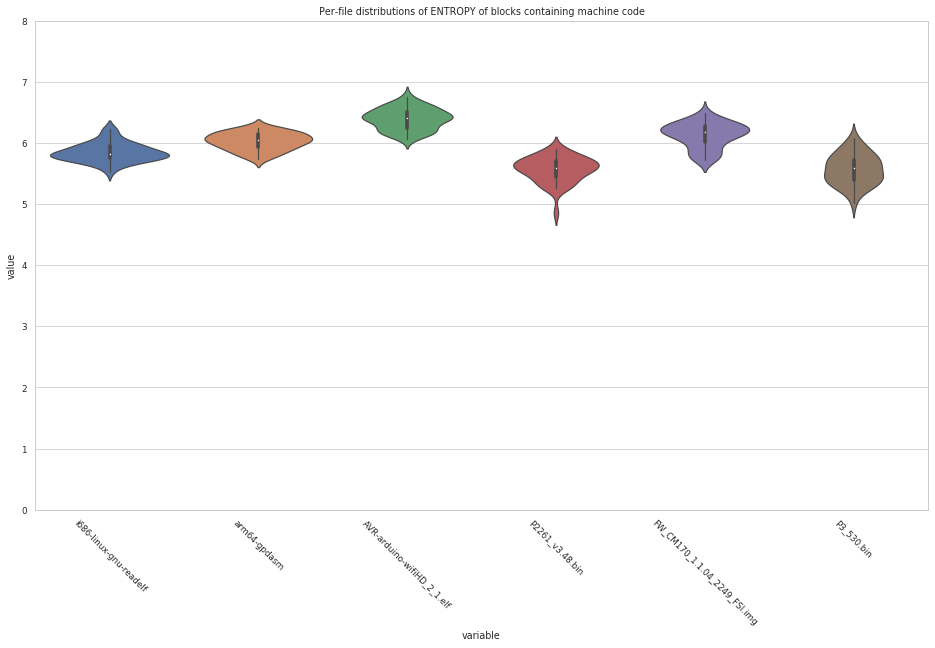

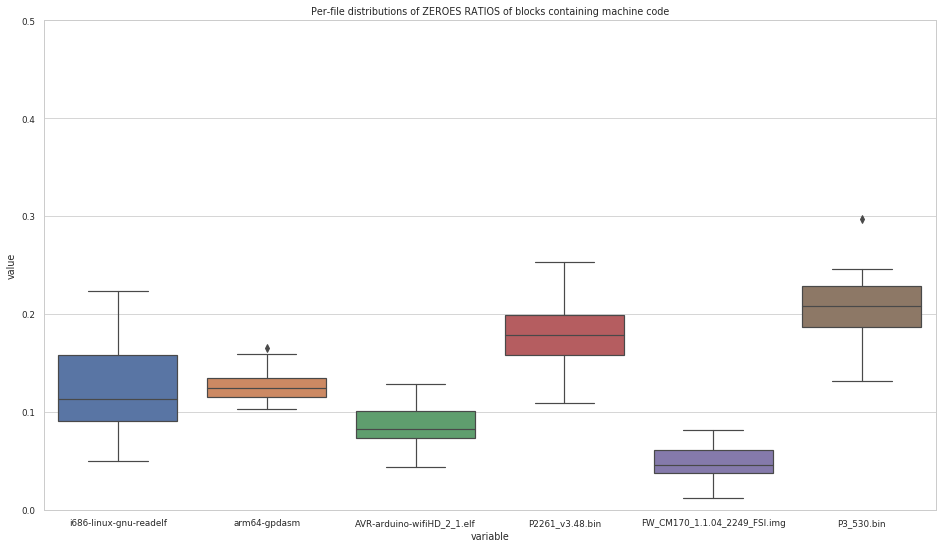

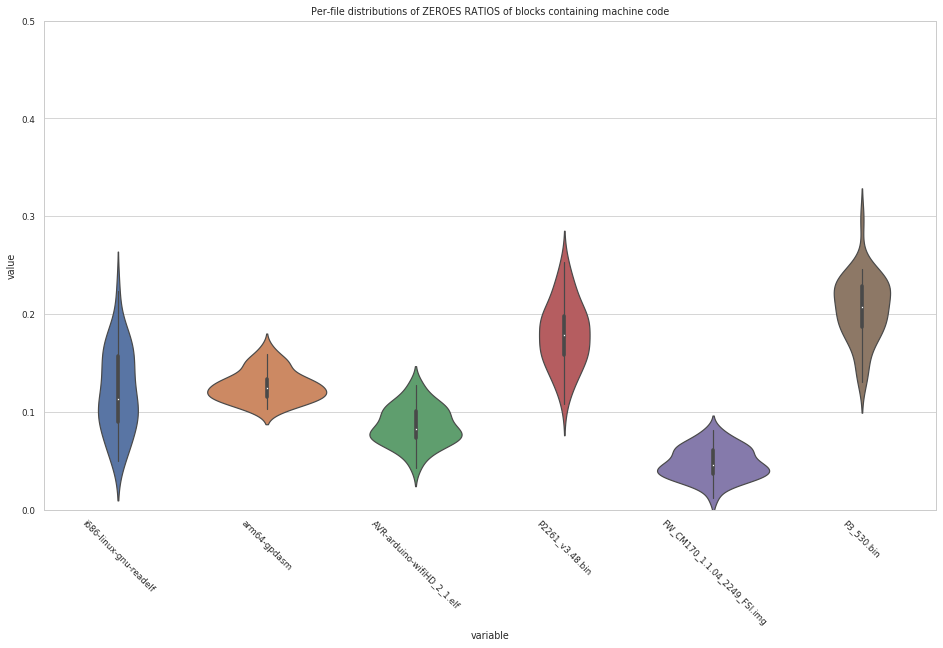

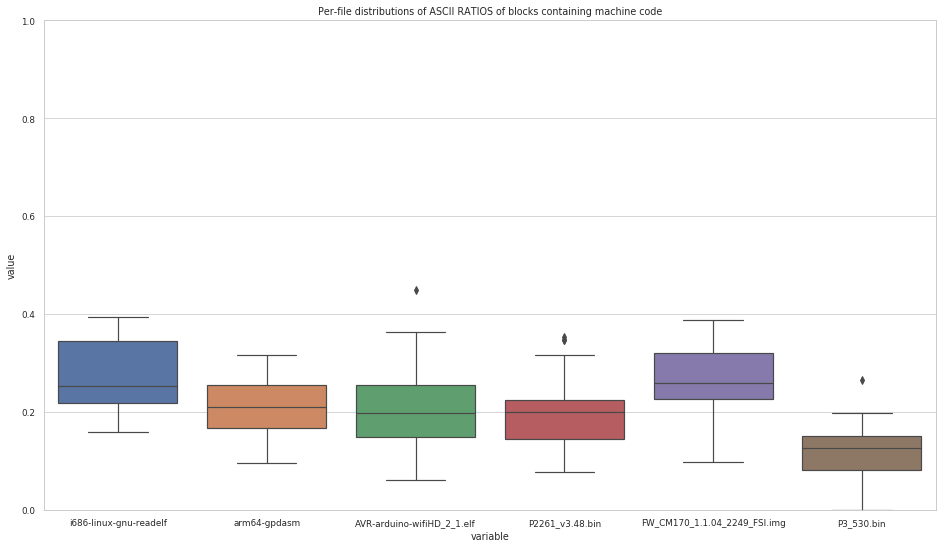

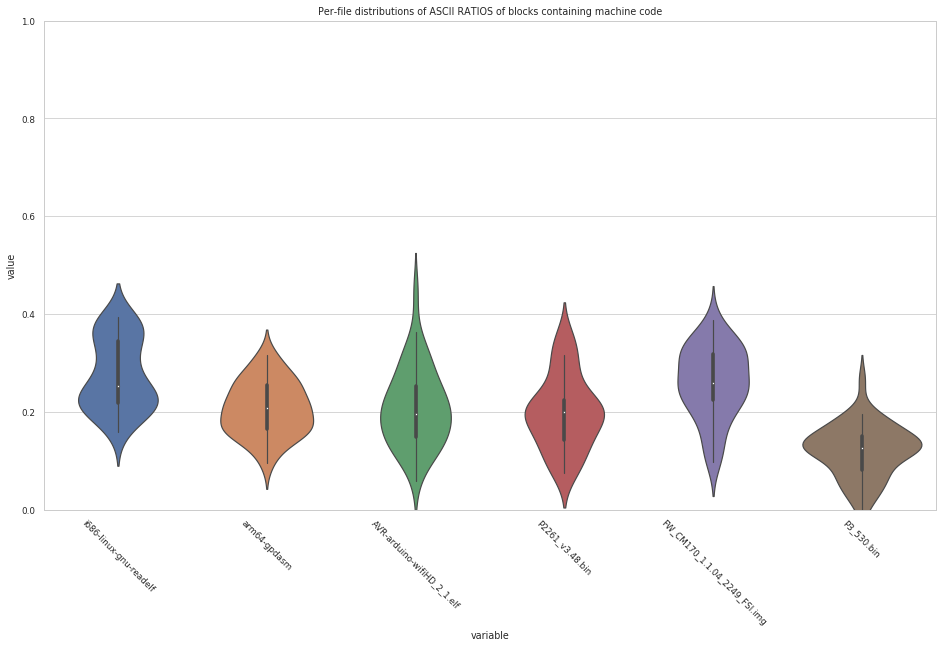

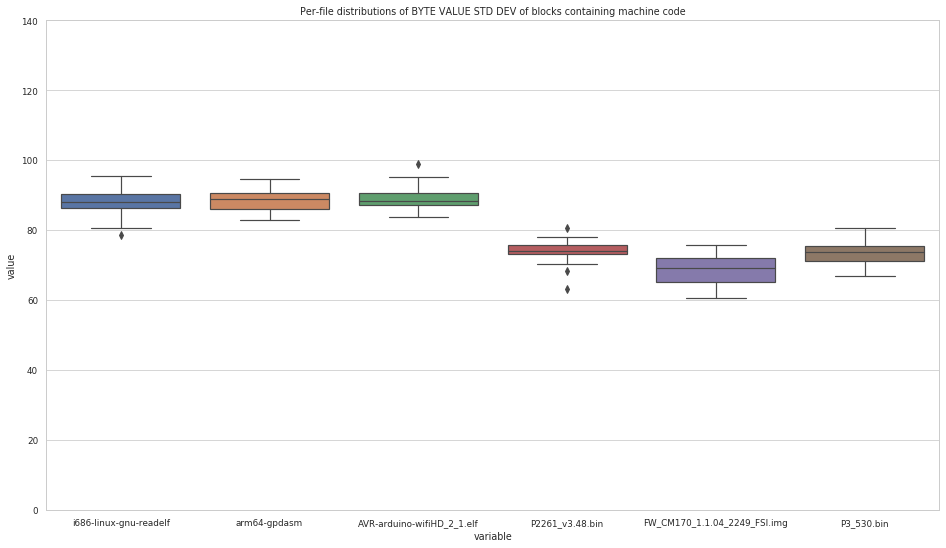

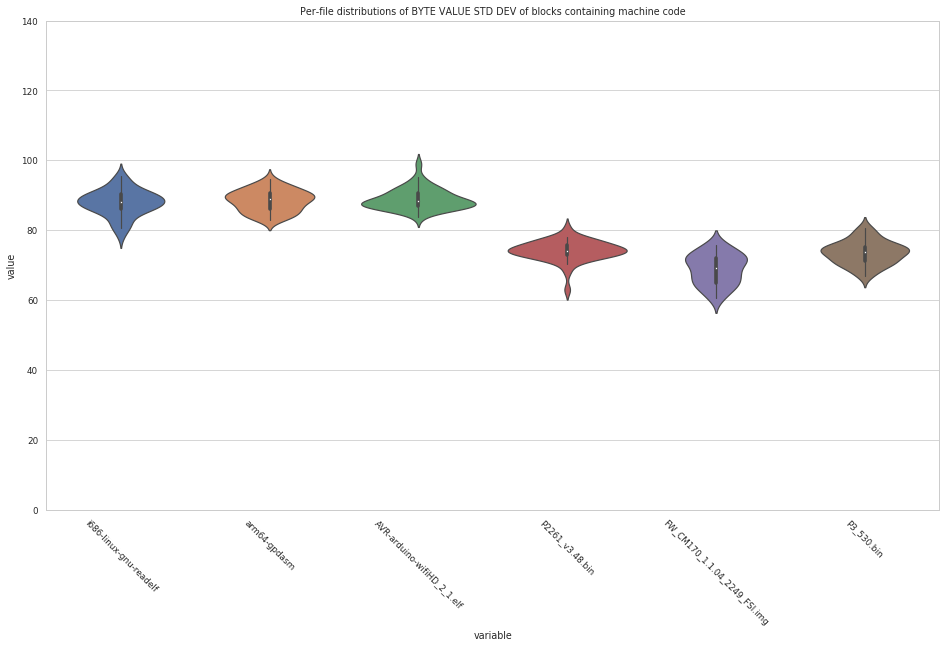

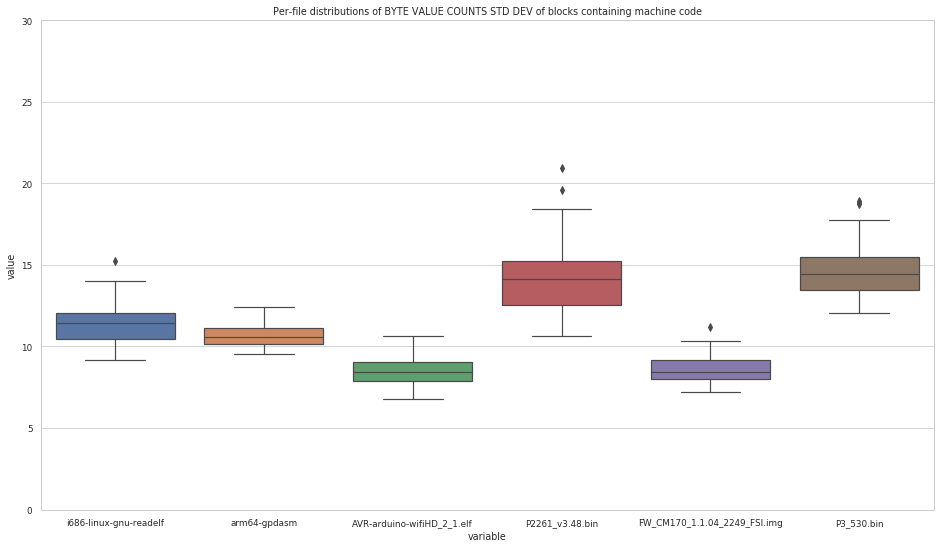

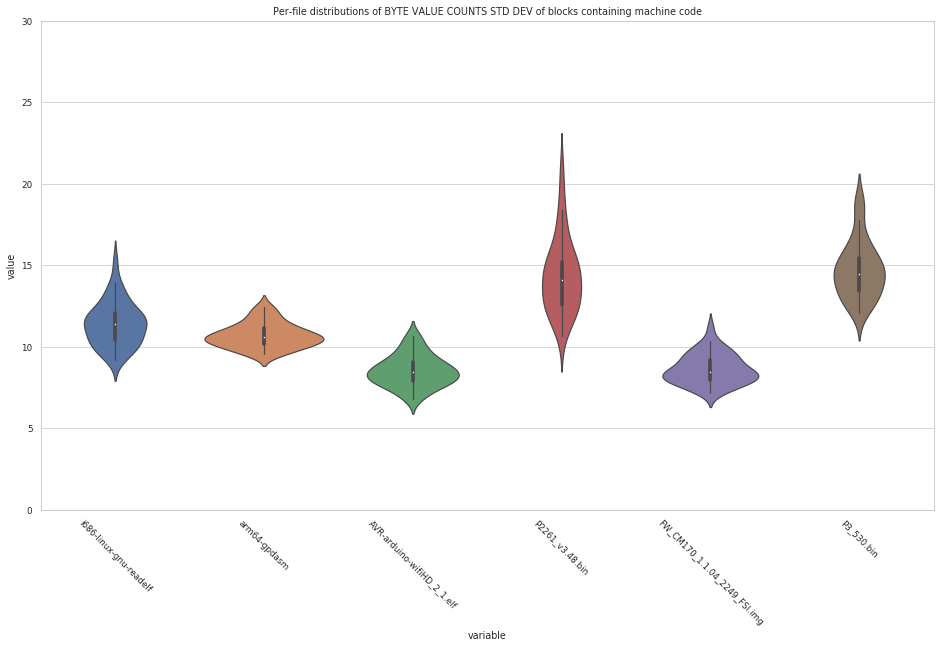

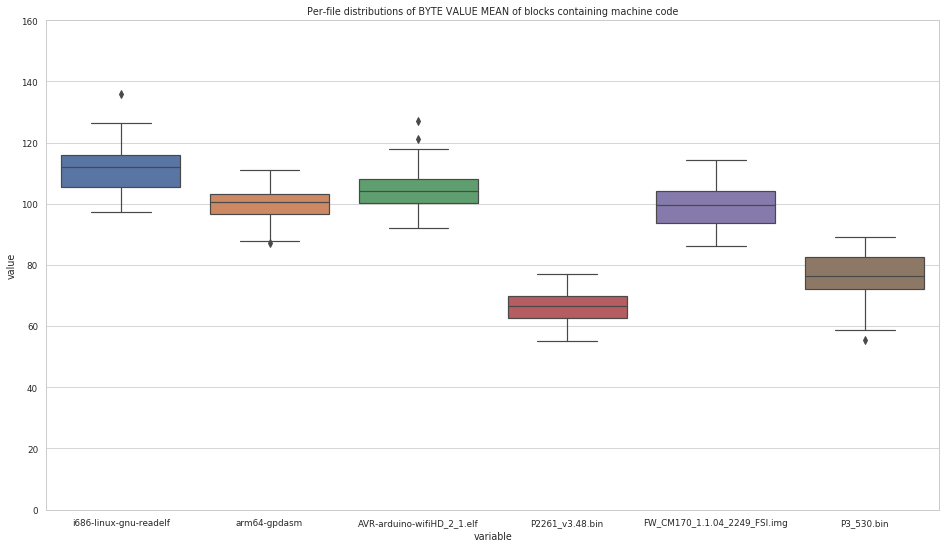

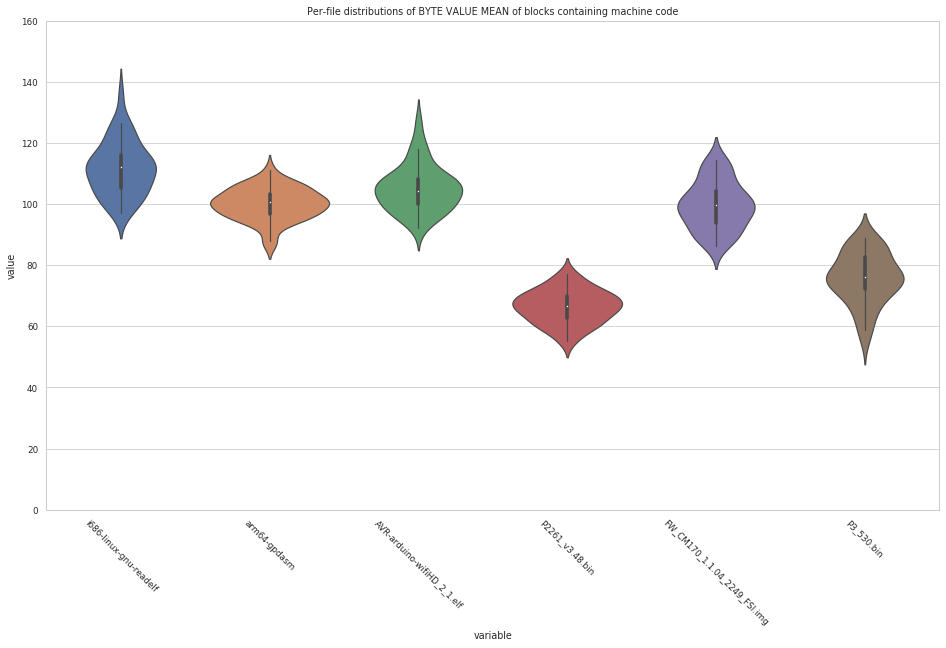

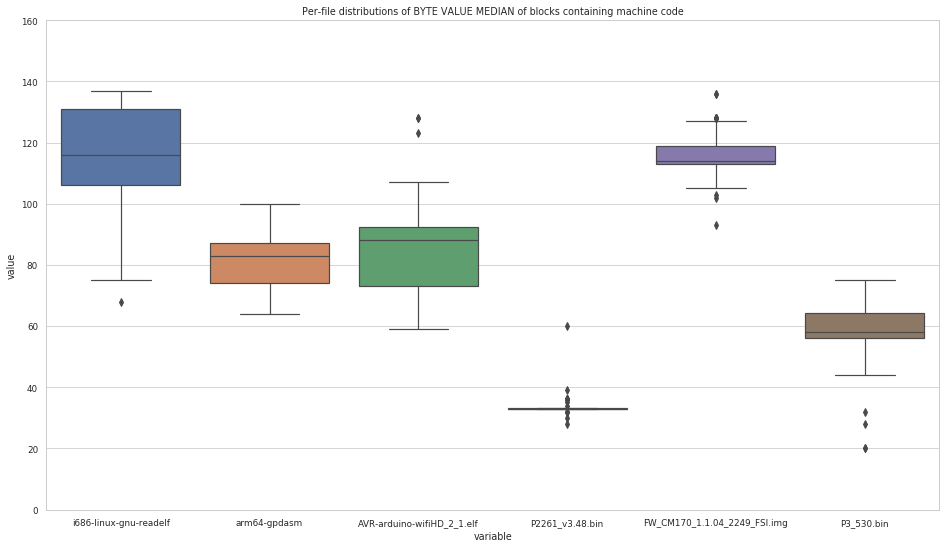

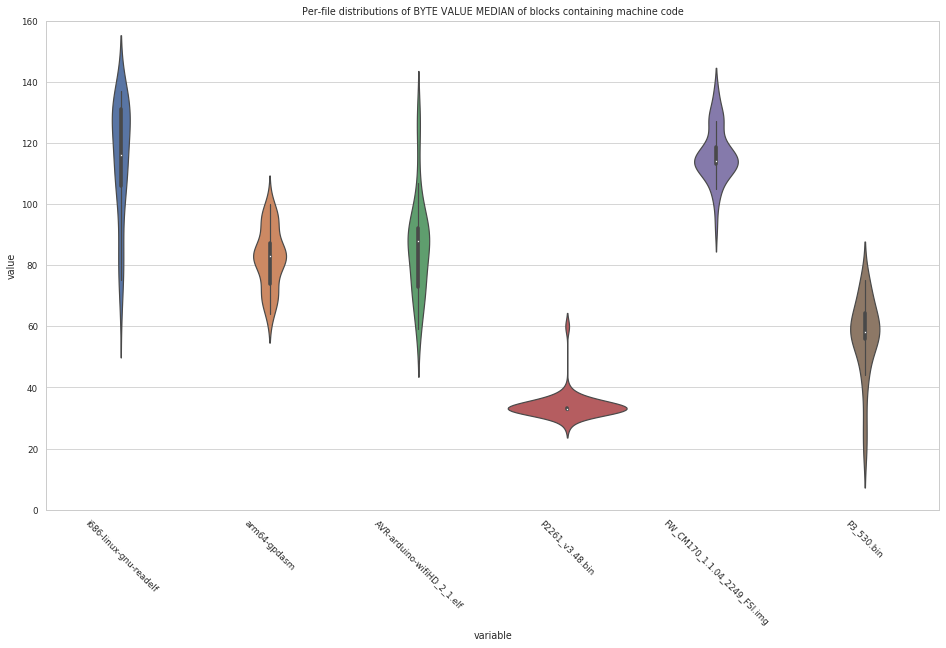

In [285]:
#plot_code_feature_dist("entropy")

variables = ["entropy",
             "zeroes ratios", 
             "ascii ratios",
             "byte value std dev", 
             "byte value counts std dev", 
             "byte value mean", 
             "byte value median"]

for variable in variables:
    plot_code_feature_dist(variable)

The above visualizations reveal a number of things:
 - The distribution of byte values in machine code is strongly related to the target architecture
 - **differences** between distributions of code byte values seems to be best captured by the distribution of
   - block medians
   - block means
   - block zeroes ratios
 - At the same time, there are broad **similarities** across architectures in terms of
   - block entropy levels
   - block standard deviations
   - the ratio of bytes that fall within the range of printable ASCII characters in each block
   
   
Obviously, conclusions about an architecture should not be drawn on the basis of a single example, so further exploration and larger samples are required. The files explored here do help us get a sense for what to look for.

<hr>

Notebook created by julian